# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [3]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\logistic_stochastic"

my_path = os.path.abspath(__file)

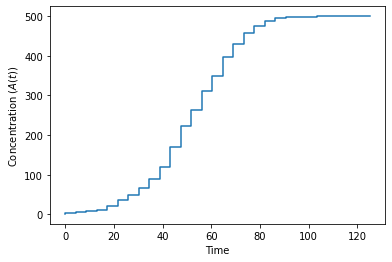

In [5]:
n_0 = 1
model = pints.toy.stochastic.LogisticModel(n_0)

times = np.linspace(0, 125, 30)

# $b_0$ = 0.1, $k$ = 500
params = [0.1, 500]

values = model.simulate(params, times)
problem = pints.SingleOutputProblem(model, times, values)
error_measure = pints.RootMeanSquaredError(problem)

log_prior = pints.UniformLogPrior([0.0, 400], [0.3, 700])

plt.step(times, values)
plt.xlabel('Time')
plt.ylabel(r'Concentration ($A(t)$)')
# plt.show()
plt.savefig(my_path + './log_sto_data.pdf')

# Rejection ABC

In [3]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(30)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     132    0.00757575758    0:01.2
2     165    0.0121212121     0:01.5
3     246    0.012195122      0:02.3
20    1186   0.0168634064     0:09.6
40    2333   0.0171453065     0:17.6
60    3475   0.0172661871     0:30.8
80    4738   0.0168847615     0:57.4
100   5837   0.0171320884     1:17.1
120   7268   0.016510732      1:30.9
140   8770   0.015963512      1:56.8
160   10757  0.0148740355     2:30.9
180   11895  0.0151324086     2:51.0
200   13363  0.0149666991     3:13.1
220   15086  0.0145830571     3:38.6
240   16330  0.0146968769     3:56.8
260   17598  0.0147744062     4:14.3
280   18893  0.0148203038     4:33.6
300   20365  0.0147311564     4:54.4
320   21334  0.0149995313     5:09.1
340   23095  0.0147218013     5:36.7
360   23896  0.0150652829     5:48.4
380   25455  0.0149283049     6:09.3
400   27268  0.0146692093     6:25.2
420   28421  0.0147778051     6:34.6
440   29343  0.0

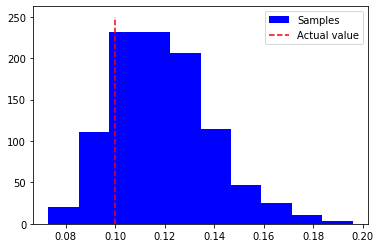

In [4]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

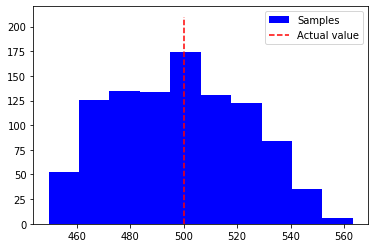

In [5]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=210, label="Actual value", color="red")
plt.legend()
plt.show()

[]

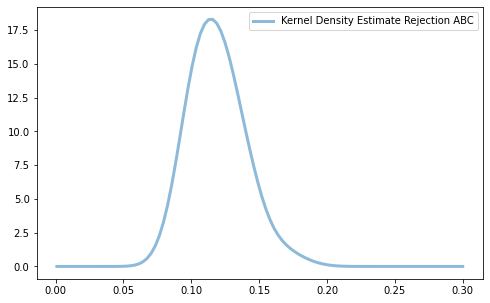

In [20]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.3, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.legend()
ax.plot()

In [9]:
samples_abc_rej = samples_flat

# PMC

In [10]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([50, 40, 30]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=40
Trying t=2, threshold=30
Iter. Eval. Acceptance rate Time m:s
1     25812  3.87416705e-05   3:22.5
2     25815  7.74743366e-05   3:22.6
3     25825  0.000116166505   3:22.6
20    25989  0.000769556351   3:23.8
40    26189  0.00152735881    3:25.4
60    26364  0.00227583068    3:26.7
80    26516  0.00301704631    3:27.8
100   26699  0.00374545863    3:29.2
120   26847  0.00446977316    3:30.4
140   27037  0.00517808929    3:31.9
160   27169  0.00588906474    3:33.0
180   27328  0.00658665105    3:34.3
200   27483  0.00727722592    3:35.5
220   27637  0.00796034302    3:36.7
240   27832  0.00862316758    3:38.0
260   27970  0.00929567394    3:39.2
280   28108  0.00996157678    3:40.2
300   28194  0.0106405618     3:40.8
320   28362  0.0112827022     3:42.0
340   28474  0.0119407178     3:42.9
360   28631  0.0125737837     3:44.0
380   28800  0.0131944444     3:45.3
400   28928  0.0138274336     3:46.2
420   29058  0.01445

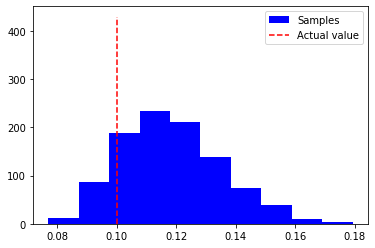

In [11]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=430, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

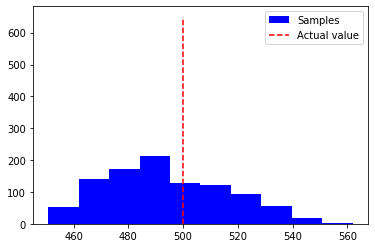

In [12]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=650, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [13]:
samples_pmc_orig = samples

[]

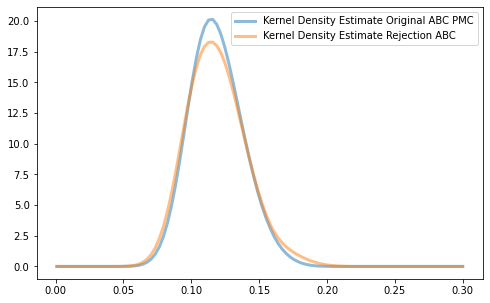

In [18]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.3, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.legend()
ax.plot()

# ABC SMC

In [21]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([50, 40, 30]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=40
Trying t=2, threshold=30
Iter. Eval. Acceptance rate Time m:s
1     5166   0.000193573364   1:28.0
2     5183   0.000385876905   1:28.2
3     5186   0.000578480524   1:28.2
20    5311   0.00376576916    1:29.1
40    5441   0.00735158978    1:30.3
60    5555   0.0108010801     1:31.2
80    5727   0.0139689192     1:32.5
100   5872   0.0170299728     1:33.6
120   6055   0.019818332      1:35.0
140   6199   0.0225842878     1:36.1
160   6390   0.0250391236     1:37.5
180   6507   0.0276625173     1:38.4
200   6616   0.0302297461     1:39.2
220   6797   0.0323672208     1:40.6
240   6998   0.034295513      1:42.1
260   7174   0.0362419849     1:43.4
280   7335   0.0381731425     1:44.6
300   7514   0.0399254725     1:45.9
320   7717   0.0414668913     1:47.4
340   7847   0.0433286606     1:48.5
360   7979   0.0451184359     1:49.5
380   8203   0.0463245154     1:51.2
400   8319   0.0480827022     1:52.1
420   8447   0.04972

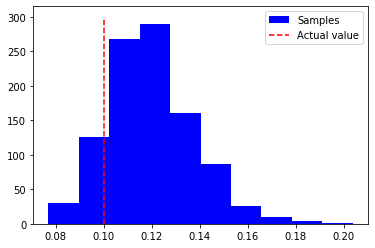

In [22]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

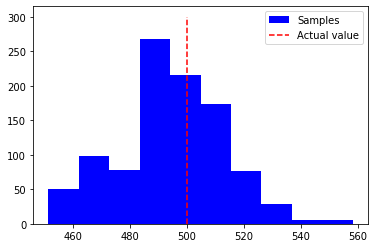

In [23]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [24]:
samples_pmc_fake = samples

[]

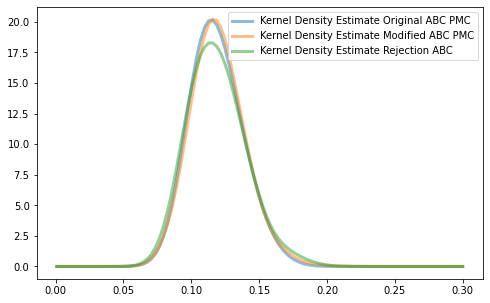

In [25]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.3, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)    
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.legend()
ax.plot()

# Adaptive PMC ABC

In [33]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[1.56638110e-01 5.46463974e+02]
resulting var=[[ 1.24656742e-02 -6.52147482e-01]
 [-6.52147482e-01  1.51031597e+04]]
epsilon=302.7876043257605
w_mean=[1.65257867e-01 5.59794436e+02]
resulting var=[[9.69369602e-03 1.60106355e+00]
 [1.60106355e+00 1.35831699e+04]]
epsilon=267.37308515755035
w_mean=[1.58198203e-01 5.43147641e+02]
resulting var=[[ 9.92672498e-03 -1.28331675e+00]
 [-1.28331675e+00  1.18759258e+04]]
epsilon=240.1867329114301
w_mean=[1.59364866e-01 5.37623163e+02]
resulting var=[[ 8.73652940e-03 -2.54989967e+00]
 [-2.54989967e+00  1.20195210e+04]]
epsilon=216.4060997291897
w_mean=[1.5880284e-01 5.3581056e+02]
resulting var=[[ 8.88849244e-03 -4.18560334e+00]
 [-4.18560334e+00  1.30715107e+04]]
epsilon=201.473985086578
w_mean=[1.56244997e-01 5.32044822e+02]
resulting var=[[ 8.42951632e-03 -4.48103880e+00]
 [-4.48103880e+00  1.34668680e+04]]
epsilon=185.35425541378865
w_mean=[1.52858146e-01 5.29301363e+02]
resu

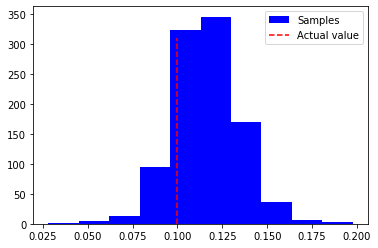

In [34]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

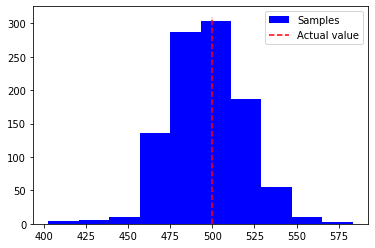

In [35]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [36]:
samples_adaptive = samples

# Hamiltonian ABC

In [62]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [81]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
                
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=1)
                    next_theta = curr_theta + self._eps * np.random.normal(0, np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [82]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.15, 600])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return model.simulate(theta, times)


abc = HABCsgld(1000, theta0, 10, np.array([0.005, 0.1]), 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
t= 1, curr_theta =[[4.69032454e-02 5.82838192e+02]
 [4.49771274e-02 5.83161131e+02]]
t= 2, curr_theta =[[8.47225275e-02 5.58345243e+02]
 [7.71344251e-02 5.58589288e+02]]
t= 3, curr_theta =[[5.26995587e-02 5.87411637e+02]
 [5.92096653e-02 5.88135500e+02]]
t= 4, curr_theta =[[7.98709242e-02 5.83026881e+02]
 [9.63018848e-02 5.83692044e+02]]
t= 5, curr_theta =[[1.41649220e-01 5.77260654e+02]
 [1.69972211e-01 5.78217860e+02]]
t= 6, curr_theta =[[1.06310228e-01 5.76112767e+02]
 [1.49955952e-01 5.76639509e+02]]
t= 7, curr_theta =[[1.02677161e-01 5.43195327e+02]
 [1.53397760e-01 5.43591485e+02]]
t= 8, curr_theta =[[1.23995274e-01 5.47088933e+02]
 [1.70729959e-01 5.48070993e+02]]
t= 9, curr_theta =[[1.65424512e-01 5.00230982e+02]
 [2.04155663e-01 5.01419589e+02]]
t= 10, curr_theta =[[1.61161065e-01 4.98554177e+02]
 [2.11456481e-01 4.99841954e+02]]
t= 11, curr_theta =[[1.96194699e-01 4.99172414e+02]
 [2.32453426e-01 5.01153433e+02]]
t= 12, curr_theta =[[1.37252950e-01 5.32444007e+02]

In [83]:
samples_hamiltonian = np.array([x for z in results[2:] for x in z])

[]

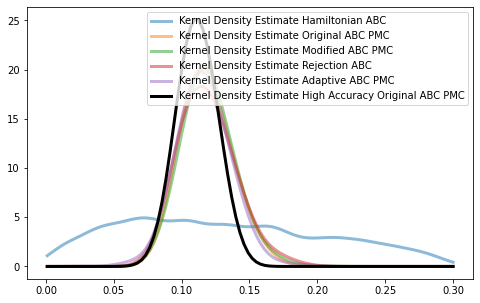

In [84]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.3, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)    
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_high_acc)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate High Accuracy Original ABC PMC', linewidth=3, alpha=1, color='black')
ax.legend()
ax.plot()

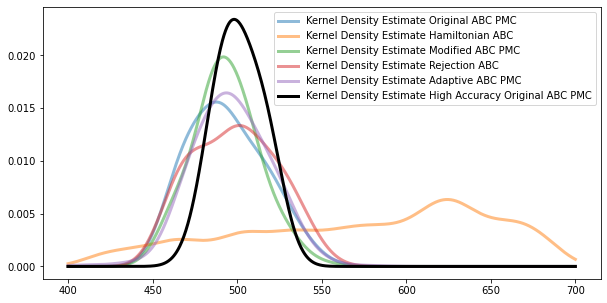

In [85]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(400, 700, 1000)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

band_w = 10

ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)    
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Adaptive ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_high_acc)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate High Accuracy Original ABC PMC', linewidth=3, alpha=1, color='black')

ax.legend()
ax.savefig(my_path + './')

# High Accuracy PMC

In [11]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([40, 30, 15]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(3000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=40
Iter. Eval. Acceptance rate Time m:s
1     5      0.2              0:00.0
2     91     0.021978022      0:00.7
3     182    0.0164835165     0:01.6
20    784    0.0255102041     0:06.6
40    1394   0.0286944046     0:11.4
60    2274   0.0263852243     0:17.8
80    2988   0.0267737617     0:25.5
100   3853   0.0259538022     0:32.9
120   4418   0.0271616116     0:38.7
140   5286   0.0264850549     0:45.5
160   5846   0.0273691413     0:49.9
180   6714   0.0268096515     0:56.7
200   7542   0.0265181649     1:07.3
220   8176   0.0269080235     1:14.6
240   8895   0.0269814503     1:20.0
260   9751   0.0266639319     1:26.5
280   10149  0.027588925      1:29.4
300   10773  0.0278473963     1:34.2
320   11395  0.0280824923     1:38.5
340   11981  0.0283782656     1:42.5
360   12891  0.0279264603     1:48.6
380   13680  0.0277777778     1:54.1
400   14241  0.0280879152     1:58.7
420   15074  0.0278625448     2:04.8
4

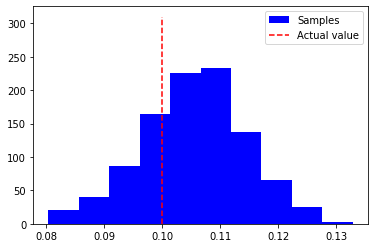

In [18]:
plt.hist(samples[2000:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

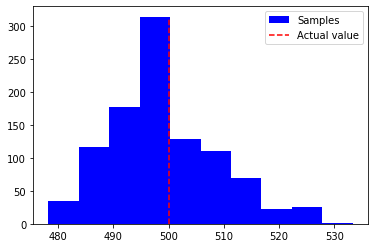

In [19]:
plt.hist(samples[2000:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=310, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

In [17]:
samples_high_acc = samples[2000:]

# Visualizations

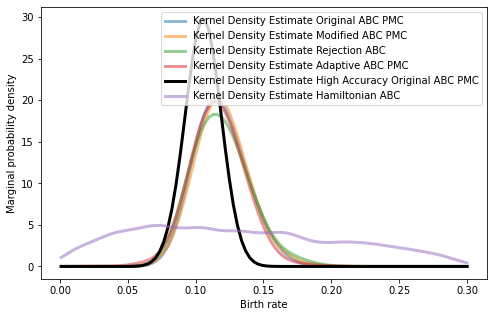

In [26]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.001, 0.3, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)    
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_high_acc)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate High Accuracy Original ABC PMC', linewidth=3, alpha=1, color='black')
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.legend()
plt.xlabel("Birth rate")
plt.ylabel("Marginal probability density")
# ax.plot()

plt.savefig(my_path + './logistic_k1_kdes.pdf')

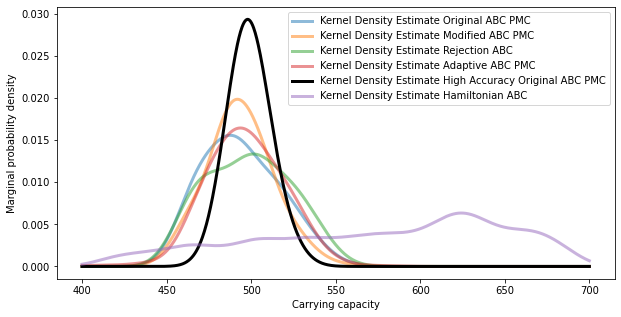

In [27]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(400, 700, 1000)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

band_w = 10

ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_orig)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)    
ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Adaptive ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_high_acc)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate High Accuracy Original ABC PMC', linewidth=3, alpha=1, color='black')
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=band_w),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
# ax.plot()
plt.xlabel("Carrying capacity")
plt.ylabel("Marginal probability density")
ax.legend()
plt.savefig(my_path + './logistic_k2_kdes.pdf')

# KL-divergence

In [25]:
from scipy import integrate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kl_func_x(y, kde_skl):
    part = kde_sklearn(np.array(samples_high_acc)[:, 0], np.array([y]), bandwidth=0.01)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.025, 0.3)

def kl_func_y(y, kde_skl):
    part = kde_sklearn(np.array(samples_high_acc)[:, 1], np.array([y]), bandwidth=10)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 400, 700)

x_grid = np.linspace(0.001, 0.3, 100)
saved_abc_rej = kl_div_x(np.array(samples_abc_rej)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_abc_rej)[:, 1], 10)[0]
saved_fake_pmc = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 10)[0]
saved_orig_pmc = kl_div_x(np.array(samples_pmc_orig)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_pmc_orig)[:, 1], 10)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_adaptive)[:, 1], 10)[0]
saved_hamiltonian = kl_div_x(np.array(samples_hamiltonian)[:, 0], 0.01)[0] + kl_div_y(np.array(samples_hamiltonian)[:, 1], 10)[0]

print("ABC REJ KL = " + str(saved_abc_rej))
print("MOD PMC KL = " + str(saved_fake_pmc))
print("ORIG PMC KL = " + str(saved_orig_pmc))
print("ADAPTIVE KL = " + str(saved_adaptive))
print("HAMILTONIAN KL = " + str(saved_hamiltonian))

ABC REJ KL = 0.6785864419156841
MOD PMC KL = 0.5224414318328156
ORIG PMC KL = 0.6202219756803022
ADAPTIVE KL = 0.5007825511853325
HAMILTONIAN KL = 3.149125780528827


# Data

In [26]:
print(samples_abc_rej.tolist())

[[0.0906230479177025, 546.6416895503658], [0.1341039629365475, 470.80259622986955], [0.11334020502602156, 518.0496796408843], [0.15042990858452907, 489.4383534200854], [0.14541453920636851, 472.5848248807011], [0.12036442893393733, 472.9604698182464], [0.11534635953426445, 482.18341770714414], [0.10232806726853967, 511.47485714259165], [0.0764360394439684, 542.5462639261914], [0.1432099950707655, 510.84912353204214], [0.10347692298844681, 500.1437115548729], [0.13484585415812164, 472.9209019697333], [0.0909794628093897, 506.0279998805109], [0.09350507849605041, 546.6136756016307], [0.09775830979904833, 504.13393157739245], [0.10100520711095522, 459.05433481472176], [0.1250186838188172, 525.0091653465216], [0.11269467900347861, 508.88736531841386], [0.13893899730761072, 478.3156824799661], [0.10935235166774182, 506.4426194614742], [0.12147075976367375, 463.87004224907895], [0.1071448993827649, 529.7149450648925], [0.09627719819410872, 552.5593728294988], [0.16837191619741387, 455.920776

In [6]:
samples_abc_rej = [[0.0906230479177025, 546.6416895503658], [0.1341039629365475, 470.80259622986955], [0.11334020502602156, 518.0496796408843], [0.15042990858452907, 489.4383534200854], [0.14541453920636851, 472.5848248807011], [0.12036442893393733, 472.9604698182464], [0.11534635953426445, 482.18341770714414], [0.10232806726853967, 511.47485714259165], [0.0764360394439684, 542.5462639261914], [0.1432099950707655, 510.84912353204214], [0.10347692298844681, 500.1437115548729], [0.13484585415812164, 472.9209019697333], [0.0909794628093897, 506.0279998805109], [0.09350507849605041, 546.6136756016307], [0.09775830979904833, 504.13393157739245], [0.10100520711095522, 459.05433481472176], [0.1250186838188172, 525.0091653465216], [0.11269467900347861, 508.88736531841386], [0.13893899730761072, 478.3156824799661], [0.10935235166774182, 506.4426194614742], [0.12147075976367375, 463.87004224907895], [0.1071448993827649, 529.7149450648925], [0.09627719819410872, 552.5593728294988], [0.16837191619741387, 455.92077679049993], [0.10502368836170402, 506.4296299375649], [0.1175301379590387, 488.87184360020933], [0.10376467148251878, 484.29552363685497], [0.09819218396650428, 519.6432687152519], [0.11667774453119588, 531.517302771864], [0.1289321153058207, 462.773057464518], [0.16696427572601122, 460.028082026905], [0.0934508676797669, 552.8348520790889], [0.10808140534258179, 530.1541439045502], [0.11096168293626085, 541.7684064707333], [0.1343337908921629, 499.51739316907236], [0.10894091377904831, 548.1677937185203], [0.11743650044832371, 508.0314744358832], [0.11514436363715491, 525.0300447028565], [0.10734221265831034, 460.4003100866282], [0.10279776448761525, 500.80203857763263], [0.08562454319307244, 546.2342584241272], [0.10491655756673622, 523.0093242647141], [0.10415526591687607, 503.18768098311807], [0.08385219578239426, 504.56416643710554], [0.11605704429170285, 496.9956872920819], [0.12698798367164718, 516.0826309664362], [0.11860769077618583, 476.6761908256492], [0.1141304473682982, 521.6472872372126], [0.12296283618328167, 495.3860497013861], [0.10206042741348738, 474.54960765136417], [0.10649009756416784, 533.8577274131916], [0.08034765121865416, 553.487284456893], [0.13736004073297378, 506.6924869783837], [0.10989139810683092, 501.86458866329315], [0.09767263974030467, 530.2307296209528], [0.13548462082930868, 520.8830189832323], [0.1405856197571394, 501.22826804010134], [0.11246937062994633, 545.0715388302477], [0.14765409579876645, 513.3308572082748], [0.12191920290631503, 467.70812299288536], [0.11958208904940015, 524.2347494618242], [0.132149958432564, 483.7039406393665], [0.09835808606482584, 467.3152280898444], [0.12470086503967887, 497.1215229396549], [0.14093820878596355, 521.5063794599641], [0.1313233560022133, 469.7484268611029], [0.11345535604294016, 475.6062816842124], [0.16270940878338802, 487.478439811911], [0.14219524180319035, 488.5182092939643], [0.09725053649286351, 489.53148686033035], [0.08842180896842461, 531.783033808808], [0.0942886261565561, 494.9852761670351], [0.10434554550575727, 495.14895597551214], [0.15231280488202464, 481.1666790503717], [0.10298534257636202, 520.9770970930484], [0.104533848227868, 498.05872392954564], [0.0982029081781264, 500.2897898064903], [0.1010056274312815, 485.2738044715802], [0.0948647311808057, 499.5874202387822], [0.09654128597829094, 496.26730214618294], [0.10448218499141275, 499.2574727246226], [0.10372537508399819, 510.1249960069573], [0.11873517106315441, 464.17811857399505], [0.10522201709796865, 511.88977330580644], [0.16062328512415783, 484.6774499747913], [0.11533801382082443, 519.1400722425567], [0.13230478132156218, 487.0189019510617], [0.10338379108290734, 472.41951911997484], [0.11444063280825051, 494.3548233060226], [0.10776909851331098, 465.83394774096695], [0.0968109934267052, 509.4966715690397], [0.09724697659359322, 500.32252781006116], [0.14133401859195888, 470.6137108949436], [0.1028875012583408, 490.54197434301807], [0.1608270674193276, 501.4038874132251], [0.18314722594827454, 517.4560187153407], [0.10686232383031642, 486.5025650043905], [0.1302865049082981, 519.7367429339654], [0.12093921851792544, 454.09171297418493], [0.09116923004624562, 503.4649653390265], [0.10875689823068702, 504.64101692758226], [0.14527030681662287, 486.7513230223921], [0.11916582427268733, 533.6877233562122], [0.12110995508023144, 510.2483223954834], [0.13652539146522016, 475.1664160251646], [0.0983402922018919, 484.9570869106467], [0.16735044772817428, 488.8477251958835], [0.09207198678457508, 509.2693540967287], [0.11340226376448972, 484.5572820428447], [0.1065007318105193, 521.7507599322885], [0.11989599528267159, 461.89968103874025], [0.12501195679851282, 509.42668626361694], [0.12370831579774583, 489.09251716646224], [0.10752455230998999, 509.09277785362605], [0.12669265637862226, 479.40187243918103], [0.107428086185098, 461.36226692930546], [0.10309226749413665, 539.0487003863932], [0.13069558787634902, 472.69857064205496], [0.07308256704141002, 493.0169314428131], [0.1498997972661569, 463.4104854577337], [0.10758146200444452, 503.546180668189], [0.12907431734754307, 502.9562122094786], [0.10819503864893129, 546.5616081278441], [0.11660076696151041, 463.18522386165205], [0.11904715314207391, 470.78916868382805], [0.14142943901970476, 467.528201790711], [0.12866103625299935, 465.8887435551166], [0.09702374156086108, 534.6032899339666], [0.09272512977546478, 518.6838560377786], [0.162493163391881, 496.99823615691207], [0.10628041089414353, 514.6027855101781], [0.1317978227187459, 509.86272383384767], [0.08975093222899717, 465.69457891172357], [0.11029734063459658, 516.2208089617775], [0.09215733009368683, 523.7826946097337], [0.10847261177592671, 534.961547975435], [0.12985894313937946, 518.2598641476142], [0.09519498520938574, 491.52064202284816], [0.1059853616126119, 539.5230401574546], [0.09623695926404126, 506.4834913207853], [0.11126374594720813, 449.31345311902083], [0.11669603672368284, 528.2932161786432], [0.14231163090339238, 507.1795298387002], [0.12838367741121595, 479.7925624670685], [0.09450979263951177, 540.4428395288903], [0.11704854987623915, 504.2321331926473], [0.11060018926966685, 498.3350850502761], [0.17054127337647162, 473.61459176527654], [0.149341768605979, 461.6736864353143], [0.1438720718117136, 452.874958600495], [0.09767627759727956, 536.0953207005388], [0.12491533106489978, 477.41471800282807], [0.11964273060148473, 460.26432930477927], [0.13974243311941287, 520.5934941886068], [0.14155274882884017, 513.1213329699822], [0.13887976348205752, 527.2765174399516], [0.15446559841318466, 459.73969979691105], [0.11244706523847904, 517.2474957360056], [0.11277811288847073, 504.1316803518323], [0.12368857825409746, 508.59056918101305], [0.1409643132206092, 471.01207580590574], [0.12466271228202047, 473.99860495262726], [0.10715315543106758, 472.4547480535374], [0.17671639616436438, 485.89610327713996], [0.12023571199213173, 468.67244757302524], [0.11091948907900892, 479.88008572973246], [0.12393113264889505, 530.0279537636576], [0.1021187232292278, 532.8297172608616], [0.10381328609464935, 510.4805076814299], [0.14254305300471418, 503.1054931719249], [0.09768098461159985, 519.948199090257], [0.09761996300210946, 486.39849369722833], [0.1177564950407328, 463.5985253403827], [0.1182681450060278, 478.2675406576333], [0.12252968248847922, 474.1999764995081], [0.12603594738307705, 530.0798829798337], [0.11657448835796497, 514.3014461759759], [0.1408238984183649, 463.23488379602975], [0.12273495046759489, 475.9325489435705], [0.09995453316527426, 534.6602258688749], [0.12370012141062069, 494.01334818486293], [0.10930059038226939, 495.3750493129644], [0.10785505839390253, 487.23754427928793], [0.09570494512481952, 467.7770016344787], [0.1297145583553652, 513.3883543978894], [0.12289314599672935, 505.05941428790214], [0.08687668980716888, 537.3456338728655], [0.12123377846161239, 521.0095831864674], [0.11174247375530055, 476.02866851639146], [0.12730159594749463, 495.2516166476038], [0.16485516993709076, 455.04193546470157], [0.1343320500702974, 496.713014616591], [0.12600798491588042, 500.76310554052804], [0.10859129206238995, 494.63545785755275], [0.1269942397303753, 528.2086552640228], [0.11013948950468287, 528.1305497664166], [0.12697590962817137, 499.70879262688294], [0.10786919898839863, 536.6583654084477], [0.09662902522410051, 525.3768719925607], [0.10278507462684497, 541.106595385862], [0.08172109486731317, 529.8594027082249], [0.1479614596473102, 506.13557931119567], [0.11099650212146078, 464.26939661824895], [0.12278425613951255, 451.5187615175313], [0.10726890241321535, 460.8113665794517], [0.08957309222080087, 467.0427309281555], [0.10327522504664756, 471.08992975287356], [0.1327488589018741, 468.6274999207254], [0.08980192888825972, 532.2607736346929], [0.1066392148848235, 499.3365619766389], [0.0819877829653462, 512.4850745836984], [0.12636046116685803, 521.0648733557208], [0.10967511945963745, 498.2027660251752], [0.15074421119644069, 467.64715507807887], [0.09702948210171332, 506.2757166768215], [0.16625430113886588, 463.40597150787875], [0.11628572890973887, 531.1143343235464], [0.11806398436382379, 523.4848707865261], [0.13275521652180153, 489.9908917880945], [0.11721732943234955, 499.1826194379624], [0.08929411858142003, 506.20865838257055], [0.10066383579281081, 524.9223229232289], [0.12132494381311237, 511.5552486831799], [0.1401361981774732, 498.1336816129356], [0.13093814949725485, 461.4537118193852], [0.14257586366042954, 457.4153108933432], [0.13452007327036564, 514.8774412598777], [0.12993393736781847, 519.8396240867662], [0.1315011688200656, 453.56023392880917], [0.10967677364020598, 503.6625763864206], [0.10114452144183479, 489.411404209216], [0.10614459303448148, 469.1434984349318], [0.1643065312252964, 480.4262032379592], [0.11440058263739149, 523.1713164379978], [0.1190513329531851, 498.44346466965453], [0.12701803165735762, 464.08836058425464], [0.14544782893754854, 477.21725598124203], [0.10901463616790506, 469.8538712182689], [0.12943508727721834, 495.1109470432093], [0.11509856653885572, 506.71725240567594], [0.12488137972713184, 500.8925276015643], [0.09811502768551467, 541.3654798794458], [0.10714289404653744, 502.6890716591528], [0.1300566121938336, 460.3083427920336], [0.11407283549275411, 504.86892155900335], [0.09674238568990319, 496.87496815781196], [0.14454078832825107, 471.6711581500763], [0.156131851217854, 464.65139155020063], [0.10913648806400915, 520.7081327673408], [0.14537308468406226, 488.9139259877348], [0.10052195677489434, 523.6447125273831], [0.14299509905261606, 484.6910909497809], [0.15048103066839696, 524.6139349386177], [0.10666883512162785, 469.80429436472093], [0.12494776167795471, 501.67769880160057], [0.12043453292761415, 463.37502034972925], [0.13976579347656484, 483.14833038824816], [0.09234770606909522, 494.9202094422296], [0.1090272232928559, 523.8291550972559], [0.13162506720354675, 469.5139183402235], [0.16638194456499808, 493.76545276987895], [0.10564610148155891, 479.87984329317123], [0.11610404674608127, 537.7690864252519], [0.1352964395958108, 487.90816220927354], [0.12662515459571103, 451.6838306527869], [0.15218272591329132, 478.6799058005667], [0.15723372992361298, 492.7174214560483], [0.15189355150968506, 499.75381269490555], [0.12413786695544199, 506.87146635864593], [0.11726249146833534, 483.66524673286904], [0.13763051802216902, 463.87951266993656], [0.11978185945993948, 510.08274242881635], [0.12122909284745664, 500.8520795249849], [0.15997812832739722, 484.4748789117249], [0.13435531165579942, 477.0878607351258], [0.10066899519038786, 508.8596518983445], [0.17244238241061513, 470.60024824231385], [0.12316987709195192, 493.58090301641505], [0.11382191289878316, 492.6224304368809], [0.12382320152186216, 466.53378640969515], [0.1302744390102104, 531.8680567419887], [0.08749586724266496, 510.853271479306], [0.10880833327907537, 513.9761658782551], [0.1357797046341748, 449.43312287494217], [0.1421012895322427, 493.6648964306], [0.10733492250134787, 510.7199024613617], [0.10656543189331413, 488.8882613735068], [0.09862748304026399, 514.5764079031917], [0.13417072393124743, 531.7537512585781], [0.09500526151966494, 518.659880797713], [0.10960860657681427, 513.6635353668456], [0.12030024190353594, 470.80987855894386], [0.1160700887466052, 492.2050104896951], [0.11846440144911921, 500.3411530590763], [0.13192504848637573, 485.1122883249852], [0.09951422322609856, 463.83094598442256], [0.10077898315856533, 534.2582294013819], [0.10066817594048437, 514.5652305811326], [0.09051683358170882, 493.00848376513215], [0.07759704960825912, 518.5086428996591], [0.12543849834497398, 533.9473921691211], [0.08600551340348694, 491.5349803681697], [0.12699619677383372, 523.1198851325499], [0.10543832558668015, 546.9031349064592], [0.13195782312937596, 455.1111001008303], [0.12645153595358363, 471.76192396173224], [0.12672724036609254, 468.9595348864639], [0.13503628102625345, 513.8826284650322], [0.11416926767526386, 488.751659214462], [0.09978570120756765, 501.1798087728742], [0.10990545226719385, 500.53641787901273], [0.11750413644780006, 520.2989726684984], [0.11934712876303305, 480.6752856346383], [0.11973920111664094, 534.2299734879334], [0.1092166704222734, 519.2147469380526], [0.11726856205359665, 460.97667332595563], [0.10555610125130624, 514.641809660232], [0.1161387127620731, 463.3835632513706], [0.13120393019006013, 506.19051705837666], [0.1439032966894181, 475.5576402048463], [0.1637581650875485, 476.84933121502024], [0.11406577532319984, 487.11644188776336], [0.09934563628536425, 539.4888037227823], [0.12615037174276367, 493.21740919621203], [0.1063980176282719, 515.3083712234474], [0.128877842755821, 525.9939411037415], [0.10330095496347025, 525.7596594640472], [0.10340238534202346, 503.2525095544561], [0.13548736935804948, 495.64045870412593], [0.09253251537568864, 516.171306711486], [0.1169260773443116, 473.12512218094565], [0.12094859789873784, 463.60776032755325], [0.1244792367872885, 461.25602775374267], [0.10563078611709398, 501.3525851857577], [0.10792295804495988, 535.4982231300379], [0.14891740188124708, 465.96066417597785], [0.09099464255593152, 530.8637521680198], [0.11347457456079696, 517.3518182782666], [0.12604212672006992, 500.0210456687271], [0.14234598276878396, 456.32739362768865], [0.13485585360510044, 470.328397910578], [0.16237575842715493, 493.72135862510186], [0.09243244843513658, 543.7946449687645], [0.09470699181834036, 473.276986236643], [0.09556039355413465, 473.7073938466616], [0.11749390552825398, 451.95323518131573], [0.10497547025036034, 519.2215874283049], [0.1309238489662735, 480.32721074121747], [0.12151896915956932, 490.9218190102451], [0.12996674552454823, 522.7913274729622], [0.09358335790847756, 523.8506479814887], [0.13512762290652527, 513.5202562595315], [0.10588679557262541, 531.4588149755683], [0.10830297350664717, 470.9416949603983], [0.1036875984397654, 527.4358423403576], [0.13152427740536005, 496.44336593090435], [0.12655907638648753, 534.4812352454398], [0.1300321319850655, 467.68991926653973], [0.08061969444211621, 517.6108750618364], [0.10155389179481099, 529.6751958877209], [0.12357424569621767, 452.7007246033338], [0.11880315880036818, 521.4660149715936], [0.11988851454553265, 463.0258678680273], [0.13704195740210615, 518.7737825685629], [0.10516348884977772, 471.93145854083866], [0.1356751829936948, 516.3621589916984], [0.1470041474920776, 471.00367322392066], [0.12684620652892692, 521.9885447859898], [0.12997663468569373, 531.844850940845], [0.10329267596853184, 474.2798538695996], [0.11718946981547936, 482.45265647331235], [0.12606416266125403, 491.9408193630585], [0.0966730411104676, 471.8178168229569], [0.1253246635861096, 474.70044205951456], [0.11467041849868986, 525.4480690268505], [0.12222717096861979, 535.1838425444457], [0.11356278759606449, 538.9719891240696], [0.116591623834351, 464.15101857673574], [0.12235548889946368, 474.3652456872175], [0.1446338860506459, 493.28963758393], [0.11567236464238008, 477.25438190137334], [0.09894453560054034, 501.6735548295813], [0.12996247210119982, 485.6360703500767], [0.08475951672753834, 537.031750987381], [0.12406038840348196, 521.2338769960292], [0.09492550526019838, 521.0466224657678], [0.10377491471309182, 532.8282048116725], [0.11692640259856513, 506.52524882086726], [0.12881933293578476, 500.7053351930916], [0.12617370046297416, 494.0664508233814], [0.13078018431140412, 503.00764379434816], [0.11712766866800467, 449.65842681912477], [0.11209749096277556, 522.5022458151196], [0.09291308594716093, 525.4229875921861], [0.12290365284998, 523.0755790239085], [0.11683911609152386, 507.9372598189083], [0.08676125679471293, 545.5490594511989], [0.11347273384411605, 498.0773360860327], [0.10943647546731074, 511.52422926137706], [0.10968066910902959, 501.11613036965923], [0.14021297699994054, 501.17989604355455], [0.10562916066899372, 545.4452298476808], [0.10484954590778235, 459.8080653469089], [0.17482561626748497, 472.2505501001081], [0.1180309740974356, 503.8232985052319], [0.11083265726305144, 472.316644315742], [0.10090767074597679, 507.48081361395845], [0.13312351605002962, 455.64081792548205], [0.16895261423941138, 467.40382493832635], [0.1157748632381007, 503.841554233593], [0.14479665267130548, 456.51844982949876], [0.11387053969858317, 506.3949245106351], [0.10754974833320353, 492.99463519427286], [0.11687834466118206, 474.09300932631743], [0.12114995354268765, 480.37104074843586], [0.13204380374580846, 469.4106785217682], [0.1306129358380135, 503.60873604278135], [0.12158582774285209, 537.4498603966997], [0.11528150859412367, 472.33839247103344], [0.11567872447311053, 480.6791422540873], [0.12669404490538735, 495.34454656988316], [0.10380955336536742, 456.617693257227], [0.13494396370509273, 490.66305272506816], [0.09845858260112314, 472.9131444252563], [0.1469313052647502, 491.8195191989472], [0.1457775883188054, 481.62952333825183], [0.13692406656473396, 499.4364515473218], [0.11872273968881265, 484.69326578074146], [0.1322439352923421, 468.70142109874996], [0.09610923705885481, 534.0670219446632], [0.10284712372461949, 494.6153148783091], [0.12745005222878367, 505.1651367908136], [0.08142248180680309, 540.1358455328531], [0.11785011433823282, 466.26630708140135], [0.0888597031635233, 543.401017445096], [0.10049802868095511, 493.51939309639806], [0.11027534025071994, 456.56349537863827], [0.11740971494363604, 523.2426891113018], [0.12251160522340329, 467.20442176116535], [0.10019744153496579, 493.97404108959586], [0.11967853289926614, 482.7514757104094], [0.12820681222947022, 500.76536505096993], [0.11017296572221376, 518.5234931020567], [0.09448696859712237, 535.6003267530655], [0.07371349523420444, 539.186828249688], [0.12358507634436647, 454.8788233877557], [0.12757144394848516, 488.12730327233163], [0.10980538529821479, 536.1260996730464], [0.11148329162010114, 457.655215846795], [0.08984550870761453, 508.5137695914301], [0.17661591208016716, 507.6467328680853], [0.11118105650372988, 544.1970874789874], [0.13215269875637511, 478.3356508291545], [0.0892524187425058, 506.14783222464564], [0.1373365547684949, 477.9644034097494], [0.1320561870341794, 512.7586295443043], [0.09503691210707403, 496.37966096478715], [0.11038427989571836, 487.067810572569], [0.14869447373679676, 477.6475317592527], [0.13434916667314759, 492.79004263578645], [0.1278323347342394, 462.739580311043], [0.09541314679665376, 531.4178047800067], [0.11967700935783586, 523.6858069167444], [0.11678666678683297, 528.6000777076217], [0.1304753286773257, 497.84353545826366], [0.10509331090942108, 537.4587931622091], [0.10143184351034167, 515.0209803820196], [0.1194921312986727, 498.9481362254715], [0.1383300446520995, 475.32202125422305], [0.10397657548606574, 509.5803881152827], [0.11543666607111777, 503.28295784944214], [0.10878291139147357, 479.4852234555199], [0.10957621943716712, 493.2848552707064], [0.12034609751224015, 494.17397314234114], [0.16898984620016833, 457.33594330394214], [0.10339081125983295, 537.2996522281328], [0.10264111939638827, 501.20443978987436], [0.10766682878989718, 515.0121051169126], [0.12911297942874944, 498.86848450920195], [0.10727439321118855, 509.51803322269075], [0.09500121462384206, 516.975143850734], [0.11168445099701325, 488.9417870992433], [0.13450333924569755, 485.3635180202608], [0.1391758089074519, 488.23589183127274], [0.10993994486607765, 528.3200652913646], [0.1297721555872286, 499.9245789693023], [0.10097187437338787, 506.7764270627125], [0.08152856865653763, 552.8378094668988], [0.12533531525492358, 472.2570023735632], [0.11753142261476919, 530.1911265510711], [0.18503040000115903, 497.5082290616936], [0.11358765320895459, 475.65132449325046], [0.10106801646569362, 545.1808409068084], [0.11825767139026899, 495.0047425702819], [0.152591276316747, 473.6879587395413], [0.10306415170454959, 522.500306795092], [0.1307149451410026, 513.6071683868117], [0.08799899889443048, 501.1254138852641], [0.12120227097225827, 471.14338107413505], [0.11293183915449431, 526.5508276363904], [0.15546199067867, 516.6072748784208], [0.1235217375556524, 471.9088024137784], [0.12407709861896503, 467.4573473800469], [0.12627294722673005, 529.4908560793433], [0.13260530973182416, 501.9728624720017], [0.16795304012781104, 477.66411103050973], [0.11930249457094726, 504.2270308325404], [0.12472868886601103, 458.35106513168364], [0.13955950924717045, 515.0918394178393], [0.12394372799425463, 501.7649214879825], [0.14522456828380573, 464.5411059601096], [0.11269977594185188, 507.37012673481644], [0.13064805045818575, 477.2595043234694], [0.18111205037768704, 466.0754829961425], [0.09706999457086182, 522.6047841002774], [0.14067603104965964, 491.07451481687576], [0.11421065998862459, 508.8234328139498], [0.13971165563345397, 530.1151084433859], [0.11344515165720735, 472.9293488166405], [0.14402237385950648, 502.0580776356294], [0.12274281851116853, 467.1474698785102], [0.12769034418436634, 499.2392287898654], [0.10462363670704045, 524.1067049394173], [0.11556615737463333, 466.10974461721094], [0.11463565417261037, 504.7874460836748], [0.09640873858963374, 526.8107265056816], [0.11572565581216099, 477.0031479723335], [0.1075263371390917, 476.1263723857978], [0.13831646683773768, 507.7414050763148], [0.11072377684327318, 499.5712555220414], [0.09929289701801057, 506.182386322301], [0.12270733351256079, 525.963815984706], [0.10574456684814046, 464.18240274301604], [0.12929187605992062, 491.3925187101808], [0.11185293920609214, 455.2171601085237], [0.15374904283161372, 504.312406616849], [0.13967650467348597, 469.6879369006117], [0.10031000922982437, 521.0880779162917], [0.17437470945807484, 461.5514727525201], [0.13453125574902233, 484.67078980542726], [0.13197400125287298, 490.1231964169197], [0.1226216325377542, 515.9552983095285], [0.09873292743497977, 507.7829406996784], [0.08437070906243284, 538.3875105800835], [0.0840011905881992, 563.3741122930487], [0.12352414462226603, 514.527470054492], [0.11981626327580072, 457.25550877639125], [0.12174253273838093, 513.85941324134], [0.1140878017819096, 531.3341128629015], [0.10231450315447696, 466.6713674153], [0.09977955446154067, 479.844756018459], [0.10871092579719523, 504.14573134194944], [0.11898820638811636, 491.31319729278914], [0.1901803745661847, 485.45342979127423], [0.13968616187343544, 463.19259964658175], [0.14898887778852843, 475.66659802738764], [0.11960801281029498, 499.62380721152346], [0.11858736242611712, 456.56680735053754], [0.12935005387056367, 471.27936669262283], [0.1267651813310665, 452.4178968694512], [0.1327160701341238, 513.3673665017341], [0.10610427211592345, 472.2938671462369], [0.15607112910308396, 520.3852119781812], [0.14717684818854723, 504.8725283894129], [0.11651681448537717, 494.4454053466263], [0.12281082190317781, 459.95743254261197], [0.08593123550416883, 502.19248225921876], [0.14339957626073765, 483.16940678964824], [0.09042653679055504, 502.26961737377394], [0.07979925237877877, 499.0733070227262], [0.11297363360110935, 534.1730557588044], [0.1265799543429539, 512.1303824589509], [0.1178060059505053, 472.75460549987537], [0.10870769296725151, 509.6637832971959], [0.11225194142849117, 517.7969753852723], [0.1133195048484663, 484.71644959821515], [0.11395046663464216, 455.2726235534855], [0.15097292539232446, 464.22275839040225], [0.1516099427171749, 457.2955180177523], [0.11443193787532972, 477.9195027340775], [0.11765773792117673, 542.3517667376193], [0.08949784999903183, 517.8976660905078], [0.1229708029654988, 459.1973466826928], [0.1335123484826186, 506.5739074443741], [0.13119646612146876, 528.5044476624191], [0.13486712874648663, 510.67450356913105], [0.14656754269908795, 523.4959330429397], [0.13404007568765983, 486.49658250072173], [0.11030323132707046, 503.8318186291623], [0.11441454237980245, 503.9279738399064], [0.10226772435333562, 536.9687333409677], [0.11401769397371819, 462.96757524165645], [0.08624494339464618, 473.3033919580509], [0.13889766089785444, 463.5386506823753], [0.10145553925350027, 483.5158662094191], [0.09820568769630701, 512.6152706170269], [0.09517245122299979, 492.85262285768994], [0.13787366658196584, 503.4984597982208], [0.13142274134958248, 470.15335194626607], [0.14249797830471225, 494.8497893030299], [0.10020969770729342, 521.1006461331815], [0.11987627235279168, 478.773964740147], [0.11058365406174153, 488.39613432858977], [0.10386751396588552, 490.6164390431804], [0.10822584720601834, 503.4764084172977], [0.1301013505941118, 497.7811499839469], [0.12169206237717478, 513.442799048841], [0.10836064284511063, 530.9030907992712], [0.10619818541271862, 542.4424323771204], [0.09504781969309876, 538.2592189955545], [0.12516327767272986, 528.0719228183584], [0.0903813708222368, 517.6007395630196], [0.08368544493248266, 494.04183593268897], [0.1360717318665853, 503.99296857267603], [0.16088149050073872, 494.62491243017894], [0.13894610565580187, 474.49472053996203], [0.12825055553302186, 507.43765081680306], [0.09679023466476179, 474.617753918271], [0.10423626860875795, 533.507952200509], [0.11311616878841785, 452.7658448774499], [0.13335113324979694, 486.1313302744642], [0.10930909245747925, 544.5586591085233], [0.09813558044014599, 490.8767975675941], [0.10091963478077841, 521.9773916350916], [0.11494359992616549, 490.30865728859044], [0.15283262111029425, 471.7563472537587], [0.10451210588522288, 481.75614627486345], [0.10265239555691714, 544.6368068926996], [0.14402130386221504, 503.48221920533183], [0.10860258415627469, 527.2465182469467], [0.10624548107641903, 483.1964815735158], [0.1200569948409824, 500.254201362823], [0.13117113157695448, 474.96757512401894], [0.10384898969998517, 473.31821736941856], [0.18259721597781908, 506.66877693550657], [0.11029215502174462, 527.5666168430308], [0.15649266002675175, 479.0974052616757], [0.09458456624005644, 506.3819962926752], [0.12324850068733166, 508.29584443676197], [0.09105696496297429, 515.5114281026216], [0.10477624348464903, 472.44910195407033], [0.1207927468260484, 483.4462329115901], [0.09000573729340051, 469.07910826674686], [0.08647454765805117, 543.863029710611], [0.14215016770465097, 469.6122933404561], [0.11899227275296265, 490.0587976663733], [0.13699605137617418, 481.41739228465076], [0.14363447480464991, 479.09479696572737], [0.13395756544921958, 496.9802711664644], [0.09184687720941842, 556.3664421986201], [0.10427980616817907, 537.7327268612721], [0.10965887335646797, 516.8384711438143], [0.10484206299681928, 477.1892305468539], [0.13520178234799812, 499.40157601931105], [0.1799049140768583, 481.07222149388554], [0.12450689591284586, 506.3112162622031], [0.09343951683336936, 503.2636842228493], [0.11809020668358593, 529.7755589345657], [0.1468560330195338, 494.0200238555809], [0.09841325350770543, 531.655964372758], [0.10043162050060636, 484.27416843792366], [0.12892490293467052, 500.05632813384534], [0.11669409100772771, 515.3451704567358], [0.1323975452461567, 493.3956159487302], [0.1181155418975297, 486.67728677828404], [0.08689996265926135, 520.8613485974024], [0.12044388628304639, 505.34991197383385], [0.16336983008613834, 474.6739955174385], [0.09602722074714103, 543.3512868235617], [0.1296116625685058, 465.5491816155363], [0.12946315244445367, 520.7595903397449], [0.13320255466107297, 515.945826975696], [0.15469251497707684, 476.72012224377556], [0.09548611940493722, 525.3111524728392], [0.0824381653998659, 501.49543384658153], [0.10665428754304944, 499.4246350458796], [0.14504597945842754, 469.064350958221], [0.14298954311804943, 497.5571498358222], [0.11081960363733652, 517.2456850587307], [0.11846076853676303, 475.5085377031443], [0.14600775121629492, 476.5129351377802], [0.14412886644539813, 498.7999473521137], [0.1465303613802845, 498.40179435532934], [0.10637892076902732, 507.1793732915709], [0.1108851704492799, 498.1460423296237], [0.10201407852543587, 459.5355843330569], [0.14140819541487445, 505.46697212696716], [0.08986972409803241, 543.5170802267038], [0.10455940348436418, 487.9289335253732], [0.098039752931408, 490.1056671720504], [0.12340434259870496, 486.46904948680793], [0.10266143894353891, 550.7713637826755], [0.08753809433916242, 540.6806219674306], [0.09612508548135996, 511.4115182669877], [0.0939264092340104, 525.9731208797006], [0.14577757662740334, 488.6848254256539], [0.11108402611172406, 461.5002700502625], [0.12606165673179978, 517.978214591862], [0.12247587383809394, 523.4206595888977], [0.12083050613262912, 506.17482884078265], [0.12952222599984786, 463.2863928727236], [0.14804329339567335, 490.62080838355894], [0.1174413827346407, 466.7730762042971], [0.1056216147946321, 466.328707765247], [0.15188649288177009, 500.1996651869472], [0.12134997140253935, 524.933865167736], [0.09929763842495457, 542.0445119293545], [0.1106019502485945, 535.9470380992805], [0.16941153240334195, 493.118145741894], [0.13661317673003223, 482.5595287149477], [0.11931461052984499, 460.19291536612883], [0.1091779421142285, 519.9180749094972], [0.13779958242959256, 489.13213658206803], [0.11729801917514886, 499.05213693597955], [0.14121601865014693, 461.7188723643164], [0.10196043952307783, 525.9739843943321], [0.15490454847203242, 490.6959963055434], [0.1310577313161757, 502.8371542244896], [0.10417012949186012, 471.57216851678197], [0.10248071234569427, 476.2956978447515], [0.12170072020363515, 492.391072215965], [0.10779590788516263, 482.8082818375215], [0.12280801621198563, 469.53492026498856], [0.11331707944577188, 496.8597128450154], [0.1029401582503158, 514.1995334371119], [0.10500939065849398, 498.61127361035847], [0.11148178740945232, 535.3434461466143], [0.10517145045242773, 468.316943840699], [0.17829915953252345, 504.15104051989374], [0.13134921510240652, 458.82462758158306], [0.1479415225329775, 455.4920995848238], [0.11723802126707988, 497.17558684737185], [0.13704684654507768, 487.2984895790779], [0.1316984567607854, 524.3845666879199], [0.10330508883125143, 501.9296509032765], [0.13967702823628825, 468.8019323115111], [0.1516852726772869, 490.01666223238976], [0.15341359306437333, 475.7452688818523], [0.0963911153691243, 481.2132300201378], [0.08966442108519262, 549.5484047725798], [0.12950198317063735, 512.420169822451], [0.11850259163488969, 475.5423876464215], [0.09280976644405083, 512.0269872828965], [0.12351747752481812, 476.33228503503165], [0.09765901883250062, 516.4460705476286], [0.1246404006077571, 526.186660521586], [0.12592714549617157, 515.1465787427302], [0.11199380205124919, 504.5723344152577], [0.09997336862342715, 540.2362832451595], [0.14113461381877743, 486.45244058767014], [0.10830599799909536, 497.08988410564245], [0.13706644731553316, 494.69203489813754], [0.09333916225534084, 549.6987125418574], [0.09396365751974152, 494.6907370266262], [0.111990737557241, 488.7236792459644], [0.09889243654093878, 500.77493280690567], [0.13918204489062136, 499.983459567867], [0.09715903752040753, 508.4737529594691], [0.12784796097832332, 477.5430860395828], [0.0996671851958982, 527.7642251459324], [0.122268737071619, 522.5323522633628], [0.12672697504517508, 528.9832965045356], [0.11499033623895566, 531.9372940450435], [0.10392304583858436, 465.2331479620574], [0.10358314703267034, 503.9010114572122], [0.1390749468911374, 455.04864102993423], [0.10658235362041209, 464.2041044652541], [0.11449557948215171, 490.4434824398701], [0.10705696550926465, 531.378019943884], [0.08277190058119396, 516.2810402724194], [0.11907181461071283, 502.8065823067475], [0.11073354052701176, 538.6138202463183], [0.12221083654283603, 531.6109296409647], [0.12645868355092177, 504.2745227965005], [0.1115446607065502, 518.6609509432341], [0.11382949316888984, 500.2008823762368], [0.1383058070490248, 473.5852042269066], [0.12189594189723879, 525.2182211277841], [0.09975042066058483, 548.6961254754794], [0.16281600828906703, 473.75836830377847], [0.1070074944331114, 490.9756806134496], [0.11894612582649056, 510.96945604285975], [0.1543553826166566, 461.26107514787117], [0.1393212196844618, 491.8128257894076], [0.16691891748595758, 468.59219642433703], [0.12592676690342075, 512.1318660369234], [0.09241927553557662, 522.5123463889145], [0.1217634082317799, 506.04417029079406], [0.12960204893060753, 534.5140119598527], [0.13996789707341856, 486.3369004477661], [0.09675156981150955, 499.6437717671132], [0.09809767267514169, 504.23261171803205], [0.11501473850078807, 465.34587623923716], [0.12165790113625641, 537.3501370384923], [0.1071289394373265, 521.3442682404283], [0.14359848503086892, 508.3736732016549], [0.134627751950268, 488.926191231947], [0.1173730300207923, 472.8108360042654], [0.12706367109633698, 524.2219968285149], [0.11315506616314602, 499.07878723947925], [0.12610835698173886, 456.44909637183855], [0.12568330021274607, 481.96965685294936], [0.09822743231970489, 457.7697388636474], [0.12879577240975246, 462.9783753516055], [0.09078745631722611, 539.2977950006809], [0.13581232226699144, 523.3525213152546], [0.12327944328548258, 464.0358174388591], [0.13137207806830942, 495.9516765616284], [0.1020115551329155, 510.49288826262864], [0.1355974440916253, 470.21768996283936], [0.09216199135041647, 528.7988092579467], [0.1355002635800228, 480.30841369241256], [0.11785543349210255, 525.8364075292966], [0.11057624310683078, 529.9707061852612], [0.11327065887283849, 463.6408299244731], [0.10287339068342345, 458.1670108718513], [0.12275887731885904, 530.6232689143551], [0.10631597347025379, 480.3283852172258], [0.1167197039367634, 533.8332602732307], [0.14795084902590402, 478.0520949340082], [0.10001850002626285, 481.61720092055674], [0.11903369203204087, 490.982990128351], [0.11264556797429408, 495.38035139632655], [0.09325064115306003, 501.68224684634225], [0.0987310138263259, 488.58313114927466], [0.14194074211946534, 470.6095519660578], [0.10939639425828969, 470.9077173649708], [0.09999281536623429, 475.2517347146098], [0.11881202305273683, 458.33794257384164], [0.09192917273650372, 535.2094100069787], [0.12831064732466735, 509.80878874450707], [0.08591058961573793, 499.959689876074], [0.12540576388862312, 524.5663287593842], [0.09278663544072645, 516.0839242248057], [0.12487244969170495, 527.0340415196342], [0.12587325497947552, 481.7630960845536], [0.14826344782077025, 486.1843474132471], [0.135598108098627, 465.38019007754804], [0.10255747053933927, 527.1474642970848], [0.12293386179619158, 483.6205373210009], [0.09632765811604278, 486.89380398282316], [0.10555433970592006, 531.1920688691632], [0.1232783563581268, 457.14410521342006], [0.09645281604426871, 544.8327486030961], [0.10372798897186998, 517.0030399446678], [0.1479954015663095, 501.2567364817178], [0.1043611698225271, 491.2495922481232], [0.15155549653825534, 499.77643227979365], [0.10399071339251703, 459.3238650237041], [0.11373235873422989, 509.42299039496504], [0.10882248029703809, 512.8538234817548], [0.11860315522025355, 491.68234926401664], [0.1403999793799524, 479.14170937003627], [0.11579174497617026, 511.31427411765003], [0.11098648645553133, 532.0535009633212], [0.12062531043183007, 536.7828876402141], [0.11983232163073528, 487.3940210021724], [0.08842178359727193, 498.3197698783413], [0.14474613292798574, 489.80880287176376], [0.08732305530552428, 515.7312840013244], [0.08466812920606066, 482.7207648685498], [0.1566553098489959, 476.4158837407811], [0.1281722738387247, 506.67458217166757], [0.11217257559481116, 517.0393880317968], [0.11688042000940244, 502.43568774616693], [0.11668193993888842, 516.5276700608835], [0.10677743401848129, 473.5178344101592], [0.13937204369065184, 480.69146063182905], [0.09985423798980099, 477.18621486713215], [0.11299849983559378, 524.2733811919536], [0.09363040436077504, 505.69485246856607], [0.15100325087477462, 491.6552714526381], [0.12579118988887156, 451.84434750172477], [0.12679517169825946, 503.13759767297216], [0.10367101426138145, 519.0676774345241], [0.09805643806602592, 511.1070011620071], [0.11668979857470292, 501.01986004834026], [0.12268162824844887, 498.7604552934587], [0.11257693636386884, 496.3858907036023], [0.10534673068335824, 530.1887814391291], [0.10403975518108768, 487.4229531303326], [0.10811211454023666, 528.9722503771352], [0.1284351831633644, 533.0453281996503], [0.14829772707899425, 502.8436731029059], [0.13274154459653698, 472.83924201096556], [0.11072023816411705, 543.0285970931875], [0.11057934788383897, 518.4994496210663], [0.14912902894355332, 462.06462206884976], [0.13229356990019672, 466.33011738118597], [0.09344539865032055, 521.356841768633], [0.12057716730819779, 525.8899953348194], [0.1105119823532675, 470.4911360737357], [0.09550835645824511, 504.89671314625866], [0.10332486416860917, 541.7187824903409], [0.10515354422119637, 462.4453054642589], [0.10973992035278834, 476.3276594049411], [0.10213428127259246, 479.23642388725807], [0.12473991097914738, 478.4624418339442], [0.1634673833463278, 461.8097535567125], [0.10338846880991168, 478.6474546643216], [0.10787458859453525, 516.7890891104853], [0.1230347714530962, 453.8976915733225], [0.11414565852794409, 523.27746219497], [0.1453431354998072, 501.3542135107101], [0.13439880644547286, 478.7399035971787], [0.11381640945529663, 520.0206714311637], [0.11359687856879343, 507.38395687107663], [0.09195932787112873, 502.45607840576764], [0.11406043308873133, 501.7679504037446], [0.09681964905908792, 510.67259929792846], [0.12697396724295545, 473.3558900224284], [0.10788397699606844, 492.8993731190809], [0.14032241672047074, 507.41666177767945], [0.13415504645068835, 478.2830751282845], [0.14259690233784186, 462.64691755915646], [0.11509851802578219, 521.1880020639172], [0.14632596347767227, 472.3780799854086], [0.12491696163703686, 519.9617062643176], [0.11347559517886448, 457.04723847113553], [0.1303822694157265, 536.334356329743], [0.12173572207486082, 504.4838564765763], [0.12244176283899082, 477.0257721241513], [0.10894823734982403, 510.0343249839801], [0.11436924186557001, 498.7685836293815], [0.11573174568696865, 508.6561204682471], [0.12602171489193612, 476.13327836814454], [0.10849749339688576, 527.0168139283106], [0.09655787718335639, 487.6235617988093], [0.11296488713311643, 526.5743414792861], [0.09496929211652749, 516.0192631526068], [0.10131226182543575, 487.6322807307307], [0.12292217232237529, 476.0586413000299], [0.10046474979880993, 466.6539245555264], [0.09693395878141982, 481.8409642467219], [0.10257271321954789, 502.53281799395523], [0.13566590259381858, 491.8078304121493], [0.12752527211325587, 493.05085385059857], [0.1260074945308286, 495.6469867179859], [0.09949458921747258, 487.7519127410693], [0.0947527523659258, 523.2674510325825], [0.1591591471862822, 512.9044086878622], [0.1264881918412936, 511.8526553290801], [0.1798880885814321, 506.1589635076768], [0.147508708534908, 465.93985201531143], [0.12362430326023499, 517.7700658406616], [0.10057697390604166, 494.74474224054103], [0.14905782973548595, 465.09969532477055], [0.09504646597910667, 496.30987893137205], [0.12756855375695028, 503.33477386378064], [0.13444228059320643, 476.3372614119535], [0.14316354733659406, 461.58375582052764], [0.10642661176094305, 515.4095020767593], [0.10434477276518579, 511.5416873518155], [0.09025518401412412, 529.1888019952462], [0.11692975829815383, 522.066423631858], [0.11260671250959908, 526.5678866545614], [0.1093172379571616, 524.3176712361701], [0.0882736793324298, 544.130344017196], [0.11305601397154436, 511.1647689412551], [0.13252671155721318, 470.60567124066563], [0.1260754573191299, 517.96579243962], [0.1299301519265272, 471.4508435745694], [0.10649389258805182, 516.9322713176584], [0.13212180439888077, 504.0504587253419], [0.09946292260757279, 463.3344718596343], [0.12210201136880675, 477.99777022363145], [0.10071877329348226, 464.9029311168571], [0.08613284396665695, 528.8704266792956], [0.1374980135380026, 512.3151388683556], [0.11071424644443541, 534.6394820762949], [0.13047464008205076, 494.09150023174055], [0.11811689499594547, 467.5086941398282], [0.09730730875014373, 502.60290865863794], [0.10587469882099393, 473.58294967555275], [0.13689456305303432, 479.1051300817517], [0.12351645750241025, 471.79036749012397], [0.13365062991391363, 497.07987757133503], [0.1499538552272108, 495.62980775881636], [0.12077384384368677, 489.6245456315031], [0.12524796994519985, 499.6029712480154], [0.13969031351376937, 480.87532018300203], [0.08183153146871729, 541.8115279071139], [0.11790241434441968, 518.8934526958753], [0.12934577225409669, 511.57064923027696], [0.09903158487379575, 532.4032893917298], [0.14642781653659712, 486.03922021967617], [0.11395134296523825, 486.7151576102543], [0.12537009018993814, 464.2157472313041], [0.19590993826360514, 472.3673148349079], [0.14622345926146665, 482.63401036511345], [0.1282756279182645, 507.8805198564571], [0.08681524108908756, 512.8139352779093], [0.11616186000378248, 520.1688083064595], [0.12130215072359873, 479.6510719254023], [0.1345722770817179, 478.5735645919508], [0.11191902337088751, 485.01316242844473], [0.10282018289661944, 528.8030477878098], [0.13771939399653108, 490.64994984892155], [0.11831340854086761, 469.6932779751809], [0.13264349083153185, 505.87559842235015]]

In [27]:
print(samples_pmc_fake.tolist())

[[0.1544338315320835, 484.4539563919638], [0.10489796456327322, 511.00483238717743], [0.102483925793741, 511.0147161522692], [0.10931912242934877, 494.97153699994544], [0.09236563811019372, 488.2157993802768], [0.11264249315298873, 496.0083824982891], [0.12352618174220759, 488.47561322191933], [0.1341382586967929, 496.0182337435051], [0.10246512852947694, 482.55057453464286], [0.1125627538472623, 506.93442159951786], [0.14379007522288487, 484.46482962333795], [0.09565037867158771, 484.41771389309173], [0.12776830108070325, 535.7515463640949], [0.12148575794352723, 480.83077363813146], [0.10326109460569599, 466.5493153426519], [0.14133317024823394, 465.3463973262378], [0.12868947397222613, 488.1239968219267], [0.12884982754721147, 508.30750383956], [0.11760949492387758, 495.9752606968685], [0.12224456334422663, 465.3800246230518], [0.11693461618382188, 510.3437335127197], [0.11053365478232308, 507.363078324302], [0.12054767748073064, 510.3464687457805], [0.14474840120912777, 460.6853122

In [7]:
samples_pmc_fake = [[0.1544338315320835, 484.4539563919638], [0.10489796456327322, 511.00483238717743], [0.102483925793741, 511.0147161522692], [0.10931912242934877, 494.97153699994544], [0.09236563811019372, 488.2157993802768], [0.11264249315298873, 496.0083824982891], [0.12352618174220759, 488.47561322191933], [0.1341382586967929, 496.0182337435051], [0.10246512852947694, 482.55057453464286], [0.1125627538472623, 506.93442159951786], [0.14379007522288487, 484.46482962333795], [0.09565037867158771, 484.41771389309173], [0.12776830108070325, 535.7515463640949], [0.12148575794352723, 480.83077363813146], [0.10326109460569599, 466.5493153426519], [0.14133317024823394, 465.3463973262378], [0.12868947397222613, 488.1239968219267], [0.12884982754721147, 508.30750383956], [0.11760949492387758, 495.9752606968685], [0.12224456334422663, 465.3800246230518], [0.11693461618382188, 510.3437335127197], [0.11053365478232308, 507.363078324302], [0.12054767748073064, 510.3464687457805], [0.14474840120912777, 460.6853122034689], [0.10355577473621325, 484.51856202285336], [0.12122335766822905, 451.4162177648486], [0.1186668999156908, 484.45641200266977], [0.12349370711618325, 495.9977327982605], [0.09931613617928196, 484.39379836934995], [0.1008123118412757, 488.52482558022314], [0.08927511970113006, 495.9565062392241], [0.12246789932788604, 504.9803470873274], [0.14815608553321563, 507.39075638003874], [0.09794532030551852, 496.0698978135481], [0.1409090984847013, 488.49180733240127], [0.11936886805788445, 508.64468224416174], [0.09319448411869201, 516.7781013769461], [0.20377585668223364, 484.19485328550246], [0.10463526164646123, 496.08686091554466], [0.11294747310152788, 536.2383921623087], [0.1140387408624353, 495.41467500108973], [0.10115890611233336, 495.99878621378093], [0.14167216840719105, 484.4430043026425], [0.1372979452217963, 480.8398139945889], [0.09327156519077977, 531.7155309961851], [0.1554618691648614, 484.2609562441503], [0.11350196284551822, 510.30033132080115], [0.11146106476244347, 485.3899138235983], [0.11488122053416994, 506.40820125434976], [0.1417962053209374, 522.0583052042833], [0.16304135852520077, 511.013420133948], [0.14100101039257878, 496.0260962563019], [0.10445879761966351, 503.5711587502732], [0.13615750697927242, 458.40669048891453], [0.129884692643374, 493.07015467714854], [0.12514685103697298, 522.7826348933614], [0.1431534914224645, 480.8579929979554], [0.16472993192433577, 464.0465578122751], [0.12280326364229151, 498.3320282745597], [0.13545659237782268, 460.69627158163456], [0.13889115482753728, 485.40526793402285], [0.12191781383329825, 480.855614571768], [0.11483504202763022, 506.95513615502756], [0.13233975129600212, 494.97791248754305], [0.12789559657636546, 484.462152380831], [0.14953610187009325, 485.1978217540466], [0.09895136764224058, 510.3400957440224], [0.1066753918624822, 495.9771834018315], [0.12272922632319619, 484.4703943452163], [0.1054520614128711, 506.2395568153484], [0.13204382872379705, 468.36214842879843], [0.10380632085081318, 484.465325166465], [0.15869421694327762, 504.95700064131495], [0.10116357960914407, 469.4945116187821], [0.12348646200721997, 484.5085476340395], [0.09768458288449114, 484.5019939322591], [0.11170670832474902, 488.21005071827426], [0.12029302646686824, 515.6173395760127], [0.11048045216455121, 498.25992136776637], [0.0953935860452276, 504.9705071488867], [0.11022751438378689, 496.00106652855317], [0.10741778449112811, 484.4927810318051], [0.10273166390039457, 512.7616621880973], [0.10728941512745163, 506.9797867426806], [0.12362480698962901, 496.04988085702195], [0.10780502842515652, 506.92899771509116], [0.1613808083992768, 460.7298754026908], [0.13164027832500694, 480.8232127219261], [0.08268854309827747, 485.34871916167447], [0.14025515646800862, 461.5854768851633], [0.13041596465151245, 498.3348368966256], [0.1272272455847629, 506.2682859924181], [0.12834420145635178, 489.8703193241991], [0.12671836810869097, 477.7521693132637], [0.12750719301863375, 484.5157585689055], [0.11189787161315758, 524.7423785756848], [0.13431821301913405, 495.9913820913149], [0.13617517735764773, 498.34548308771207], [0.12022318271166438, 503.81326595129485], [0.14757748777175586, 484.4778633961776], [0.12944457748079458, 525.0268538290851], [0.11344349502579872, 484.45943473272257], [0.11668287398580267, 469.4626525141345], [0.11998880707017351, 468.27973011293193], [0.10831080944492241, 469.4825858580687], [0.13080498171143587, 484.410268382147], [0.12928441029290888, 496.027050629438], [0.1091773818856668, 482.5083103000166], [0.13189668060128462, 503.5847502976746], [0.10591437679983848, 496.0057389898935], [0.10798840825134921, 508.72240457710956], [0.1271740083198786, 484.51805660396326], [0.15294074966252175, 484.23059071252806], [0.12742190979568163, 525.0586363557339], [0.1255545914576958, 522.80316514347], [0.08697131935803151, 546.154371410745], [0.1372272219430882, 485.1553520304403], [0.11169943664939794, 484.492136439379], [0.11443680713294355, 508.3352036112798], [0.09014882219922266, 498.3618460188316], [0.12332231612965434, 484.4655685316588], [0.1103193159866904, 495.95801459591354], [0.10959700538246123, 531.7834962000081], [0.13949775933306655, 488.45884169509856], [0.09159119236949861, 504.99509246543363], [0.10905082436107379, 531.7363580392657], [0.13189177584640888, 465.60535447798907], [0.10583245474299585, 495.36774782604795], [0.09285652231480337, 498.16463775002563], [0.10558006031585003, 496.0191447655291], [0.11541515578096381, 496.0745841766594], [0.13213745575659483, 484.2490766179067], [0.12482541809365565, 488.3185501293928], [0.10986221326805481, 458.81570267977764], [0.09268674901799348, 484.45898348275915], [0.10238470400464637, 493.0841106101457], [0.11812481723558922, 506.3429777897561], [0.11720307671929502, 531.7574142443391], [0.1391248759915798, 496.6350907280763], [0.10455378614755928, 488.2161509563348], [0.1213315308860257, 496.02229343274576], [0.12340550910153818, 522.8376377706974], [0.09769367515858714, 516.8258945100333], [0.11310620211216345, 516.7119158904134], [0.12319797945299585, 469.4630406951385], [0.11349976542834023, 482.50259868325924], [0.126281489827008, 484.4283258118453], [0.1151490110938722, 484.5002256635499], [0.14561755349624436, 489.91380224530275], [0.12924308108540705, 510.9917458741869], [0.12774638743547095, 484.44747184946226], [0.11667360846446455, 510.30065018890525], [0.12250468391981206, 489.23932651145276], [0.13796436094467318, 458.85360114878955], [0.14199088368650348, 496.06165224564955], [0.11004917050404803, 496.0124050694788], [0.11250615546459006, 507.4451631950504], [0.13763502996992066, 480.98438073078], [0.12497643478803436, 488.56755514025303], [0.11312223933018871, 522.8655031035668], [0.10154435555041061, 522.7870171701736], [0.1272637733527681, 507.37144254323096], [0.1253951099590384, 469.4917073980581], [0.13993648315126334, 484.24576760494733], [0.12069753913593843, 506.3565269374458], [0.11855784525539143, 485.3939828057126], [0.08273976760735444, 496.0198103541014], [0.1393601285366652, 484.2131310699092], [0.1345662691704586, 456.4115325737005], [0.13449498428307732, 500.6245212075246], [0.12636634309330624, 507.2885461010896], [0.12158637605812864, 506.4021327301943], [0.1111798776245047, 484.44866802018163], [0.09626391457946387, 499.64089134555775], [0.11961893072976026, 513.5204886540045], [0.09673001456106017, 495.995702030925], [0.11184717807126564, 466.5372188119141], [0.09783520552105189, 480.822036729649], [0.14087242746769185, 484.4819279487221], [0.1845845483507988, 484.2411723099604], [0.08868918804001613, 507.35427147643946], [0.12324623842785976, 480.9590238699406], [0.12542599243472088, 472.91967088898383], [0.11494371245015898, 477.7509584394654], [0.1081346487944379, 488.52037337889976], [0.1405577992643625, 495.9621423386358], [0.12529839333956555, 484.7247237233673], [0.10214212199336334, 507.45935402385203], [0.14373928252035947, 480.87608164075493], [0.11543311856482769, 484.43479309052077], [0.1213163596019235, 484.4313026803699], [0.1096272592512989, 506.21465772093876], [0.10958102473888454, 482.8691526985713], [0.11761833882981523, 512.8535681095967], [0.14328139875229534, 461.5605069511895], [0.11718061683890889, 498.37675556342316], [0.1860546575427231, 484.2200223340004], [0.13702739278887022, 485.46149133441304], [0.09522179774660222, 482.6260898558092], [0.11815983238213286, 469.4914811973187], [0.11646696731733729, 493.0152828519597], [0.09475879105857213, 495.94239696772394], [0.13199936821753716, 484.52414423224667], [0.155799756244324, 484.28050431265456], [0.11779385007028664, 499.6464301870804], [0.12452884244041881, 463.92903795166046], [0.10695055862011936, 496.0299745115311], [0.1303856670102253, 489.90410767532614], [0.0956946486370069, 551.1806846258943], [0.11371752945319846, 484.4656143688548], [0.1403288100941324, 495.9868084923741], [0.10717038678018913, 496.00812599274576], [0.13681583531030866, 495.99244043436744], [0.10272225710567671, 493.0240987745317], [0.12187599227877516, 454.03677712699965], [0.10166061397418104, 535.782734746878], [0.11286646086332318, 506.34391291173046], [0.1128519720066866, 516.7959655974797], [0.11571069037677321, 480.9016519341216], [0.1073888262089256, 510.34367556072624], [0.13081974189482515, 460.9517543810973], [0.11760738123531726, 484.76783531157315], [0.12540934820933233, 508.34273394246594], [0.1055603262238246, 500.6315664146135], [0.1006242310381166, 498.2356014246576], [0.14128900542229436, 453.3698529655563], [0.18802797665289386, 468.67063300190983], [0.12965228114198663, 513.5815916139045], [0.11915120911884874, 499.688879697906], [0.1160344016940755, 466.2648979059088], [0.14405649578481075, 495.9620302860766], [0.1159245189815008, 488.5036364873475], [0.09880385226890893, 508.2881466152989], [0.17190685637660116, 495.9344236079324], [0.12502042443624697, 468.5925734830003], [0.14595167005558388, 458.4984966809014], [0.12331367029212024, 488.2859558432279], [0.10268103870797142, 510.36189419730965], [0.12725128820298603, 472.96290025596846], [0.1026707243925482, 484.47510958457036], [0.13372709158375495, 484.4410628739858], [0.14453266960628844, 500.274723925361], [0.1268123171610836, 461.59557608361837], [0.1641894945433434, 496.00401453266835], [0.12691551571105292, 516.7979964117587], [0.09089380213367158, 469.4980737088649], [0.10375249426766774, 489.9338975031671], [0.11192701768006681, 499.6279576219026], [0.10993723690959806, 462.9011757153532], [0.10544164090360243, 531.7491172926069], [0.10794029595366023, 488.2792608853245], [0.097462549330228, 503.41045689327655], [0.14532872111038309, 466.84605769475814], [0.12177475854439258, 496.0376314096912], [0.11667085760074376, 484.30351821213924], [0.13895461462493142, 494.99172493064515], [0.0878420966155784, 482.59237874662693], [0.11738990587973108, 492.6501986429956], [0.11361256746803194, 522.8675207178916], [0.13705283101480215, 460.68942080966224], [0.12062147520367641, 496.01674018823877], [0.15761452585538258, 482.8354917625527], [0.10404117087310566, 494.33750886523006], [0.1087470383088226, 484.47279519501456], [0.12237094818193928, 498.396050157281], [0.12004640992264294, 484.20212156659744], [0.12664534142316733, 484.4911767167244], [0.11108329069352388, 484.48445495041545], [0.13329801877555775, 484.48917295450303], [0.09119058327941743, 508.74412174515777], [0.1239852686367728, 484.47192665178045], [0.12773041898255486, 484.44664707356384], [0.10993466207894385, 495.40409172881965], [0.1352269301758373, 507.3529606310796], [0.11384547695079536, 504.9682088423485], [0.09597093614855659, 496.7328396726913], [0.13224116744847955, 495.39661623651426], [0.08751218006159175, 484.406240745574], [0.1185388029342823, 469.6976460467392], [0.12423405730798233, 484.4684983775346], [0.11789505388284104, 496.0372660869197], [0.09015317582609825, 506.32864135067257], [0.11021096783089633, 525.1426231832332], [0.08967888648679495, 495.951812520312], [0.1317933584985727, 496.01288329151953], [0.11889945373318102, 465.6276827666851], [0.1291822419721864, 465.5823083133812], [0.1329019379408828, 495.9756140291955], [0.12056760826656404, 461.3547486486394], [0.14206393108243534, 496.0305095829018], [0.11223526154159055, 468.6466486964198], [0.16746872944499705, 484.23263443478857], [0.08213876359449418, 484.42664413960455], [0.1290748354652474, 496.0579038961637], [0.10087194538328415, 484.4451857058077], [0.12026486111322575, 469.51141889484404], [0.11565788912180569, 513.6024364641769], [0.14024490113977256, 464.1145403832538], [0.137285121217327, 484.7392523832196], [0.09082721204129296, 488.44778494789506], [0.11299408783907336, 482.5327990970049], [0.10181568291124535, 482.52973158831037], [0.12618344851212202, 495.9623841293725], [0.12649482061960376, 458.84879637107247], [0.12753372307439645, 493.05226975376246], [0.1563718388698629, 508.347372533329], [0.14770929883391118, 480.87832055266585], [0.12478003846128684, 484.4533283134978], [0.11481658059763236, 498.2062541032239], [0.12190536833367657, 500.2717321843364], [0.11959817526105049, 468.5412020208624], [0.16750309616923276, 482.5118488679487], [0.12726311922985925, 525.0937740172575], [0.1087718771168975, 506.300425469031], [0.11508335550928028, 485.3636924853202], [0.1103966100839244, 484.475037164261], [0.11743002318219808, 500.25271718097554], [0.12142827691691263, 505.0430881149733], [0.12531183409570718, 495.9444565272407], [0.1058732883982451, 484.521193726025], [0.08771540578850108, 503.8176899212699], [0.09200203286515003, 507.0267396412946], [0.1271135884315993, 496.0426362587808], [0.14290455514875972, 496.04954669139227], [0.12136618790264034, 506.22659095572095], [0.13647839100038323, 469.4851217599165], [0.10154006082065029, 500.6104322400983], [0.10964921382570925, 453.38286143361455], [0.14675626777246897, 481.01417659837927], [0.14843922471569415, 506.38208883659297], [0.16227882535766291, 495.98667574289203], [0.08909386866351386, 536.2209331564769], [0.10555574534745005, 488.41494572774593], [0.07924389239549424, 508.69725062839586], [0.12212537790814951, 484.4452057799473], [0.12657796890136475, 516.8086621864213], [0.15705754172424333, 480.83336704741487], [0.10933107394824121, 469.5009035779241], [0.11830105828220494, 505.0038134817858], [0.12246240722543006, 469.4644294654519], [0.11373759772849082, 504.96816343238737], [0.11244005631429553, 495.97670333490254], [0.07693843116411975, 522.7890765439128], [0.11230729339907522, 469.62549370306465], [0.09798137860421584, 495.97807570347504], [0.09795330449715103, 531.8270797990413], [0.11377826637202433, 488.48874533587764], [0.1108168491519996, 488.48567199251085], [0.11532821018943223, 494.9700647955027], [0.10258700772933865, 507.3737737925567], [0.11343169088132628, 531.7225977230358], [0.11259703229419535, 488.4808068991937], [0.11723726917755392, 525.0775131434368], [0.12213922682697975, 498.29269343732545], [0.11083618814180426, 521.0407446544988], [0.14097786142239713, 480.81513286259064], [0.12689842995871292, 484.4184122039851], [0.17596470399330588, 484.1934734712465], [0.0988649853434862, 488.2967415755376], [0.10785251173615447, 525.1808087322125], [0.15201754552513724, 498.2859691888259], [0.11387544849436158, 525.1376666741946], [0.11440984557411699, 484.4986335328121], [0.10984283637939049, 494.9917764039885], [0.0901416683476739, 484.2832175830093], [0.10825407915614714, 541.9687508491457], [0.10547300768062298, 504.9694122814946], [0.12207193797734063, 506.251689484071], [0.1344725462132665, 531.7282308346645], [0.11676488021086341, 498.2024662248766], [0.16072349404830089, 460.7068287480728], [0.1564046385739208, 507.45280080662275], [0.11081520706657966, 466.8281881925453], [0.10554097334055279, 482.86462251546334], [0.10146637964017656, 484.4516644502438], [0.13535894485963615, 484.4902889596076], [0.13544653797606163, 508.33343102997236], [0.10952236672586087, 484.43071630537185], [0.1069033083594745, 505.0001411173258], [0.10109916311803566, 525.1769071113002], [0.12632886133773877, 494.9725017954736], [0.11965001008123083, 463.88951117023123], [0.12446049213551946, 489.9013615802267], [0.13314838306168877, 525.1705249226721], [0.11537905301244006, 489.18285725689543], [0.11397206175502234, 516.7560813114061], [0.09798168415131045, 505.00683196400036], [0.11803156001936577, 496.01554923052805], [0.10324917271651918, 484.49218018295016], [0.130301065022947, 507.39595904006495], [0.15256351816197933, 500.63849548010234], [0.16449456911709903, 492.65661338820144], [0.14849400956507625, 484.4476551827799], [0.12181070500237534, 466.7694774454515], [0.13501286808176824, 499.6215807634112], [0.1414499017624246, 506.3505655224492], [0.15204094790807757, 485.4068456959195], [0.09791686328063239, 499.64282583593496], [0.10075146443491335, 495.9933380620483], [0.10153743394239603, 516.8163580547642], [0.0900716668405919, 503.8550098487134], [0.13041413707700183, 496.06888038893965], [0.08965696269437823, 489.91708314732836], [0.15160857999617017, 507.4057021180167], [0.08873296479675558, 521.0466020669301], [0.09344076290658299, 531.7488693487625], [0.16069588909286864, 506.360149028096], [0.14561362212023005, 480.821559560238], [0.10264332057855846, 498.333754469423], [0.10802255285160037, 506.3079186883166], [0.10686364095801221, 513.5488053253346], [0.12784710905870975, 484.2883634352136], [0.12107596556217595, 531.745220256738], [0.10078580708737253, 484.20733183377763], [0.12693473781587028, 492.6433687991735], [0.10245772212309892, 516.8261998072411], [0.1262402600889304, 522.7746267783136], [0.14221498834106472, 508.3349206218586], [0.08004986864137237, 504.98915689022976], [0.10971940321862292, 510.32062712732323], [0.13863424354664883, 468.68930864318355], [0.11323128066355981, 524.5659642852642], [0.1381215298297079, 466.8710435432495], [0.11426460252803318, 511.0006994259657], [0.16657090250021175, 465.6095313359219], [0.11382698663260668, 482.4668870136171], [0.142649410529795, 477.7529999709], [0.14218984476607888, 472.9174181929459], [0.12005107340038232, 484.4334517350253], [0.10070309204847164, 546.1352293841404], [0.1516337225214036, 496.0380452413971], [0.12138719238332059, 495.9738326747146], [0.12962683431914168, 463.92185284536436], [0.11950358554530256, 489.91129488829154], [0.10359012825185308, 508.67933674877105], [0.12115465479563005, 464.09963660417503], [0.10177139636904724, 495.9717849298473], [0.11910506657891243, 484.4529205890285], [0.08920674233593587, 486.8549076819273], [0.11215843290629078, 506.33670740118544], [0.12433183218919651, 522.784683789311], [0.11283619781660151, 468.6265206506501], [0.11390676730191396, 495.98956367561254], [0.15104081603036956, 463.849915169691], [0.11679463961025202, 464.11729807733684], [0.10695818535664225, 462.8753744010493], [0.11619578676216273, 496.0327485619036], [0.10741574186957639, 500.249239506021], [0.1492043251515666, 484.28254975127896], [0.09512255186234436, 508.62110487749317], [0.1506470024457554, 510.30609290440003], [0.09914120727955487, 504.9848641986274], [0.1368745846693597, 488.3452300584831], [0.09499622612539588, 512.7793317623804], [0.13918328773503014, 495.90212412704466], [0.127364851942771, 506.2829133718199], [0.13086472227103166, 506.92967839539165], [0.11130035223450466, 504.96657922850807], [0.1149823840556522, 489.9336581959726], [0.14248474563896532, 503.40045775394833], [0.0985242767053799, 536.1501253453464], [0.1431639226289485, 508.75481563362933], [0.13261617701339312, 484.48147089451317], [0.13559307988073496, 484.7784969277212], [0.10561295871703387, 486.8055355739645], [0.13724209680817415, 489.21962552649563], [0.08586270019928874, 551.160721908712], [0.14371570900457142, 460.7181770328383], [0.14225977329729372, 521.0204730649576], [0.1254311881973062, 495.36959126006536], [0.10013329962787211, 489.8962131774979], [0.12379949145967614, 484.43077965864825], [0.16694646423336224, 494.34445809922704], [0.11662036436209564, 531.7652962037155], [0.10996019533974305, 469.67158099562806], [0.12435648778070157, 496.0581520066464], [0.1202768779233127, 504.9900513509041], [0.12246141797546085, 456.4383556112786], [0.14487353486113716, 469.69669594674116], [0.12494989135927656, 484.43865510419437], [0.10484994964939001, 489.8540988542232], [0.1364510287966107, 496.0133414119678], [0.10959137420952648, 498.37156247097005], [0.11779595907749076, 480.86312791932687], [0.10894873453546904, 496.0062679539287], [0.13212652876122274, 472.9153605531452], [0.10732802579810372, 480.8559461823082], [0.10701292375007483, 535.7607029933074], [0.12352499470123143, 508.80078080731676], [0.12241982679483407, 507.3437198664499], [0.14069793640963416, 484.2870868320839], [0.10872195580155035, 491.91774655585755], [0.10080943650071558, 484.47490160932017], [0.11882528980392373, 508.3404246297151], [0.0969201231177229, 498.3113766761301], [0.14361731376546433, 472.8974449818477], [0.14196601036594678, 498.35649836146206], [0.1337334644810796, 484.2315791560802], [0.1287683621038818, 498.3824127695981], [0.11576676240299907, 456.38587596567925], [0.12228637672098644, 499.6812688069244], [0.11025865543596056, 507.32398670369247], [0.13785267170599147, 515.5347660605279], [0.10272190368986969, 521.0128545988374], [0.09881080245376518, 484.4334620055525], [0.11915448876093955, 500.63068958617566], [0.1247740132397481, 510.2995759431837], [0.08220532264619206, 505.04807519765177], [0.112840886513092, 484.46070516660194], [0.1269462028591929, 500.30808620847176], [0.09581911078848976, 507.37310965194035], [0.12528569065332795, 521.0169303947488], [0.11565326959026809, 521.0641016936239], [0.12413412792730935, 531.7074537505539], [0.11945415573326437, 496.0068943809037], [0.11002446663087558, 472.85890580857017], [0.13795749786859374, 484.2388706419762], [0.12612497513705656, 484.5004661184824], [0.11916016885890433, 516.8202379768998], [0.10591590374643327, 484.43770772544764], [0.15268929136685191, 480.8265063545403], [0.12814003931808784, 527.713914400685], [0.14652322490788383, 451.42718694348446], [0.13129036099174135, 496.67742370866694], [0.12028855782058519, 496.0470629036114], [0.12543103268816047, 452.954036208539], [0.12665164831887166, 496.00148716415197], [0.09049167804165795, 500.2538820699918], [0.12377512528613668, 498.30063708868875], [0.10831857441611598, 505.0061110806342], [0.11267183423243148, 506.32580668988476], [0.12942824907690656, 484.4496275041322], [0.10592970852138572, 506.2328897226105], [0.13618024420967453, 507.3379855528545], [0.11512483439980198, 499.69119578327053], [0.10838843764374353, 484.4708602977445], [0.10308120260074387, 516.7450074244606], [0.11068391156425628, 498.3624358163309], [0.12507086240035553, 458.79136804277294], [0.1366006547358541, 499.6187475680342], [0.09249182036313709, 512.8196065532328], [0.1312450986729421, 495.98399825271593], [0.11861643834109299, 484.47270196180637], [0.15375076775657817, 484.25022045700683], [0.12419553849061775, 496.0240172943616], [0.11511447160126098, 464.1148444861549], [0.10867752175719189, 495.9547251997278], [0.14116222605529713, 510.9896229300708], [0.12417629133045326, 498.303663626953], [0.11034843393563651, 495.9843545944361], [0.10344503882268433, 495.36574323523206], [0.130115694665134, 485.3785805545095], [0.10740455093761708, 507.379016007475], [0.146139134952762, 511.02761039536904], [0.10317077938622647, 480.8448602799377], [0.10308303720732052, 496.02417027961405], [0.11569526688518043, 477.69639928741697], [0.09269531699111608, 480.81275714572837], [0.09910810533069099, 513.6227534921645], [0.12463417508737555, 508.3663552627137], [0.10447448299320769, 472.93007963095516], [0.11118052128510411, 484.4975489321074], [0.12328314395531388, 484.44719555731], [0.1066581654479923, 498.1577702325936], [0.10246013400015118, 520.9717297302192], [0.124129119296424, 480.9336169031939], [0.11225621971188664, 484.3975094218042], [0.10598473105550027, 531.7735472136482], [0.12092252263995226, 506.240261036507], [0.09697544573021356, 505.04101315285556], [0.09714908857122999, 482.46850648310186], [0.10227686109887502, 508.3504584173862], [0.1333826601413464, 468.2690243655202], [0.1394038533236969, 480.83556997135065], [0.0931259146139682, 496.0026401093928], [0.14452606702591622, 484.2598268533328], [0.10173064814259655, 491.9245431981336], [0.10672291966109185, 496.0091386322579], [0.11671580801432546, 508.4207943992698], [0.13283024274262595, 520.8019082545659], [0.12114668007455563, 469.7380294652478], [0.12640671336490023, 485.3337382724663], [0.09937803988444441, 506.99980804145065], [0.11255159385112118, 484.4901424859584], [0.13551034516403365, 484.42870685553237], [0.1299963829610834, 480.8497198929486], [0.15162445598859725, 482.4766313110659], [0.11171620883419821, 510.40450962217045], [0.10121609458538045, 498.3199170941521], [0.11009009382562591, 496.0155856364501], [0.09628899741694807, 500.22329339104635], [0.11819482702825834, 488.5008153661807], [0.09828757818260571, 524.8044181593082], [0.08290377820033686, 505.0093609923664], [0.11774510788703982, 484.44576810716205], [0.11753343165130732, 495.95795049845873], [0.13701910382995697, 463.9289551811424], [0.11188208543828562, 493.02374897098144], [0.12556339262073776, 482.83339317060484], [0.11091199580617861, 460.9754899640955], [0.14772891621114015, 494.9608856954626], [0.1366826737980793, 498.32083951232465], [0.08859318107204489, 496.02803862608727], [0.13315942009913034, 500.6746655463529], [0.11563447036021812, 495.9437347005872], [0.11205532390317888, 488.45019246420935], [0.10078339742726419, 463.90395917222], [0.12933854755867782, 493.0608960517564], [0.11215838808181951, 489.8914985613293], [0.16886322965973682, 460.68468579397927], [0.14661897939348856, 466.808318659008], [0.16741572802746085, 460.69060657807756], [0.10724041355936707, 477.7055939246189], [0.11743032918905076, 489.93450684560855], [0.120945836611596, 525.0995548406637], [0.09127320187662985, 507.3568223165083], [0.09337947309754081, 485.4211104577505], [0.10386077005906076, 500.29486797206556], [0.1082059991708089, 551.2241043650603], [0.10384658401799503, 485.45005080368315], [0.13961485764100678, 469.64655793497695], [0.11913279779192493, 489.94947871264543], [0.11034763237061239, 484.4254975730357], [0.13263033406411456, 506.26593080125895], [0.13465568795671662, 468.63574126098825], [0.116533883098033, 489.8514096778509], [0.12139299413263716, 503.5659107325678], [0.12688066084903424, 466.58416101154825], [0.1424163993952564, 489.9435197540444], [0.1276790767273843, 484.46721337442216], [0.11209724233563488, 522.7324216242932], [0.11076591598576889, 498.3700665473894], [0.13214265417458665, 488.5302978036479], [0.14196415818331531, 480.81327507185597], [0.13053568771966584, 484.48293406950853], [0.1149703665611225, 469.6723271942819], [0.0928374234700517, 516.7108321318391], [0.1721690035518021, 482.50232298159085], [0.12090763466480371, 506.2703181327195], [0.10757156914144876, 498.31042724355314], [0.13695839424042694, 525.1667366641916], [0.08778375282427985, 482.4896858318927], [0.10987483444277628, 504.9456304996922], [0.10949035518511441, 484.37799614450546], [0.10620542334151342, 482.7796449647638], [0.09385754765311896, 484.4748841451701], [0.13197517981100626, 484.2003436450276], [0.13624845731313148, 484.22360245009816], [0.10198691292328155, 510.97079416553896], [0.11555250096015554, 485.37727206290094], [0.1147923149045743, 506.2685608437593], [0.12807421707514463, 484.44206278373076], [0.10492281837744076, 496.0644944932789], [0.1152471432216535, 489.91454870602445], [0.11544154298387234, 507.43940859694925], [0.11925884019142789, 505.01670493643667], [0.1319673210552862, 460.7200139887559], [0.09582702056957029, 522.0257981290841], [0.1413402516958177, 484.2370555171977], [0.11652049303348545, 512.8776600965672], [0.11915349487245196, 484.39672814988484], [0.13327261536794752, 511.03081513900923], [0.0951318063503273, 503.35069150361636], [0.16558836108636144, 511.03136254250603], [0.08651332653946242, 506.993943017329], [0.10692976411436217, 535.7257156942155], [0.08557090335676079, 555.7648541862523], [0.13321716657199073, 484.427522345509], [0.12339274114519586, 494.3481266668825], [0.11723697327404284, 465.6387455811467], [0.1204205655499161, 489.92448544434035], [0.13505918625550525, 506.30452091355374], [0.14976911699072668, 484.262002417633], [0.11685886408042749, 472.8641650856812], [0.08841261068261821, 498.38101086278704], [0.108015107080238, 454.01790148755146], [0.1201070029849981, 484.4422199808629], [0.10242378598605013, 496.015516502479], [0.13917354174359736, 452.966139850837], [0.10687937687858198, 484.39665439921055], [0.09391549522766665, 462.8629099240048], [0.10435947174482367, 469.6950405373346], [0.13296711209565715, 498.338904382129], [0.14834258406879486, 465.54618958337977], [0.13774161983183364, 480.91688924079216], [0.14506045413576588, 489.89675168744134], [0.1278496220843543, 496.04028874614784], [0.1000695536891273, 458.4873775826467], [0.1266386346437114, 491.98674454529953], [0.13270833945266713, 468.60940070938295], [0.10422264156514666, 493.06136008659576], [0.11404423113963973, 477.68129966979444], [0.12446156668255531, 468.613384307751], [0.09912191702288854, 488.4652554239754], [0.080734562622739, 507.2807881054869], [0.10069680631578465, 485.36200628598095], [0.09758937202506653, 464.071314077953], [0.11543733781522332, 461.6002995824915], [0.13666304418825112, 484.24590270389467], [0.12766077192142564, 484.4617316679403], [0.12224342554320661, 468.6154589060869], [0.1428407787020144, 460.6801135575912], [0.12366222173051611, 484.2407612975164], [0.10393313813359845, 531.729604621012], [0.10963335844590744, 482.48353531770977], [0.12150751728769607, 468.2653299549035], [0.11446526526645251, 484.4936589187139], [0.1403702228762755, 484.4420260499459], [0.08529758794653675, 507.43893741954065], [0.09832285798667292, 496.0237193156504], [0.12865991628976972, 506.33113835737515], [0.09982168603365046, 524.794943696335], [0.09568462653014151, 472.89122148783434], [0.11667206354344457, 495.44284547935524], [0.11673062590097313, 466.35715360895557], [0.11301842118468353, 528.4054667081931], [0.15821949043212863, 484.44545341034416], [0.11058295889962144, 484.2160144463625], [0.11714479754385772, 484.49551999132393], [0.1106958374632076, 469.50235624195165], [0.1036837425251334, 506.58311423214536], [0.16290913330350745, 484.2341062833231], [0.10038699003080717, 484.49186380592454], [0.12193192917564068, 465.571674673073], [0.12494392538400108, 489.9507106935269], [0.10137794340455372, 507.3862408690425], [0.12457239535182763, 498.2947178025186], [0.11043137124919095, 484.4694253522527], [0.1424003910682187, 484.2363456909658], [0.11729192358144362, 466.7524053933349], [0.11150417290162377, 492.9945022506523], [0.12437512823309754, 493.05617988965497], [0.1300069937001147, 484.45498970992037], [0.11705161686435966, 505.0340717686951], [0.10806810768819233, 521.0499957206273], [0.14022421997200835, 472.8726332461919], [0.0967911996745591, 516.7651888556413], [0.1165680869278055, 484.4583596465973], [0.11551978281680447, 468.2386951104646], [0.08966029549761037, 482.8924759571993], [0.11329115591880959, 507.4417890069377], [0.14219972472192768, 511.00792904408297], [0.11737090876591313, 511.93686335617264], [0.10690992760077023, 506.2722886470834], [0.11224613066278621, 522.8069444089435], [0.11468535039756625, 525.2101226118881], [0.09713032335825714, 498.3485731592124], [0.12766909116239086, 466.80061994445344], [0.14687065385258624, 493.08103017516555], [0.12764162342044946, 510.2746866168488], [0.1253756345636946, 498.35653026152687], [0.12726049074197202, 508.7124959265914], [0.10315423338536064, 500.22553227128935], [0.11323832730508668, 465.3729510797866], [0.09030686907660478, 558.2622388037827], [0.15625390276299933, 496.0091204831411], [0.10581081286837188, 495.9366435045103], [0.14098966557883805, 495.99490669210536], [0.1091560117588335, 525.0796449390299], [0.09584816108301016, 484.4519901087432], [0.11470858886786157, 496.0406255326324], [0.12255791682050081, 508.4395827051332], [0.1292536248239009, 510.3019589034915], [0.10659430728078098, 466.8119065666519], [0.11793070531479716, 498.3628882646951], [0.13258243962515473, 488.27074851334623], [0.08844935279157135, 503.4250401166785], [0.12364689906220654, 453.38797454530754], [0.09306545460127949, 515.6207634655134], [0.13193964182914322, 484.4375961198592], [0.1067078473737198, 461.5718021449237], [0.11071540232280346, 484.4482073106556], [0.1320919988503899, 484.4840479969165], [0.1044332114287823, 496.06930476713154], [0.10269445742082527, 484.4064344024481], [0.11678605701694654, 495.96551148205515], [0.14770779823774022, 463.85345123138404], [0.10693921605924149, 535.7890601319687], [0.16203594646697536, 465.36291823761803], [0.10481951532134574, 484.48645708422833], [0.12366941712502942, 485.3780028410842], [0.11920281193885676, 480.88324388825816], [0.13876427604624042, 484.4497117304431], [0.17179332696079008, 503.5279371121549], [0.14766401530978904, 484.4621412517371], [0.12760354771423885, 496.01865812156944], [0.12347369358273791, 484.4496440492247], [0.12041971250629413, 506.28483543636776], [0.13716670826991184, 510.2963058375381], [0.1211397177901314, 484.47115737739284], [0.10795804654641741, 506.93490554830265], [0.10204510890339177, 506.24047925667065], [0.10473110371815417, 484.26860379591744], [0.1088855004206299, 496.68874511253574], [0.12205798956043502, 525.1753260781329], [0.13698714096997427, 507.30981003724446], [0.12089260349477854, 484.70469924680276], [0.13207957556097216, 525.1053159438488], [0.11846126671986548, 496.0362839149232], [0.10573327001685903, 488.2082331365923], [0.13733539579557053, 484.4425152840248], [0.1065023081564693, 465.33876668405156], [0.1263780683438822, 485.35746813287426], [0.1183837825100779, 466.73500001881854], [0.11612861310592486, 521.037983782841], [0.12780430906110354, 507.44281585383135], [0.0959371294050353, 524.5378229780939], [0.1008942209090009, 484.2500620769049], [0.12920486147889876, 499.6924172553885], [0.10558709212737317, 468.5842903785259], [0.12184631135499596, 506.3544988898145], [0.1186577568727944, 498.3078172350342], [0.11059942264206604, 507.31740135003446], [0.13235589183994334, 484.2499264956427], [0.08324862441171327, 503.6105244725654], [0.12203769344533215, 480.84111370263344], [0.10257666705930915, 500.2295004695936], [0.11381261414217625, 492.72044678175456], [0.13541625305876206, 484.4550021092837], [0.1282854095156354, 496.04084511942295], [0.11784554025227224, 456.32086664423326], [0.09577526327078181, 488.4626652184873], [0.11457954760869063, 484.21524379486914], [0.10906074519889183, 495.9469984652964], [0.10509314924710718, 485.35243701472547], [0.10673741174925883, 500.7069453812989], [0.12104083340982591, 465.572082615507], [0.11304057075321378, 531.7554528163461], [0.1090670574118732, 469.5079141974133], [0.12135318084885713, 484.4187920405007], [0.1398959992050008, 496.036075025355], [0.1373958727590959, 496.067792170669], [0.12342100443192988, 493.03290327965385], [0.09245287921594818, 504.970608017575], [0.12573134004867484, 469.52791682112627], [0.11324249073219407, 525.1710465924709], [0.12700054124418206, 484.4243578774716], [0.11641478874445291, 469.4700831455773], [0.13411951838276412, 506.3282602769705], [0.12485418209808398, 466.23967415422777], [0.11153262103371563, 535.7178074649904], [0.11082502750503656, 485.3548022426283], [0.11626009399972863, 488.4393373807727], [0.10257872911521963, 480.9961071754075], [0.15586225610481852, 469.4381482891032], [0.12634716016051586, 498.3319666765052], [0.09370146157414863, 466.81002212595], [0.07988786407220248, 516.7453898941853], [0.11461355750274861, 481.00591287157266], [0.09790232629143387, 525.1287935496198], [0.12872761864495091, 484.3962900954993], [0.12396939144880434, 496.05252722234377], [0.12306082317793197, 503.5542601569987], [0.1337874666915045, 510.35417890526037], [0.12604130930465482, 495.99538064256075], [0.121394084439299, 482.8686824309063], [0.1422586998156202, 498.3320234707541], [0.09699735160051577, 489.2056400732477], [0.10815717874661329, 484.4602273182059], [0.12087618567986942, 484.48788439294054], [0.11788343415816925, 482.4703943949807], [0.09173997284483364, 506.95946204741045], [0.10226119959848817, 510.2945382799842], [0.11550503188423823, 484.49805190454487], [0.0985367405369829, 498.3610552072184], [0.13129482996291802, 461.472201133107], [0.11358618202179879, 484.4583140550155], [0.08795510303883591, 498.3812771618443], [0.12023548173103271, 505.0507799254569], [0.12574354861980475, 485.13621952420795], [0.10753028641820377, 525.1784647065238], [0.11042923085555091, 506.3789305828137], [0.1128926935966537, 485.14835363537117], [0.13370749386085717, 516.7737568458298], [0.10768594684622605, 493.0591692397522], [0.11656106888892676, 496.0546554637688], [0.09627461903283774, 484.71574196998154], [0.12575770582329268, 538.4836957394762], [0.17903412028671242, 460.7005479305981], [0.12192559652839859, 525.2001660136516], [0.10449686403371967, 495.3555692457558], [0.09697268333748173, 499.6510007103295], [0.1211739640071328, 507.4320747601628], [0.11338803519882643, 541.1596595027045], [0.12460437683779016, 503.5438387066907], [0.11966944367933868, 482.50146260763665], [0.14347866407252213, 503.6319855236521], [0.10214994217727613, 496.03589732768194], [0.10709699423387695, 465.5478495928179], [0.12640077875793004, 484.4488001761547], [0.1370588410901221, 482.46697918188545], [0.10739715359036406, 460.67104560214943], [0.11535380910413517, 495.39836896753803], [0.10833385990774386, 520.9724291433477], [0.11835498543073517, 484.46619312575007], [0.1311005879135178, 466.2934699145017], [0.09633590468491231, 495.4217111507861], [0.12019558104002011, 453.36334674605007], [0.11495760735927137, 458.7666080155357], [0.14641712184567576, 510.9962330641932], [0.13920672629765102, 496.0510071866845], [0.12015470158325045, 524.5542973366862], [0.107581639482396, 488.4760144371331], [0.14892673433041698, 496.0247567396531], [0.11306765149412742, 495.9743713060319], [0.11475007401622667, 510.2951654449662], [0.12012476637782875, 480.83342677001366], [0.09327362022244179, 482.8393887867342], [0.1404251741609537, 522.0784223141552], [0.13010550598867338, 503.5603611745894], [0.12799990489801816, 465.3910572476633], [0.10430311932462237, 496.0429460199742], [0.1232662635975768, 482.53592070930125], [0.0957572067961632, 506.26532115734125], [0.11895196609829452, 489.891088385726], [0.11648383852491867, 496.0128006289983], [0.10851949340901176, 484.4621059682881], [0.11433347599444416, 525.1318814110788], [0.12593572616487547, 525.1694786810177], [0.12936045804465107, 484.4994026558339], [0.12035727903859342, 506.2296880326352], [0.11752662267997038, 468.66078784476025], [0.07711583355912913, 504.9876211990448], [0.13749099160174708, 484.2080517420427], [0.12348266637303774, 484.4232380533249], [0.14323115635593928, 498.3031376325488], [0.13041176038791466, 511.01105784189457], [0.12137577168921596, 500.1907763643658], [0.13371582773161206, 522.7426091342035], [0.10704233345282117, 512.0002938097218], [0.1000666895060704, 484.4513918618984], [0.10905237166879378, 496.03678953936327], [0.11828503708103556, 463.90679563373726], [0.14104899503265902, 503.4226217925053], [0.12292127792745024, 531.7364359994524], [0.11972839453138455, 477.68649659538494], [0.10351047765821195, 541.126333610763], [0.1345243827317002, 525.1365490547585], [0.11399806453654358, 513.6037225041885], [0.1282615130812137, 510.3509138932008], [0.13682794710118307, 482.8514334251072], [0.09401693603201938, 484.37389353779395], [0.15666089537950367, 460.67771676228415], [0.12726744401274592, 524.7646689753458], [0.11043185576788868, 468.5792234919826], [0.12787679540022934, 484.483144769586], [0.1378788742879599, 452.946437281372], [0.1216430124610414, 465.58120744147203], [0.12801964771141722, 496.00149364608023], [0.10127174673969308, 506.9771228778933], [0.10222809574677988, 525.1493095955116], [0.12122455007829527, 480.87542032765055], [0.1037971454705317, 506.4360662723082], [0.12497265062078262, 507.4190654851675], [0.10406489308953402, 462.9517134666286], [0.14290115885088817, 472.8851629067884], [0.1647802742258322, 463.92896009903103], [0.11102214128799406, 493.0666111743744], [0.14554551778993705, 524.5471809739491], [0.14446011684512408, 460.9721961716626], [0.13046998872882695, 484.22634954400496], [0.09905470662142678, 484.72091852323337], [0.11976037915385565, 484.70359702231644], [0.11344847930941349, 508.3551680002136], [0.11497919533945065, 507.3843141124634], [0.11331009491020727, 531.7519912308361], [0.1650338682146683, 463.90024965240906], [0.11327572616870155, 493.05465100071643], [0.11500111961589878, 495.98851892135184], [0.11542907714112526, 510.35619349329994], [0.13852620117347153, 503.5830192682705], [0.10952387068198494, 484.43987031353197], [0.14206444888946915, 463.9219396049061], [0.1305464551821884, 498.3180548282011], [0.09526785420282881, 485.3759426944943], [0.1066550935772133, 507.43413684073545], [0.11982353818147923, 484.48650836548717], [0.1133188951691496, 484.2266242916624], [0.1268166248393137, 495.97474499622643], [0.12133514718666558, 495.9997938512471], [0.11320604058425897, 484.4705799270461], [0.13372599424373852, 498.32678569978657], [0.12162647456467994, 460.8974506265155], [0.10071077838963342, 508.3674084802979], [0.15052001054660175, 489.8940437922368], [0.13787770205424918, 508.6523235923409], [0.11605256415150864, 468.22744439130645], [0.1181424615432421, 495.9543244143208], [0.12002655465225612, 522.0719753172607], [0.1074489253305412, 512.811555166588], [0.14355041066069402, 468.6477163958951], [0.10023409335429412, 482.8431393947521], [0.13541037987990678, 460.9465971027994], [0.11999249614810711, 498.33292311304206], [0.10300330915552343, 505.0214982818551], [0.12424354658185802, 522.8214915675704], [0.1479520961454819, 458.4480312299101], [0.11035888797565582, 481.028727106139], [0.11048378016947696, 531.7343937629679], [0.10524001197482771, 460.7264972149021]]

In [29]:
print(samples_pmc_orig.tolist())

[[0.11817439023341642, 492.60297002806635], [0.1095882378836365, 519.5491523250239], [0.11863225698065075, 459.86460709265384], [0.13694723797641545, 478.7733372129427], [0.12553945858849863, 452.72677253175544], [0.13269032262275385, 493.18650893051057], [0.15063567970339503, 496.56071518950506], [0.10071234052911386, 470.11443352397026], [0.12510829880885171, 479.8822904103531], [0.1269735721256951, 472.3981031701981], [0.09144692850391493, 550.1449553962541], [0.11150324317294796, 507.30192584175046], [0.11563635158704388, 453.4975978189579], [0.1170595936545981, 521.8927400509868], [0.12111589165256323, 464.2916697589332], [0.1347455118012368, 464.27602762206914], [0.10642521016771449, 481.6214687465274], [0.09030835598520866, 487.4164108332804], [0.12355467824277835, 467.37837638997416], [0.12733302942196503, 522.9094937694232], [0.12487022307785312, 491.8369344191803], [0.10105948425738383, 516.7882786717538], [0.10514156713498059, 472.572899024408], [0.10952074706359669, 530.464

In [8]:
samples_pmc_orig = [[0.11817439023341642, 492.60297002806635], [0.1095882378836365, 519.5491523250239], [0.11863225698065075, 459.86460709265384], [0.13694723797641545, 478.7733372129427], [0.12553945858849863, 452.72677253175544], [0.13269032262275385, 493.18650893051057], [0.15063567970339503, 496.56071518950506], [0.10071234052911386, 470.11443352397026], [0.12510829880885171, 479.8822904103531], [0.1269735721256951, 472.3981031701981], [0.09144692850391493, 550.1449553962541], [0.11150324317294796, 507.30192584175046], [0.11563635158704388, 453.4975978189579], [0.1170595936545981, 521.8927400509868], [0.12111589165256323, 464.2916697589332], [0.1347455118012368, 464.27602762206914], [0.10642521016771449, 481.6214687465274], [0.09030835598520866, 487.4164108332804], [0.12355467824277835, 467.37837638997416], [0.12733302942196503, 522.9094937694232], [0.12487022307785312, 491.8369344191803], [0.10105948425738383, 516.7882786717538], [0.10514156713498059, 472.572899024408], [0.10952074706359669, 530.4642192219682], [0.12976844615851313, 467.4415759426168], [0.10868359113820782, 472.75986439818666], [0.1273030494558858, 489.6299663980016], [0.13762773301303738, 461.58749714506774], [0.10902882910146816, 501.3436755891215], [0.10131087454232117, 496.89940128558993], [0.11896339321221072, 509.63922792802924], [0.1531867453628773, 491.76505136386254], [0.11224802343917244, 519.536621553923], [0.11642324657495944, 541.9807723515489], [0.1407154686725984, 493.6056563016492], [0.1140890715035164, 494.54069696280663], [0.12254779613041165, 488.2362939510205], [0.14771173335091434, 489.6098248538384], [0.10899863039386598, 523.6252703267768], [0.09871396763561242, 489.5923781121806], [0.10703856067419784, 473.8055057739781], [0.12183114152214748, 516.7024826022092], [0.1014298683910907, 478.68309813369785], [0.1189581012248006, 534.4128597329523], [0.11912015037578044, 474.0972705423], [0.1420307744291457, 458.6539958006813], [0.1126260926260172, 491.817264183819], [0.11342165771409145, 519.716089451255], [0.09876795544318591, 497.39631929820297], [0.12208472003137345, 513.0118274981751], [0.10202816559720373, 480.0372281791422], [0.11667566198041728, 537.2147210464622], [0.12940239349826058, 495.0417811916806], [0.14498330415330452, 482.25335208717576], [0.11723017700504161, 506.5143204730238], [0.10431319640447882, 484.64816456122304], [0.11535907076316658, 488.30283731040197], [0.09552509980839796, 490.58198913904255], [0.10528478751366811, 546.6091454256297], [0.11807057932460137, 513.9178258503938], [0.12287966692390118, 458.86646835361483], [0.13958387389761487, 513.5680952719429], [0.11268032648435863, 504.1292596278423], [0.1290221757063901, 468.6819362497404], [0.0960034529924515, 519.5360769964326], [0.11606170533368863, 467.49896900728015], [0.12553194370791126, 473.58651319408966], [0.115171273678881, 535.0412350096882], [0.09000145359293608, 515.9804702948069], [0.1106985131489963, 489.146170329902], [0.13748285642978006, 473.7665932317464], [0.1490122370623672, 460.1547768802355], [0.12104155332436922, 487.3355052850459], [0.12470425710049152, 488.2496345957599], [0.11487443763735204, 476.0365794526299], [0.10739884281897037, 464.28591940096373], [0.11681130730848345, 473.2130010511563], [0.12412077013834513, 482.9277904213139], [0.15068306714091667, 465.28814958577374], [0.12415003992887279, 486.3096591697649], [0.10982694070733826, 533.1549123466124], [0.13640083723864702, 504.40801782865987], [0.0968918986474428, 537.3010679784381], [0.11629061850196995, 530.5235875048592], [0.09965658146659415, 490.87714126135336], [0.1083202633437913, 493.21215810697447], [0.11099009733412264, 504.5469328452396], [0.09502910734589744, 507.81109578854984], [0.1338780796375768, 507.8553645883864], [0.13526234443174226, 496.88502925517815], [0.09917551528715476, 552.3542065629011], [0.10883385274056315, 515.6146728418541], [0.13434234013248803, 465.3721541863946], [0.16628825814055703, 464.2370156243391], [0.15014151649760088, 482.18366631699536], [0.11491301844165441, 537.2221373937704], [0.10481206381133934, 536.9186591530854], [0.1185591273118675, 503.79753817620997], [0.11129175395792863, 515.3333112861754], [0.11606237023585995, 478.73531373465624], [0.14469088350599246, 522.8689252705192], [0.11148074160455256, 498.1843014191767], [0.11568261685204202, 472.0068293093098], [0.11295205362129988, 493.2807084530309], [0.12009792282934488, 480.06575426381875], [0.12662658813046682, 489.2724249890247], [0.1531802143402331, 487.38377246121985], [0.1095837384929704, 476.7507969565597], [0.10964234886721744, 532.6714749847271], [0.11022589549575346, 515.2684896919561], [0.15104067985042163, 508.937849255025], [0.1473312873931333, 522.3740441344474], [0.14824008172141312, 472.8129532121708], [0.09198885918787766, 481.5657348383885], [0.1288513250911379, 502.2237138699571], [0.11408581968863175, 487.32443247613463], [0.10760724789954934, 490.88706700854374], [0.09090101165274841, 464.2294913125107], [0.130440852264189, 507.25159674345963], [0.11367449621939638, 489.5944183480811], [0.1350242845551442, 491.99363701232136], [0.12020797633561556, 508.1676560064426], [0.14258507062125528, 513.0404981685978], [0.13079724144427063, 495.2380303189311], [0.12869178098232992, 466.8925619336938], [0.1637056420777185, 494.1820884007647], [0.09352275776047222, 499.30624438904016], [0.15752692422112866, 461.43201824217886], [0.09401440919681985, 464.2604592435996], [0.14422393672187678, 464.24512658347004], [0.10952636090733375, 478.15778261635063], [0.12426800648222253, 474.1137217388527], [0.0952608590543726, 549.6421367532017], [0.08956400153920975, 495.1636756084605], [0.10629106761266496, 539.2534651141517], [0.13902875839418719, 493.4486622932136], [0.09350066573873309, 512.3140307056951], [0.1243357421270731, 516.7470079443492], [0.11981645858554812, 537.1904653687411], [0.09045513517384479, 514.7534349318456], [0.1047129623170051, 469.6650732242576], [0.12308534330735585, 490.8466771375868], [0.1338872750467649, 495.1587227345068], [0.12433380048387344, 485.380090394016], [0.096406620850553, 483.8046683181843], [0.10793582857580439, 464.2514288374547], [0.1305444154397326, 488.09303688012756], [0.16850273797883525, 474.10568864819015], [0.11884600084869888, 496.908638788856], [0.10723834346170429, 504.5447918642515], [0.11827218599250976, 482.2142644219577], [0.1244077253767629, 478.77771491178265], [0.11879261079332436, 502.13190921750453], [0.11244561267714091, 464.2361005580674], [0.10104781969929438, 519.5680253764219], [0.11206605012986987, 484.826995340596], [0.109973414021437, 482.2214984072433], [0.13203458462518783, 493.98974729146045], [0.129232414144173, 475.8474775018384], [0.11240247881950567, 482.7583102801953], [0.11497620815514306, 479.83123116690615], [0.11623013485644348, 536.997140236698], [0.166791515909131, 489.62128590821294], [0.12209451213489851, 494.10054009250837], [0.12164426498178782, 521.431048641166], [0.11562737845947951, 493.18343984756666], [0.11775500078947543, 474.11192901575555], [0.12639876797508884, 479.93444539081594], [0.10326532783643659, 459.72913369754815], [0.10741720759735698, 537.2686908868358], [0.11454156840471086, 482.1816059266133], [0.0948991540425089, 552.3864189958133], [0.13707640088336523, 471.75789146351696], [0.1110212756601788, 464.25772959086805], [0.11686605296482423, 493.6287506781393], [0.14860026253035163, 497.45645682693987], [0.090026562177552, 478.66118019616493], [0.10968974279373092, 502.903288379765], [0.14190393408764426, 460.36672714133323], [0.15424020072925904, 502.1535865759906], [0.13242310277534775, 479.82188795361384], [0.13688637304660553, 489.59450122247705], [0.10701076126875643, 522.936198445494], [0.09846719269944655, 507.794520299627], [0.0953376216402447, 501.3486119852259], [0.10357869033158672, 496.8976680227799], [0.149841498050024, 520.3385220643705], [0.11365669667758248, 464.2521600448778], [0.09202619308747023, 515.3765347954205], [0.12113089115986388, 481.6225917534753], [0.15757260260829184, 467.8663380346252], [0.11187816787827794, 452.75430488729444], [0.10341609151584105, 508.3139918425073], [0.10437334003557498, 515.9556676829325], [0.10827144013488664, 489.2403182991599], [0.12630375861601043, 512.089089911198], [0.0870682397340643, 522.9589348904378], [0.09657537013685867, 532.7281331550035], [0.12414410508482963, 487.5261596635093], [0.10300117895647405, 513.1709587073738], [0.10499265467783657, 501.35351042016816], [0.11986508437063022, 496.86051072792867], [0.11682882481094334, 487.7800333085691], [0.110917507144145, 478.87525466883744], [0.09090139362221475, 496.9118804978998], [0.11453211955355393, 493.92900781875056], [0.15702175790320294, 502.19962188219426], [0.1420057370529263, 467.3600370499091], [0.11969427274158051, 518.4432655279728], [0.14609521887719365, 481.58877587970113], [0.11830575683181618, 473.13745317283855], [0.12120114366237439, 489.8729034054122], [0.12486838752778398, 519.7409752623603], [0.15872960758486235, 492.52461862813374], [0.1265949361405854, 515.7954994389877], [0.11787249249699908, 538.5957179059346], [0.13548264781846553, 474.0600552028443], [0.1575916910113873, 507.01813596914525], [0.14480081895483476, 502.88906583544616], [0.11882378902588579, 477.0480397776009], [0.12233393347421632, 484.59181846831956], [0.11037445104639108, 473.10286967331473], [0.11585002601020375, 479.14664700302217], [0.09830692731012755, 522.8304516931992], [0.1022517981219504, 527.2854984269111], [0.11581943955762092, 464.3040938709891], [0.09966296660099769, 488.3127261488491], [0.11348537196568027, 477.58291134932665], [0.10585425544832487, 521.8315497568708], [0.13910039012049713, 490.8714202346196], [0.12265285368583803, 467.5073607730187], [0.11877239078906582, 509.88066855762025], [0.11280349221167062, 488.15775076503894], [0.08852482976367453, 473.7424690701733], [0.1155349664852609, 510.400930756015], [0.11630001575243401, 474.1291381146642], [0.10311694246516269, 464.22402752486306], [0.115838643358504, 501.30951618591763], [0.12916175649311928, 482.3231127965442], [0.09910732227542382, 487.44385489089973], [0.1387213624027675, 480.46142267792715], [0.14699360085362087, 514.8404950403415], [0.09045075520499973, 542.4413279854141], [0.09686179635308384, 478.6003462037712], [0.11670036551156793, 490.80698896856853], [0.11827589376222729, 504.5770635393633], [0.13364490946040447, 450.97405453015745], [0.08798384277293428, 496.88416070701743], [0.09811383111392757, 480.96586455726043], [0.13208745251083368, 490.05216433738326], [0.10860097900105437, 472.2538978003273], [0.1398516487823784, 515.8643185259606], [0.11625835340712304, 538.250515386039], [0.10767323531269693, 481.99293666754977], [0.12433745584322171, 467.3688867001315], [0.1455083534575825, 457.996728383792], [0.11275122399596024, 467.5505293898664], [0.10579775063192558, 513.551318322168], [0.137947769808766, 490.87355992694955], [0.0994432116437261, 494.0924803563774], [0.1060341042897219, 477.5335942564186], [0.12430431580170571, 484.67939313190936], [0.11211692870141704, 490.12782391389084], [0.10006157587114008, 494.88139207103956], [0.0944980877469645, 480.88868080581364], [0.08831138932919788, 502.202204105815], [0.12231742652958974, 505.39800765566], [0.0930753609331306, 525.7433486097729], [0.10574895318599722, 503.29282817148237], [0.09905677075719939, 530.4577570429421], [0.17413789496591356, 466.8976275518704], [0.09562548341813945, 500.8857338744321], [0.10349668695279551, 539.3300823333319], [0.11299886023711722, 503.4625329475645], [0.10765384750334775, 509.94807083159657], [0.12566808897200638, 462.710501000604], [0.10902890694429954, 508.4092986645071], [0.106440736394332, 499.713716534336], [0.12689639674135955, 464.261715137762], [0.10914932291184369, 499.6290612540699], [0.1095526310425147, 464.22027042375055], [0.12201505443020745, 482.92767674822454], [0.12396624419215006, 515.923857657886], [0.09328883753784298, 464.2234482552952], [0.1252905923593137, 489.6612547578495], [0.10508987598412317, 485.1948140707454], [0.14561586248797376, 468.5196966516223], [0.11621672737984377, 458.0538076849498], [0.12246072682112433, 507.85501113619546], [0.11491743869964029, 491.7763732624918], [0.11551017016724084, 515.4450688413503], [0.10253753416531608, 493.96073114997563], [0.1335687028410832, 487.76870893554917], [0.12175531618875327, 523.3351174707271], [0.1383169704493965, 467.9398826777796], [0.13512122273111912, 493.63480357364364], [0.10736347883169042, 474.489340419549], [0.11147958165846067, 472.7614246722333], [0.11618674695497368, 497.4769086687329], [0.11130286432103399, 476.0369779555893], [0.13824634826352244, 467.89788267085476], [0.10976079697735613, 530.446968118291], [0.11104808440219993, 468.42612674142504], [0.12101393831906525, 491.9063916402107], [0.1257251394484716, 475.7174868951049], [0.08980135670689658, 482.22821008001995], [0.11968750765906244, 537.2824248639992], [0.08744037987406214, 537.2578383607762], [0.10780743012933361, 482.19397826021884], [0.10860305779476168, 464.20738607540284], [0.0917253536598222, 515.368129191161], [0.11658720269360481, 499.28235297504494], [0.09701102857506486, 537.2548273726918], [0.1028913305354907, 491.5179313673682], [0.0995302754399213, 521.8353397103891], [0.10775569128861456, 519.5675379326681], [0.0983133552396401, 481.2915527451066], [0.12487131984506648, 474.4175513818386], [0.10814300799882302, 532.6507294535429], [0.12728268086914107, 460.8133710814473], [0.12878541616304257, 497.5189109662612], [0.09467259176302704, 493.9993001029227], [0.14532353308249427, 464.23930908804044], [0.10155513937686289, 482.5691848584374], [0.1414924529022909, 512.5176481885971], [0.12130395674220096, 482.2438090706201], [0.11672334519808758, 505.00600480305906], [0.11916166402000612, 515.0075950998599], [0.08023035231673037, 531.0889754944316], [0.09171908772024351, 507.8529614640673], [0.11958802279430207, 495.12599976270997], [0.14017855293241374, 505.20393180500474], [0.12378899030686308, 529.7111642164276], [0.14374784662437118, 477.41368013827594], [0.1043974868847141, 510.2753677070419], [0.11802021237511849, 455.31057091236937], [0.11499272374123709, 522.8871776553525], [0.11390027305081925, 484.62009577093767], [0.12369567990443499, 531.0583827298102], [0.09987889607372709, 549.2585872253547], [0.10552101201400255, 539.7356928579819], [0.10797543701540319, 482.24948073157816], [0.12862061060355345, 521.6402081100135], [0.13237447395707808, 470.0903204211631], [0.12667558264850992, 463.9407533942521], [0.12060094087509715, 474.1046130072192], [0.12862789053684595, 471.28390330545517], [0.12508340772568433, 452.73872660139983], [0.09378719060845564, 492.5289312862189], [0.10935789289031927, 522.845171544841], [0.10747100490540547, 467.4116595088461], [0.13230295073290063, 474.0916552871492], [0.1683838535043164, 489.6148034613727], [0.12361485601264643, 450.80994282828146], [0.09625270527928612, 501.89136255216124], [0.11692390495041448, 507.4491823525993], [0.10093036203727898, 535.2554958321119], [0.12063112856833536, 536.3013544992453], [0.12282928919018402, 512.9783309734229], [0.1329940361646086, 473.68579986836824], [0.1363916116570577, 518.4239414747948], [0.15102184747312927, 488.3971829729589], [0.12513211403611368, 516.7374553138417], [0.09975480065055989, 459.88825338323164], [0.13264428268127826, 492.5232143257441], [0.10806709099274622, 495.16058100061343], [0.12060276578402798, 489.65529124344613], [0.09483002230956075, 464.2199972114244], [0.11982631524553229, 505.00821278996557], [0.09839513999527914, 533.6373448886037], [0.09302299178817923, 464.2908086267985], [0.12164111286462842, 497.5913648426894], [0.10854887899461763, 488.12595841179154], [0.12897588439490992, 525.1526112643352], [0.1335066270146898, 472.28429493673514], [0.147117614118758, 467.8768556321994], [0.1268840086394084, 531.6761747502972], [0.11122974966347786, 489.654412848794], [0.1343689623558504, 460.1386210503365], [0.12081637465664753, 515.7573264769106], [0.14294918239635385, 465.34659516235877], [0.13474263528567523, 486.4323835200289], [0.09706249170149024, 506.27519723695093], [0.12484348550532677, 475.9309568485473], [0.12177292378982717, 496.47331388019643], [0.10624193485697021, 507.8141451219116], [0.15276942744650215, 489.4670045341659], [0.09156616882849028, 522.9082759109943], [0.10324149085342027, 523.6797486634313], [0.1341852786236364, 452.30360995092406], [0.13709922923840673, 523.275756659135], [0.10762937013263599, 455.4553726243143], [0.10167251221116277, 508.86199586034166], [0.14248834171536093, 499.8115784112466], [0.12990476957903163, 513.018527205779], [0.1323495514334208, 464.2865549983664], [0.10506448738226634, 499.71677152429095], [0.09567798337785127, 502.94987842458886], [0.13844989301115396, 478.1571882422475], [0.13721353476424777, 464.2485006984884], [0.14456539983812164, 496.8838894433866], [0.15169947237830192, 460.55190465213263], [0.13602460374883438, 502.1591471837779], [0.1079688255396571, 528.4625343274134], [0.11890571625678997, 499.7811339822076], [0.1019469720610933, 534.9362267942624], [0.10695979167916063, 508.98382689486317], [0.12328453024312484, 481.58619719492845], [0.1273680728124504, 494.0712124180436], [0.10151416455418076, 482.2426451170103], [0.10710165672608177, 521.874630995996], [0.11636150661718668, 522.9379056232714], [0.12166497201935329, 503.39410774605125], [0.1267625116462881, 518.5112675065327], [0.11328993716629518, 522.8206779562278], [0.11313784634416922, 475.96769341348556], [0.13047511658305533, 513.1015219185259], [0.1162974230825037, 485.0998852521161], [0.09555733865944079, 482.594887117591], [0.12374860542252018, 453.45840657592316], [0.11196824729415686, 468.3583244664919], [0.1329673421547571, 489.65299246350116], [0.11870504586976731, 465.14956706517614], [0.10406995322712427, 540.3057769411016], [0.12647898077212694, 456.6835086425054], [0.10706126518257686, 491.6564719539143], [0.11371638696418876, 475.74897675554627], [0.11696615080083353, 492.1156023107592], [0.0985732136923975, 512.9855890332353], [0.11029116921374786, 475.9744798027801], [0.12712358521554168, 492.58837450093864], [0.12064327126214594, 485.2674561114872], [0.12669278397103842, 483.9850591161618], [0.1275413988411332, 522.1865459630782], [0.0987476688884325, 464.2340974110379], [0.13662589796542915, 487.9595004386456], [0.145414338907036, 505.8772149548856], [0.08804360998201051, 484.6437726600262], [0.1090492638159655, 485.16566659241107], [0.11934975745357468, 534.9482403817639], [0.13223925436130687, 507.8870028186972], [0.11619051760181508, 475.75661910600417], [0.1356521690071006, 517.0846357358055], [0.113179763223142, 492.5405888815851], [0.09308254156745782, 511.2358187671285], [0.12737610708777375, 464.2606102567594], [0.11798777827682563, 507.32459214436847], [0.12157508832415134, 520.4196929099398], [0.0836730976919974, 522.8620314823563], [0.13608377364344626, 487.5729998471807], [0.13160658462938638, 523.5295902867329], [0.09337109483478047, 522.8635414111308], [0.10142817264736201, 493.5424682541785], [0.13943383025774694, 464.26383729671454], [0.10955055919184417, 458.6078288564076], [0.09866642289452558, 535.391856763605], [0.10584701127876123, 516.7935819490675], [0.14091445429439214, 502.2317970286483], [0.12016844338504185, 495.04896789892206], [0.09528819164929096, 495.11912188282275], [0.11375752108425286, 523.7145227221872], [0.10865681731704516, 472.78078957033813], [0.12207468815724161, 495.95285981638466], [0.12768869305396388, 502.10977959088797], [0.13120228875160767, 504.5665396599995], [0.11325519796455658, 482.18400270386275], [0.08720298227377443, 521.897745103063], [0.11837033302631658, 532.1809868207097], [0.10050359149989545, 530.4982170733393], [0.09243615034696527, 496.83802140420875], [0.1175628361159124, 487.36712779144136], [0.1530410897697538, 489.5862354551197], [0.10546985598919487, 492.53700850070794], [0.11247682837504855, 513.5447191510101], [0.13350396159833033, 488.19505551230003], [0.12212031751270043, 512.9998263943729], [0.10354521147926513, 521.6334868445007], [0.10956816445122669, 498.3448281123571], [0.13719155845391343, 457.95048907186407], [0.12325290742852915, 501.38011661034176], [0.12394566451303611, 489.5045285693532], [0.1396556709948478, 474.5536761805065], [0.134067107936126, 464.31091341938077], [0.11022849221629866, 504.56741795673315], [0.10798363414312487, 518.5167177693016], [0.10405791995826286, 487.3793475393079], [0.14353543189623996, 466.56281940064304], [0.12756162697278597, 464.248671866279], [0.13010947195349762, 457.9910581124546], [0.13286183102370638, 491.1025245493048], [0.08856046114313129, 502.90379022282224], [0.10147361655137196, 518.8750075719088], [0.12578131562390588, 467.3815311465155], [0.11782262438672995, 532.1676317437151], [0.11506386424177323, 494.3572812676769], [0.14376711658068947, 467.8857825702378], [0.09657686129689727, 495.9033397865926], [0.15623380177729537, 494.45059697993275], [0.1072998532145435, 482.86354312548275], [0.12725953829514575, 464.24962605393466], [0.10991664050091494, 519.5127772507374], [0.1373677703281732, 473.5765577976359], [0.1021273134502646, 507.83634932514354], [0.13239170395856648, 468.8493177806473], [0.12191905230518152, 467.47584040042824], [0.12043154663898077, 507.8106593837761], [0.10575327504334137, 519.5482038642224], [0.1385543324654938, 491.92377536827263], [0.1037185040681893, 527.8959901749886], [0.1328960437105113, 454.62414028692484], [0.10902724673189906, 522.9597188977173], [0.13725168096950485, 489.5068551091274], [0.11627970782818839, 479.32309496855777], [0.09555355309847466, 483.82408962511107], [0.10725060998663824, 464.21063008236104], [0.13050383461077833, 489.5961897618294], [0.10440964698155479, 508.0739171658128], [0.11722254814387445, 472.5964019596045], [0.14273440115833783, 492.54766435555416], [0.13751204596505462, 522.8769730468287], [0.11885762028191521, 456.704563773292], [0.11444640916320326, 495.182963807235], [0.10700975498709771, 544.2244328515437], [0.11869452532589174, 493.99418211014137], [0.13956704611404336, 513.5588881060676], [0.11634824055559184, 463.6494597921352], [0.1482251117137303, 489.1839268496856], [0.12267544806875953, 508.67509020433596], [0.1364757881182686, 505.2178544193869], [0.1365805325303513, 512.4374136635296], [0.11548640356381036, 471.6902563518788], [0.11611669883623411, 491.7490713665798], [0.12498016385062084, 515.7136355967054], [0.11957173812728213, 473.99114475292265], [0.08812000065787988, 549.2965244528391], [0.11867667778520358, 484.52917767852693], [0.10743329995426214, 497.2642206493385], [0.10559819807972443, 482.5607176221815], [0.09825760785579257, 495.12280886197266], [0.14122939508069668, 519.7577866780426], [0.12084179753108977, 537.2326773680975], [0.12914723637849657, 477.42077013699236], [0.1368922186377885, 472.26785001614667], [0.10826966177725655, 482.30428954918085], [0.11337254791629461, 533.5616414494887], [0.13605725667290233, 473.55811294666705], [0.09418337030717851, 464.21025781492443], [0.11139007223434386, 469.0716030347466], [0.1250357372745071, 490.7930068814584], [0.11015319374321311, 532.6784909901904], [0.10619887375309685, 532.6875571879112], [0.1173756720220953, 490.11742132010795], [0.09485671595987627, 502.8452471365054], [0.11059309507510814, 530.4158705013916], [0.1064813235826148, 506.2799069307738], [0.1077698141518308, 519.0877891861901], [0.12017147452243405, 481.64053585934545], [0.12272696593441886, 523.0890213973855], [0.13426451982548715, 525.1234865981286], [0.11235953057571468, 502.98773178493025], [0.13804247847624385, 493.61470089780875], [0.11267025961667883, 454.53037308453224], [0.08600337205799788, 549.3621440148431], [0.1369672898954023, 515.0893648204719], [0.14769089131988783, 490.8877283016981], [0.14218700801054815, 489.62257676375754], [0.12602985604751754, 501.43340521884096], [0.11098879581523519, 502.1608879985015], [0.133155558203083, 488.1747327411966], [0.10219558538332721, 465.29256401257385], [0.12648934651411112, 475.9732114979629], [0.1340298607641081, 490.86830721270127], [0.125664765874736, 504.63390549972996], [0.12886630515962838, 495.9463398089783], [0.11160646505995073, 525.1358342019643], [0.13224123623241565, 521.6579364986343], [0.1117635662846567, 489.6203698528325], [0.11863330435912371, 490.8710430196936], [0.11486891659639174, 467.44299946866664], [0.13285996319210314, 512.5708119927875], [0.11851581602846518, 504.6202531212686], [0.14243396548794907, 498.25919663904386], [0.11900597142375648, 508.34595502848475], [0.11354297394877164, 489.630132320739], [0.10286838348516246, 502.2273562036944], [0.11225326553558149, 498.9422541836887], [0.1402233743999877, 473.91980755036224], [0.11489847916471946, 482.92040478053656], [0.09652755583198698, 499.7686812236912], [0.11487518173362236, 463.67985601590453], [0.11557400962868875, 525.7307602301676], [0.09834464128591872, 464.2396502029675], [0.15013103396209326, 501.4269229034245], [0.1272210540130974, 474.8413269105245], [0.15690125278076125, 489.5735624710372], [0.13353250544611758, 478.3739566642958], [0.09469375158026977, 537.221778973842], [0.10995036800219062, 488.15354121312], [0.12150957983556544, 507.84613542973824], [0.11136016492200969, 474.78749714064077], [0.10239952629269976, 521.5880441986307], [0.1295841855066797, 482.25405602945943], [0.10326465836434146, 528.4952564449426], [0.11638211629520465, 533.8307578948611], [0.11501770327360364, 489.8587861589558], [0.14796508715123108, 482.5492039957671], [0.11017383161650825, 513.5688829911146], [0.14365770832026914, 489.6362332423048], [0.10646088271269363, 507.8524271920848], [0.10751237569986537, 508.8879130249327], [0.10676047099860486, 482.18932266575297], [0.14440651245708158, 474.7880131266861], [0.10982055805590024, 464.3128881007392], [0.156239676605193, 473.43217852148575], [0.09205241507853015, 493.9766008361958], [0.1503531275105786, 511.21409365628364], [0.12721787092652237, 464.2242371942433], [0.10943805681705084, 489.8087048450159], [0.1112237538048142, 478.4138962527658], [0.11602601986784655, 468.399429267254], [0.10947638269972601, 484.7989906142038], [0.10278111278528464, 520.5576229966184], [0.10032072817107784, 482.7982501767259], [0.10577725572193183, 508.9079782568285], [0.12487390352372431, 517.7283439508667], [0.12439749949054349, 478.7331917697699], [0.13877164744474318, 482.53091310068595], [0.1092056631853379, 475.82145059390604], [0.11494608416160307, 497.4284705373647], [0.09906453960298654, 550.5346939076353], [0.1107104080694644, 460.75836092022865], [0.09896689931373227, 505.4211602618879], [0.13997283278941067, 493.01695480245263], [0.09608457110772207, 513.6118769891692], [0.11868646162075996, 478.7714505751764], [0.13597521184796052, 489.8182133271882], [0.12811844872780764, 494.8462904780028], [0.12681527723326375, 459.0352031701997], [0.13099525002922804, 495.06307228430035], [0.13444169062721312, 450.75324098150764], [0.15447600563826555, 473.8935841816895], [0.12628277316131434, 516.7444813417006], [0.1156031661816155, 522.9007550452516], [0.1163209894229663, 494.0036590083729], [0.12799229636647874, 465.8082053890374], [0.14880994105843612, 504.3452687962867], [0.1350585008588441, 491.51807491353367], [0.1004619599797267, 492.60228560770463], [0.1430859290088477, 477.58334187502777], [0.09282942605006426, 474.4782304896235], [0.11690383155106535, 473.6078788860037], [0.137247115279981, 515.6538838036098], [0.14956799339055202, 507.3842706551532], [0.09629630421695512, 482.5799746049519], [0.10714494636404498, 484.66359678332697], [0.11427274455922332, 480.23000311640675], [0.16072586561571628, 465.14872383520617], [0.1300555587591393, 494.99448400590325], [0.11637787698852872, 480.62474586578867], [0.11276708475099093, 525.1617985104233], [0.12539707601292954, 478.78161479689976], [0.10096630544680975, 486.2851029790635], [0.09649202644333241, 529.7414955234049], [0.1020401588639944, 536.9941906708524], [0.12857721148107615, 513.588157704328], [0.13511838024910197, 478.13732596374257], [0.11292597584644462, 464.2481015903859], [0.09764009354673922, 490.1742107819098], [0.1193962395725491, 494.0417161370838], [0.13723828206505267, 506.10060646263827], [0.12319427613572675, 512.6999772708941], [0.13253582935685543, 482.221311194983], [0.11041322816600113, 502.2025633810904], [0.1061582848778117, 512.9743425004937], [0.156046169613998, 466.8664713680122], [0.13144260796188426, 473.88824028550346], [0.11093433619501067, 503.416389782102], [0.1329522699689769, 478.2415803236232], [0.11095935824012518, 515.4176002830732], [0.12507940939650805, 483.0067103088647], [0.13074615580080406, 522.888852423356], [0.16766048629518557, 491.7706630874395], [0.15936910710313085, 497.3865248514262], [0.1330843119634976, 484.27566886199446], [0.15358999843006005, 515.3185808373365], [0.12923869953502773, 465.8253321859701], [0.10127813671609985, 471.70081382007385], [0.09720552916232289, 477.44714241656004], [0.09865908381945052, 515.3917924411786], [0.11741331377561073, 513.0254170485266], [0.1246384747744168, 507.29995434309245], [0.09490120618187892, 464.19441732484967], [0.09219225764730687, 513.5243352146036], [0.12782840290271433, 468.51420658365237], [0.1130163357185209, 480.2939573212778], [0.09839851423962906, 515.3192428670822], [0.08786188253511373, 527.9156207164418], [0.15291717798601698, 489.35531580418075], [0.10051016821316364, 507.9370589159354], [0.11227902688486467, 501.93674071042983], [0.12100148929531242, 484.4747278368434], [0.12399565596308937, 505.39809236620687], [0.12026123168037246, 464.26371387947603], [0.11153714850142521, 501.42517097645424], [0.15212682632144642, 490.8833107211195], [0.08306348257158144, 543.4421225114626], [0.10479288517381002, 489.6004588307396], [0.14996840235720582, 500.8043805606534], [0.12425851616006288, 478.2605230635152], [0.12801655826434372, 480.0201103653308], [0.1045464338444598, 499.1683847854085], [0.10687184272834727, 484.2024906446023], [0.1007988286910717, 519.5766193164011], [0.10610448811253362, 483.0397450665337], [0.11467347821362346, 492.54108815524364], [0.11164470386329821, 484.361971969338], [0.10618307548341666, 506.67735543432053], [0.10428905287636397, 501.9259501898937], [0.09956718102161638, 523.7703388467571], [0.10759414871768522, 484.2340816648938], [0.11306076765004044, 490.1065238140946], [0.09808000461106774, 491.88248511453355], [0.09793708695710547, 535.3029968887171], [0.10241581040764271, 513.9381172854802], [0.07884682342698512, 504.3242559043652], [0.10450061801240342, 464.249435015934], [0.1413962788023166, 507.8169877053907], [0.10863914161167723, 484.76034184945485], [0.09560665060534017, 528.4708574699899], [0.10571364286796396, 464.2771984131274], [0.11967806707166975, 461.4419756765942], [0.17931475437025615, 466.8884311713475], [0.11145157107143255, 498.3518947231219], [0.10781340190732144, 490.8236098620388], [0.11794120487491, 469.7928547707849], [0.1629555362253214, 508.3720388179423], [0.12052668537316685, 499.7214780862927], [0.10270435169067046, 490.20454997354193], [0.12624816089924215, 492.6935068568244], [0.0976425318992557, 482.93065601747685], [0.10962380211700844, 464.3190302990177], [0.1387069080991627, 461.7199171784617], [0.10110063707562343, 519.5733560464305], [0.138721612286016, 467.3352642139284], [0.10398539777299476, 518.4653462258426], [0.12175369644008072, 470.36407719869055], [0.13535445225422085, 489.5057436357543], [0.10911388637862714, 497.4572139372622], [0.10392674233982904, 482.21758377152776], [0.13412798127234005, 513.5722177278012], [0.15682357189746537, 494.3496028023991], [0.13622150315561266, 484.6448226515945], [0.10336643170159489, 501.4396316798324], [0.09577400979646807, 509.55953450767015], [0.1460552992107679, 456.75017428597806], [0.08882071306999718, 502.14645530043254], [0.1487998914698585, 487.8485171799649], [0.11344573214902104, 467.44234816470356], [0.12132208562360725, 515.4790454731877], [0.09554360662996164, 515.9549869416136], [0.10493156238134631, 506.2231408721981], [0.12517934210743686, 458.6940322104595], [0.1068729431827162, 489.646439835186], [0.12449458167256776, 459.0590606338126], [0.10656517356828678, 522.9075201534587], [0.10306381948123106, 473.784425315534], [0.12787095515133073, 505.9518002639898], [0.12646135457023133, 497.20442383090835], [0.10750767941871162, 458.65451587851555], [0.17005411135907278, 461.4987105177977], [0.11539297498557818, 505.00237846557184], [0.14481181180884328, 496.6833855725214], [0.13883834747358445, 519.5268070460623], [0.12281435477717714, 485.3952194842739], [0.10612116677897758, 522.924290000322], [0.1138454585314679, 489.68952971572185], [0.1145700321407821, 522.8637364231968], [0.13723561888723793, 467.3912780380555], [0.07841006517707674, 538.036346214318], [0.07696178046777374, 490.1388571256841], [0.09774779043855635, 470.37643960486974], [0.13224463886917961, 505.4132713465635], [0.10653600899712481, 477.5266015530624], [0.13406161196558983, 497.4851198390408], [0.11528937590522746, 522.9121915966914], [0.11467948568018822, 485.2131970230505], [0.1207406433756679, 487.3332871356689], [0.1267051456823595, 511.470584549234], [0.09501534081294176, 535.0022033889248], [0.10606959686638823, 473.581133781565], [0.10092712062518418, 507.8759972193494], [0.11350125508974435, 465.5972293533726], [0.12390869610167023, 464.24101385508953], [0.135087937194952, 505.2918813348858], [0.1297727070142619, 523.5418852625062], [0.11439790825502083, 482.96122216471167], [0.10453169436569372, 473.6050973999137], [0.11110891230351023, 491.03231004817775], [0.10143506245857112, 522.9171400344145], [0.11645380759398037, 527.1661594827935], [0.10486007311081053, 459.0938856423757], [0.1119406644209842, 517.719337275351], [0.1226765884369008, 475.7638903452994], [0.1206615705657594, 490.8676104180753], [0.132929898155304, 534.9901383498594], [0.12360555864943672, 469.7271803312192], [0.08388221065072615, 561.9660204632804], [0.10028740555131786, 485.176681043673], [0.08919382859501163, 478.1991637069761], [0.10292330583790298, 482.24078281273773], [0.0982977472608583, 463.9697531987207], [0.1151962887105753, 467.0094151492955], [0.1444022458873388, 491.8034020302383], [0.08182876009400558, 542.5168326913771], [0.1258665200793791, 468.7315922913439], [0.10481821433354899, 515.3643643944885], [0.14600121439318367, 476.6975367230589], [0.11241168073624759, 492.4669787987621], [0.11923722787115355, 486.23776038138305], [0.12531032388719576, 472.58390218482623], [0.12263263204656619, 513.5635434926224], [0.08455273246732947, 498.3352714443056], [0.10390764941019343, 474.46569298187575], [0.11003306092576547, 505.2155755747793], [0.09502627569679976, 481.7055484945515], [0.10801335541453547, 515.3497626742419], [0.10922895898502182, 475.768468311923], [0.15748577606081732, 472.7883049427628], [0.09706641251741871, 479.8215414979076], [0.10700834962279605, 470.30983849609476], [0.10134097003884243, 482.86385353869383], [0.12067262978225776, 521.7908148613127], [0.10389831193244477, 522.8447461474003], [0.14901600981709281, 469.7167214330675], [0.14587028179446748, 497.2149421378361], [0.14057321777711815, 522.8482366511965], [0.09528206916327955, 515.6118134069696], [0.13136704274896627, 485.3809080170566], [0.13168537530812024, 473.7108771937452], [0.14788981483589209, 464.33989347689527], [0.14087242085360385, 465.3145292760369], [0.1024769818537705, 482.2332659289305], [0.10662942636536521, 489.22086015590924], [0.11066014047908847, 467.38780757065064], [0.10627774376203869, 468.36044971356756], [0.12280188339385771, 491.76954009595977], [0.13669842230269616, 485.33866895256347], [0.12624290195793997, 478.2814482201654], [0.12754729359518063, 474.01135659605853], [0.14829147191607098, 459.6434085429395], [0.11552778548274391, 506.2603283099626], [0.12438310530860855, 501.9901491194982], [0.10801998686419509, 518.5330351247646], [0.09524612189566918, 537.2205368539773], [0.15878918341998938, 491.9591159229535], [0.08890205466923144, 495.0108458227261], [0.1194167825682989, 474.52124764311304], [0.10556401990508955, 458.7108110447564], [0.11808818565174922, 509.97114534265586], [0.1178115458618732, 484.2023688006641], [0.13806247381717804, 488.34611012444543], [0.14290779919886645, 476.70049308495834], [0.1264538359557125, 504.3503581417515], [0.10714621912645193, 478.19059431188], [0.11874312198999595, 460.7513662657178], [0.11186406273783187, 498.9554023744077], [0.11490365094920305, 451.2977795906235], [0.14115078507882742, 474.1361669613466], [0.10864409898659491, 470.08725220940755], [0.10700789138448832, 495.1639028875696], [0.12968759624632187, 495.115930916962], [0.12132319536626872, 458.5856202258798], [0.12461347796976527, 530.4343805960015], [0.12242423846255208, 478.25990509133925], [0.12709220385155662, 507.8205327961487], [0.12116466297395294, 482.73206639970203], [0.11909286392785852, 507.79300494036164], [0.11855823224219694, 478.16632212706935], [0.12892068127463743, 487.42437277621667], [0.11773147447095386, 491.71114724044054], [0.12410450223155997, 522.8868852975161], [0.12258417131292856, 464.22369359388773], [0.11911431597991522, 464.28085050304287], [0.10817481184753001, 493.9422892588899], [0.1315932558860288, 509.89750383254926], [0.08874737809544714, 523.4635131084619], [0.126697790447883, 489.5834384065699], [0.12616751800434364, 482.1809429334989], [0.13411623060254213, 507.42099516104827], [0.10385688261169133, 488.54800170937017], [0.0978273843035628, 469.6929769980462], [0.12982551872523548, 520.734138831784], [0.11235604979595787, 473.8547981838972], [0.10664208092821653, 522.8977655803428], [0.11750994716259613, 515.6783815632461], [0.12280222248303009, 505.26847777111294], [0.12920755863222189, 472.8196346394534], [0.12624356288757788, 464.2708942824837], [0.10924770439616113, 507.40481717816255], [0.10006667792183657, 515.3638239930622], [0.11001144756400591, 503.42843804013853], [0.12594572861597056, 485.44429108924277], [0.13604547856112406, 507.8133336196841], [0.1396129199442349, 522.859498770993], [0.08516807822148537, 477.74325165921397], [0.1330839163842404, 496.96085407964335], [0.100292164155962, 507.8713410802344], [0.12861977559977428, 482.18652276352833], [0.1350597392603327, 473.521756563656], [0.1251888199174068, 522.0987407612047], [0.15303705767427053, 499.777264412575], [0.16326269100976176, 478.7945018965497], [0.1224342331725077, 474.4678957731516], [0.10130656138036528, 495.21809774548706], [0.0919382143311023, 496.92657292994073], [0.11684110177811281, 501.39790907057295], [0.11666645137052417, 471.5537032695593], [0.10160586745571751, 464.232372983551], [0.11582599655051572, 479.97864950834827], [0.1317206766188744, 499.77637777912685], [0.10482219446188182, 482.20515126435726], [0.0905190010156125, 508.37588713201427], [0.153332701241571, 474.88831497203944], [0.10665908379688722, 511.1954731386704], [0.1190550107437864, 535.0266679537363], [0.10789364003329548, 474.48063185782775], [0.10864085886285764, 473.77412956309325], [0.11209814777488984, 464.293222550344], [0.1287237060595282, 521.9160805576686], [0.10151607590212842, 541.1466242911387], [0.1318600549367595, 491.084844940475], [0.11345479803338412, 478.1555764427929], [0.1456502119150043, 489.65980021270383], [0.10487518890684876, 511.9998596870903], [0.14078973319893628, 507.3798673912818], [0.0934589747399784, 515.3782403644892], [0.12313762443314019, 489.58760724119196], [0.11463928877813125, 502.1408823827142], [0.1245088156590682, 483.00275123694166], [0.16364103181817113, 489.52969929129523], [0.1112893965083888, 534.9198451328799], [0.12958180517794426, 472.7975473388186], [0.1056294643908969, 464.24696968246525], [0.11419335440540432, 489.62417555919177], [0.14317665177966188, 469.75404700997143], [0.12719080881145928, 518.9087179993799], [0.1082159871668875, 482.79939399369135], [0.16929151266706507, 465.3161456336078], [0.13326471595052344, 458.91125222610196], [0.13221838129571878, 481.4091979673742], [0.1186248579103556, 468.4890487204616], [0.10208191728151066, 490.80151516329835], [0.10726390663723723, 480.0684947869398], [0.12903908388807545, 464.11263901217615], [0.13442590109252475, 502.8181627490692], [0.14263601777348758, 481.93485970278766], [0.13039024496671414, 467.9599378536314], [0.10543576391999696, 489.77126624990694], [0.13826781784040965, 473.57174111548863], [0.12763064001735633, 453.49806936916383], [0.1088191648983987, 465.3727702279396], [0.10385804571672144, 496.49191701133344], [0.11857474520477543, 501.92582403848104], [0.1546502615271066, 472.51642430555995], [0.13441067208386878, 491.13652209816144], [0.10087932567965766, 527.1141337470871], [0.12515155097354608, 506.2736037080268], [0.14144659598351655, 465.30744032055924], [0.12406935673398131, 459.0772500971667], [0.09237885953802681, 495.14937288069297], [0.11066422031159137, 478.66596455012143], [0.09831333105067526, 518.8844493309917], [0.10046545608649972, 502.2138658379987], [0.12505829751744654, 529.7315507375213], [0.14339838089627882, 485.26478201428944], [0.09762554196515946, 544.657833992826], [0.13122043227474475, 489.6856427992121], [0.10842081628075237, 491.83168839616843], [0.11792107136233332, 477.5892620086032], [0.117649479252275, 471.65661025701604], [0.10589080139386199, 497.4530317423287], [0.09385869971738214, 489.8225378200819], [0.11539551096839952, 532.1537370920054], [0.10837358281948681, 490.8895597597098], [0.1374606513327356, 494.9278167298661], [0.10664884750888602, 509.94401550468916], [0.1346484057365514, 475.68364891759796], [0.1067029610102609, 455.39185272605033], [0.10672878640642015, 452.7249237021884], [0.12921365809891808, 465.3111502206571], [0.10045961492219486, 470.07828210939346], [0.10953975553647892, 519.5176271579156], [0.1512465351088888, 486.56070217514525], [0.14849994949487905, 508.4020761748257], [0.1140240172485469, 490.086415028491], [0.1129571775048053, 466.61028399115526], [0.11120167600320509, 489.58007723562116], [0.13700008795604757, 478.6728205698434], [0.11537342703558436, 505.23999435357115], [0.09410718100152533, 544.3077741939079]]

In [37]:
print(samples_adaptive.tolist())

[[0.09956211376196275, 544.43744870381], [0.12745087070082814, 514.1698836867374], [0.09731851920503402, 540.9317848225305], [0.13268551664367903, 488.5062409276218], [0.1089475960739064, 476.80642493417224], [0.13784735901941408, 510.37999419589755], [0.1189561384196151, 476.3879530691775], [0.10566559681284617, 536.1470852736113], [0.10727156836070395, 520.7652575006816], [0.11521327784799276, 483.47812094488495], [0.12280035819281977, 492.19604240345257], [0.10271531585518862, 481.0264926133439], [0.08698837821293079, 552.1225905624508], [0.08363135889344495, 508.6082826622357], [0.11148209768715373, 520.5560601941463], [0.14913112546237142, 465.19797162829576], [0.1108644244124219, 486.0078284621721], [0.10915664846221802, 498.5378351823343], [0.12674890687552196, 496.2999316546626], [0.1402609575626007, 512.0281815562009], [0.1022866337746676, 485.8969023823089], [0.08126778263399097, 519.3328117270619], [0.13692980021148365, 500.1237815013703], [0.13771811855008317, 506.840491487

In [9]:
samples_adaptive = [[0.09956211376196275, 544.43744870381], [0.12745087070082814, 514.1698836867374], [0.09731851920503402, 540.9317848225305], [0.13268551664367903, 488.5062409276218], [0.1089475960739064, 476.80642493417224], [0.13784735901941408, 510.37999419589755], [0.1189561384196151, 476.3879530691775], [0.10566559681284617, 536.1470852736113], [0.10727156836070395, 520.7652575006816], [0.11521327784799276, 483.47812094488495], [0.12280035819281977, 492.19604240345257], [0.10271531585518862, 481.0264926133439], [0.08698837821293079, 552.1225905624508], [0.08363135889344495, 508.6082826622357], [0.11148209768715373, 520.5560601941463], [0.14913112546237142, 465.19797162829576], [0.1108644244124219, 486.0078284621721], [0.10915664846221802, 498.5378351823343], [0.12674890687552196, 496.2999316546626], [0.1402609575626007, 512.0281815562009], [0.1022866337746676, 485.8969023823089], [0.08126778263399097, 519.3328117270619], [0.13692980021148365, 500.1237815013703], [0.13771811855008317, 506.84049148757725], [0.10622554669755047, 478.50751954810556], [0.11719065525208053, 501.65349907282], [0.08979968808661178, 512.7414597646822], [0.13057062500445255, 476.59575154912886], [0.11253908034198665, 481.88588121936095], [0.11148488828392615, 518.4873610595313], [0.12144122719219337, 469.5675309615273], [0.11317205692072721, 505.06864151970376], [0.10674893102305927, 480.442968262406], [0.13086396353885554, 476.9061824356945], [0.15392507405224076, 485.3397863145873], [0.12118320690611928, 505.9409418784947], [0.10381385338270802, 481.7767090973877], [0.10539879736350036, 496.71200162261994], [0.09244627099027217, 537.5739231606358], [0.0931412739440492, 516.3457540024314], [0.10551935446188435, 499.04420227200046], [0.09563484618345183, 488.7912842617176], [0.10684965464467952, 492.3165936486139], [0.12291310476473663, 516.7216809171923], [0.16285237984185105, 467.35526084413425], [0.10713015421667485, 528.4814341448732], [0.08893625802762789, 522.6362741977568], [0.1379385434549043, 486.5312693143532], [0.09477710409876253, 467.7104845263314], [0.0999051594702179, 530.8264883789072], [0.09771441221299773, 535.1314627827675], [0.1281812430051029, 486.3914696461004], [0.10821930332097446, 467.0090329270673], [0.12603651425881388, 487.4555820008068], [0.14153718150239317, 485.06905566678984], [0.11694609543805408, 464.9741523182598], [0.13044244964217758, 501.9500069826996], [0.12261505672574582, 513.2150349330866], [0.15335330680212514, 470.8652906678184], [0.11808739715142723, 461.34593781160794], [0.09813187293615108, 497.9338184052122], [0.09623001331039405, 510.8951035199087], [0.10876818829122512, 472.4008814224668], [0.09273285527906752, 493.92858706178714], [0.1390046093172877, 467.8358240244084], [0.08158510403603564, 525.407466226506], [0.13974891568028722, 464.3914664986293], [0.13153416033025028, 480.5824904611761], [0.12865646729776573, 494.41500546023195], [0.10627280715600593, 497.89741142367774], [0.14922956891788958, 508.24168550469113], [0.15314967503157134, 475.5364138752677], [0.09842810160756921, 480.70095427447114], [0.12169394578050649, 503.0806201696399], [0.1248582576063246, 505.0223093440911], [0.11877422611839772, 476.0930299168958], [0.12216092150423415, 531.1339906059981], [0.09940773156727684, 479.43365622289963], [0.11434304257700531, 487.4466092909584], [0.12324410043732957, 520.8257430355402], [0.08439010560272271, 545.7332634541376], [0.1319675157811575, 486.10241475132625], [0.12769927629653327, 461.6010427622791], [0.1264131742972024, 472.86959856333], [0.12793269723136738, 481.8953218822719], [0.14338755142509668, 498.6952712915547], [0.15476734563913813, 475.81898673470215], [0.12310874252690253, 512.5217598159242], [0.13243217979552033, 515.002689871176], [0.1362538570016331, 495.2078418605419], [0.09312513454757107, 535.1124080214626], [0.12305441130451954, 504.4825019642685], [0.13783999728644183, 503.799681444013], [0.12550190217724208, 486.5304508608427], [0.08342055873038313, 535.8010613405745], [0.11436587073557081, 474.58034923550787], [0.12271010250457706, 502.97404872140766], [0.10781254394004094, 522.1850938148626], [0.11129219614699301, 500.26802294827354], [0.1211726419568823, 503.3327102312311], [0.13676677682814378, 472.3408787439667], [0.11177708662830109, 530.2152221540755], [0.10954276527257359, 489.3678376651995], [0.13967056939025216, 467.52178679285873], [0.11205389002765878, 475.4331312187559], [0.10119608972286705, 484.732387231695], [0.13410078562846478, 513.2808933854373], [0.09501146347385359, 511.51178369660346], [0.1414960748443731, 487.3795555703912], [0.1236132310635649, 519.8159126005181], [0.1406556504937033, 492.88729202141917], [0.13427105171455356, 520.4891123845018], [0.0841822172506268, 531.4352764829389], [0.11526599233764662, 509.53561213581804], [0.12490622294328324, 481.3386382483673], [0.09605151504150311, 524.3539434091663], [0.14675592024973055, 505.8507673377353], [0.08907129109044243, 530.889002931432], [0.0968815353516273, 517.0376773707231], [0.0915675683920772, 507.86049241910246], [0.12691052141777043, 496.37018737592916], [0.12067154876781502, 468.7375428984068], [0.12174358382325778, 466.6020434918032], [0.11714886703383205, 499.75607681162364], [0.10962783669498063, 480.9130923313475], [0.09048950819710141, 496.5313201240048], [0.13227292943719127, 458.11531826477807], [0.1414829713453625, 483.2471683655048], [0.1196689459316327, 485.75395084811265], [0.1304514324924192, 513.4844847574075], [0.11107587534932525, 471.55904543174154], [0.10376328434153675, 496.40886962734567], [0.14279553811887957, 510.08909206413614], [0.11117423760848964, 489.39169106741366], [0.11442616488089896, 529.9826404522144], [0.14590251575611865, 496.5769050946594], [0.10613747001230235, 481.1305559145452], [0.13364341890286308, 506.61354543684917], [0.134023510044102, 481.6016707124369], [0.12677196700182305, 469.75932911531606], [0.15049383716608253, 491.40942458290107], [0.12404535698974697, 489.63468755432024], [0.09485704337046091, 536.5647830546164], [0.09007822382554828, 526.3263835012796], [0.10611645299113334, 479.9813105613938], [0.11610204557856019, 494.0640851430632], [0.14208748075764752, 495.37881216491365], [0.10225392578168825, 496.60657466201013], [0.10564540812851449, 522.0901243587654], [0.11805955446304293, 475.2320230685158], [0.110016317473769, 489.18022273433064], [0.14309939084833923, 509.25208727898627], [0.09617733213536263, 521.6226086044869], [0.09959018289381458, 468.23368928695083], [0.10543757014164815, 528.4249809589842], [0.1139160880096565, 475.64927498532757], [0.10442239364421634, 482.2235083227564], [0.1330750731136314, 465.012208729648], [0.11555664090478991, 514.48982583492], [0.1004340370446466, 485.1135389700005], [0.1299670581226085, 497.85413838040233], [0.1274473209714575, 464.60677693212676], [0.10345569803837973, 509.50968980911813], [0.15261702357663115, 495.9676813801201], [0.11243482659981449, 501.5377241303055], [0.11538964111942854, 480.0252191952933], [0.152020607290732, 485.05005658944253], [0.10576647909538207, 501.60022676262], [0.141705607331174, 466.00441120413905], [0.11663554851496852, 498.1232440003651], [0.11791996753701199, 502.7405983509253], [0.09738577876074447, 526.245329296685], [0.13924980489127525, 507.7091693316216], [0.10116096960888092, 535.0078995692253], [0.11010236565234038, 518.0257354743238], [0.09797782454358751, 508.62665964770935], [0.1196672818811285, 499.66089156806106], [0.10229718351038801, 486.1921386859518], [0.10751258427395347, 465.9752093908962], [0.11182264056927932, 462.4293429474785], [0.1117023588221214, 533.0019690543157], [0.13265753309302453, 480.7024265497258], [0.1322069902632197, 488.695405480915], [0.11928088430211184, 527.2547840770407], [0.12992795938527169, 464.8114882131606], [0.12323690158366107, 485.8398910684585], [0.08969541036700662, 514.5571068556554], [0.10730631958399596, 534.2828891425354], [0.1158401887301337, 504.1101120431717], [0.1346668861628628, 518.3426800136256], [0.12514217178670228, 490.7566627147845], [0.12223912918419912, 504.9948877851916], [0.11097154862167516, 529.0555732360023], [0.10887770576381747, 529.4191739851083], [0.12665528129150247, 509.8812646557881], [0.10884762204334719, 528.6406876476393], [0.10454423597179915, 473.3597440749512], [0.12224003553966183, 466.8880353014297], [0.12452466929704052, 490.005419266406], [0.11144884082867042, 505.08060864026237], [0.14071143651114704, 467.21282316619966], [0.09905425218868513, 478.23726686153657], [0.11661728658542812, 460.10904502458664], [0.12331535184707795, 496.2202061025362], [0.11519000736423755, 517.7810822996391], [0.1013223358931387, 526.9640327986067], [0.11446206029648251, 469.50642919088955], [0.11052428091694937, 503.28534827610804], [0.16021978118024194, 476.25307234993954], [0.13018643285985598, 487.408072122031], [0.10985084250654885, 505.2247332988258], [0.11431456964293363, 488.31512638662286], [0.13505246450527814, 481.30546401399084], [0.11827941208015058, 462.8563293875985], [0.1057780224956511, 520.0545831048105], [0.12825153274224274, 494.2752073131992], [0.09330523610664368, 497.1597017264267], [0.1155356691844052, 493.7541930593082], [0.10700789470025117, 499.6971993628935], [0.10194296281254578, 474.2979390386251], [0.12607558900858418, 461.71832690707276], [0.13339371746095585, 464.9725613398276], [0.10073458761441217, 494.0482308316551], [0.12378440878675659, 475.904339579661], [0.11764084240369574, 506.95088922671647], [0.12295875263348653, 519.3974561996423], [0.10209900958991786, 502.21705685149146], [0.1197546774075055, 534.7861199348757], [0.09398638798477604, 519.813382486284], [0.09038255593407629, 499.3564570790037], [0.1314054965966509, 479.6772157090305], [0.0943418748299464, 508.4706442837846], [0.1078326016684945, 493.4106210945613], [0.11627445459421074, 509.72310586217804], [0.10723596451065628, 492.20520960919083], [0.08819035273862907, 506.143314674106], [0.12029576882350793, 509.6308432880237], [0.10567235433320454, 508.6794049989925], [0.13634315599405092, 492.6793745380238], [0.09101552034111927, 510.20103480975865], [0.10844809726751406, 524.5282816683438], [0.12643371154974598, 511.48794331083093], [0.10350791223779929, 532.5642761158169], [0.10715670202893518, 531.6212503415204], [0.12607836944774245, 491.02750891972875], [0.10368786133963898, 484.14755907947875], [0.11887865852934414, 509.085502775252], [0.12242539415457525, 525.4072278678601], [0.10185333611169357, 498.412811680965], [0.11953964303579424, 488.33388485738607], [0.10703407947585106, 497.90151628488434], [0.12693663829325255, 519.9685193645063], [0.1198107298964563, 501.89510742205766], [0.10969390862179061, 469.67324455116216], [0.12009512290271183, 510.6556844904585], [0.11797128168034794, 508.337865451148], [0.11960339533730982, 495.01722823404504], [0.1118255775412877, 498.79930076797143], [0.12593242294528312, 471.1817968412776], [0.10565665603539384, 474.9642905230807], [0.08832200293968422, 549.5727780653082], [0.13314984685490452, 475.9947660214301], [0.11277540157885504, 502.70376861196786], [0.09975640521899364, 469.6738667354861], [0.09981113749676453, 496.31716073651705], [0.12454840320235733, 486.08212517991524], [0.10008608071079717, 519.798819676534], [0.09354032178856847, 515.538105711593], [0.10674153130295586, 511.4359850832588], [0.14254991175254927, 471.4378138219043], [0.08543664230242644, 519.4906741953157], [0.10818053093411945, 525.1095358433346], [0.1277788152878675, 511.6112407669856], [0.097578837253644, 534.3020970998746], [0.10681995976916647, 510.2334726525454], [0.12559912264374187, 488.0557697376138], [0.11660178626490444, 513.0376294449163], [0.097726789112884, 537.3935808861281], [0.11690564149570402, 472.6991604505305], [0.12251913092182079, 531.0155338755307], [0.1169301783184454, 521.389612364521], [0.09457146444911063, 488.959396242769], [0.1331176977095863, 489.77198617300024], [0.1301448926582593, 525.2518287432533], [0.1222127020316731, 489.4809077897169], [0.11320147560490774, 511.8249691486784], [0.11432339050059821, 484.7397315123379], [0.10191250324237378, 489.0109932963642], [0.11662475934172555, 509.6476055247656], [0.12282387876780121, 530.4687383802074], [0.11262783208188637, 490.5923450408802], [0.10805999239954814, 518.8156985134451], [0.12212147375976327, 481.77591949330423], [0.10574511093288289, 478.3722608823638], [0.10509937497745682, 519.8035660269342], [0.11403046849504735, 466.52447222372115], [0.1024823856431231, 509.9985103112442], [0.12956855299320974, 508.44217521214824], [0.1326209622553846, 503.3085224140351], [0.13109126735324422, 508.13137343991286], [0.09289752520437224, 525.0614082150738], [0.13253323206885517, 467.43755972213535], [0.12179023298814456, 526.039109412699], [0.08929840281148763, 494.86141940945487], [0.12194563833240574, 500.1374637910602], [0.14426263320376512, 494.4990337401802], [0.11480819599010157, 522.3357702720108], [0.14320602309324673, 499.18172729901437], [0.12663863431027544, 459.4096334226323], [0.13054093047141152, 513.5193424869065], [0.11606351767309472, 518.9626916458167], [0.10050589153428617, 523.2019374898979], [0.1364496055067574, 472.02869015110645], [0.1013078730189553, 471.93879534335406], [0.10506521112677948, 527.5114983642994], [0.08749428781925815, 541.6808388701503], [0.1544275279294956, 468.5975372771266], [0.09919956213689411, 476.2611357938822], [0.11881592191983285, 500.3614194987181], [0.1217345221795249, 475.74051986071663], [0.08899730167838497, 517.4685185981883], [0.11564228569935052, 495.4280969227235], [0.09288454995890906, 507.04230710364914], [0.15634726035562843, 477.64932985959103], [0.13764534437907028, 499.8814634879733], [0.11622437501513487, 496.84488148846685], [0.08597784738631804, 489.73548826736885], [0.12856712011149357, 466.0158796366737], [0.09801245820148996, 490.19623354712], [0.09880544056717784, 535.1309190193227], [0.12940660676089757, 472.72948838640605], [0.11699295179284458, 506.0378335717298], [0.11451959740573162, 497.01607596273067], [0.10813550657420666, 484.89700238453105], [0.10320946702372909, 502.8241497490878], [0.10094719066419182, 539.5359686066328], [0.11423051413906586, 505.4417762924558], [0.09485979736598357, 474.246481295718], [0.1101297560739157, 494.37340915318936], [0.0991182479037912, 526.1446276961284], [0.1408282517537346, 480.9096062178426], [0.11032529812897687, 502.3362472396821], [0.11903074846002068, 499.36755608859903], [0.123285742938748, 488.57571856409766], [0.1095491255259007, 525.4256797894855], [0.10518265262779404, 494.6238529255768], [0.1283529356386452, 504.1709686279365], [0.10278057275496003, 469.1918838058965], [0.11880395606703087, 475.1682187646889], [0.13358119213734598, 479.6291788277002], [0.12354477700733787, 469.03043304502506], [0.1094635818268351, 523.7913118966158], [0.08776958967537815, 475.261403522381], [0.09688740533628168, 482.6512433844247], [0.1463712514741391, 466.69335806331503], [0.09358354145573856, 512.5474352929042], [0.08888449602106659, 524.1283108336257], [0.10948329770365012, 497.2564506189402], [0.13376474409632244, 459.9761141862405], [0.08577050630352388, 479.4659174421737], [0.09462191530972319, 508.00056680953264], [0.09293340061297949, 525.2566764843773], [0.13384825952444107, 485.2250953248802], [0.0962002029172837, 504.63024371290146], [0.12029994290516122, 486.54189897026913], [0.10559982547682382, 523.429191521586], [0.09831848669141076, 477.51862675361497], [0.1257078061512743, 485.8280735426085], [0.12023055767639124, 467.16484326433607], [0.100815757826108, 536.2356328383006], [0.1247477759562493, 492.0296630717327], [0.1039019986841242, 502.1077842674302], [0.11991600523344041, 471.4912698295448], [0.1357178211195162, 483.7167893663918], [0.13942438966974538, 510.37546248759446], [0.14969394299768554, 503.78700121089423], [0.10331958413001226, 491.545948082121], [0.10244906073293117, 518.3773781768547], [0.09646759330324257, 497.8645958368392], [0.100478705881262, 489.27053555797323], [0.1341053127976707, 497.6307043179693], [0.12006012387641482, 527.0507407020677], [0.10806893472379885, 509.8715935861052], [0.11656784296829943, 524.1937102393232], [0.10433141877495769, 493.6905216469655], [0.11622908014102865, 481.92160796282957], [0.11952256729569755, 499.3467328667875], [0.10023883075950117, 536.9330578416581], [0.1424188831594979, 494.5699218094705], [0.08301686905106694, 538.6749362176353], [0.14215316953523688, 493.4254144341371], [0.10329328144976317, 498.801147137509], [0.11226359377828408, 496.4702911716224], [0.09461532281329842, 532.1169116611892], [0.12250930545713079, 517.1248665906288], [0.12383049232090129, 493.14512902617207], [0.11289375338136143, 514.5096250764952], [0.11480383311044019, 526.1937484718546], [0.1370840463949124, 488.80339978852396], [0.1250387005839036, 506.2907810981283], [0.1311171663914266, 486.2318638104061], [0.10611735709371917, 491.1521240407509], [0.11923066922905737, 466.55938992066535], [0.12627066474184495, 497.9642818988913], [0.11636134709957875, 492.77885762174355], [0.15736981770517044, 504.2604138054382], [0.10000492598231837, 483.80901835588145], [0.10278234901283176, 526.0919433615684], [0.12034460694316756, 493.791344939112], [0.10544581844580496, 488.3114315789337], [0.09606989293328874, 540.3948473736766], [0.12687732823778028, 475.8283200631668], [0.10360037016776263, 487.5756473555599], [0.10424862893907265, 535.4256551976107], [0.13454275599099874, 521.2048010658029], [0.12117769305973025, 502.4511397689008], [0.08770107808429138, 527.4000418352311], [0.11011328671930817, 482.1558455664488], [0.1270749667554778, 488.4212717522201], [0.10228970040280877, 509.69038366263686], [0.1214439097725152, 525.3978449888479], [0.13644697991141783, 467.79171082529365], [0.12277153329425296, 484.31855546562747], [0.1214573889071117, 518.9726058922503], [0.13583396320743507, 504.135185607425], [0.14369048031336643, 495.5206364785744], [0.11981798453080682, 518.5993235560944], [0.12550112534385227, 498.8849259512154], [0.11633568500968143, 521.0659163618411], [0.12911163680870122, 493.4664227537405], [0.1272422621484774, 528.0200271945588], [0.10567289412095238, 519.3229377782733], [0.09791642553829771, 516.4618936567614], [0.13869962678011225, 505.6888187389131], [0.12943116147109324, 516.8726099829038], [0.1013563905775033, 500.63033635725003], [0.11783950261432904, 507.3110114751702], [0.11750285908032404, 480.11643764475815], [0.10915089932274136, 523.0540576747495], [0.12063200952075583, 508.946473712796], [0.13500872705823488, 464.291732703604], [0.10330030501421618, 497.5773987194576], [0.1294125862069063, 519.4482110325263], [0.11887245000444366, 482.0572617813405], [0.0917225240734672, 499.7623150614538], [0.1207570551814405, 495.2423130490253], [0.10751612313450078, 484.0275706060218], [0.098621836407616, 470.235635116377], [0.1368698491480502, 485.2004518398131], [0.1119949107070459, 512.9454040329895], [0.1226742752525962, 512.9299363596756], [0.1393674828740374, 473.2946331970805], [0.13069389086583502, 506.8675031562666], [0.15382932843121605, 478.2894935145347], [0.12209141336257376, 490.5450089564552], [0.11313817752035943, 536.4437097601453], [0.132692373448219, 513.6015195373852], [0.136785568793304, 494.90221850330045], [0.12222097327304784, 513.3572858136843], [0.08487379143837168, 509.2642621924253], [0.09863621509472982, 488.9883960973833], [0.11586368067719675, 519.3247439955464], [0.12098396035087275, 493.29005520652714], [0.15067685414684373, 485.26138350333406], [0.10623848774165545, 494.66407420684175], [0.1369757744061128, 501.3136858971922], [0.13382885288728108, 467.8472511800711], [0.11355852217716418, 525.4911217232423], [0.12704678812612213, 471.2894632237102], [0.1355850085496315, 488.42701787639817], [0.11316777462247024, 517.3143342334876], [0.1278233624743903, 508.39020666712474], [0.09808684389767323, 535.1036937734376], [0.11358230118597071, 517.0479464239573], [0.1372351696428938, 498.6776357414159], [0.12653405594463182, 467.4070915120988], [0.11966439826291779, 503.806081148531], [0.12970100006926, 483.88273055219975], [0.10772430270159292, 493.7179526927287], [0.12718173913261893, 493.0727722493657], [0.12620316066208803, 487.17284675214705], [0.13127530136923377, 485.88083781151647], [0.1321213017572319, 476.57775598649243], [0.1101190084848088, 466.89864458102676], [0.11207731692837838, 505.4951703491554], [0.11749966779245091, 518.929980043535], [0.0929711852264557, 493.13061685674865], [0.11566268023894187, 488.706195259178], [0.13145322478869859, 475.98486780235504], [0.10291610664168864, 521.3455174402944], [0.12629052241722968, 524.3200949264015], [0.1264111257636348, 474.542409228641], [0.11042486371384969, 510.1808917970887], [0.10310966673980618, 503.2784835518813], [0.14272369155521467, 492.8324955015173], [0.11193200546051033, 508.48287083952863], [0.11352171124759712, 482.2504327219444], [0.11612991773952575, 479.069473619405], [0.11930922077255057, 485.6420092352256], [0.13485168422419455, 505.9146714435652], [0.12021009163911986, 498.63533514160866], [0.10633073747703461, 476.83654689135614], [0.11081264588150701, 486.40645012699406], [0.08526869498855599, 523.554350572957], [0.1285728284762291, 498.50670703299323], [0.12824415635066092, 489.4832240655004], [0.09818930510721086, 481.81046700633595], [0.12692970727361866, 465.45272053781076], [0.10404359131720761, 472.43184443109254], [0.09582631157186311, 496.0317760099348], [0.14788725793869323, 476.25194369433626], [0.1122413375264934, 512.4191003034844], [0.12918222106205443, 480.7405644926561], [0.1263856873431, 482.21773523557715], [0.09349815050483419, 518.6059145849342], [0.0921183567007352, 522.0810298577816], [0.10881182087765509, 475.8833569338338], [0.12289790421678273, 519.4241635852754], [0.09916700324726627, 526.0280466069233], [0.11480956201121244, 480.3776143596378], [0.11963785463620302, 512.8977909787545], [0.12172962941597339, 481.6176260823022], [0.11687607265461068, 489.5529445836867], [0.13612274225730278, 476.1825210610406], [0.12799996449788426, 487.68913853647064], [0.09333569019773442, 505.93624287766687], [0.1323765768204362, 506.7152873847009], [0.10613056989149441, 507.9818751801795], [0.11485388580853599, 507.355295143481], [0.11364309879586793, 475.4435497119845], [0.12614570239629558, 501.5901752020086], [0.11831681115057427, 524.961792579268], [0.10393918439205596, 524.9326025599387], [0.1186026601979597, 510.1072970720619], [0.09328705696737499, 529.7431995304448], [0.1048936841587724, 528.0076506073648], [0.10499724095283394, 465.5343496778599], [0.1097137310965522, 463.68605172294417], [0.10718249550650875, 492.46766471483534], [0.10323993466317205, 486.1325870018636], [0.12547529945268088, 493.3065176928387], [0.14352717349670477, 487.94651046829927], [0.12579317713599142, 500.04718837450554], [0.09757752444191468, 499.64224513660304], [0.09985058327526233, 513.4952038543348], [0.1169592719406859, 474.9441215742747], [0.0952993909823325, 482.13843695217935], [0.10124539369048768, 490.88890604212884], [0.1501750476546515, 483.76449112173265], [0.11713981368323198, 479.25098399142996], [0.11943944956139906, 491.6146344230351], [0.1260326697938091, 482.9186667652319], [0.10225672360340068, 506.0765830349261], [0.1120511189339886, 494.43788695472216], [0.10251763658525564, 482.70909962760834], [0.11137159216363973, 479.5839750159519], [0.10260137211085199, 516.3255019104919], [0.10627231955537439, 537.4820868016418], [0.11549412159004115, 473.14065253377464], [0.11782109278593761, 507.5706540304282], [0.10429144034425833, 521.1862767502375], [0.11609239294988, 502.2157668248712], [0.10014779939677725, 491.1081457744013], [0.10774343557001168, 536.9138623674997], [0.12556359507231907, 488.2797238281242], [0.09504472096837475, 541.884267388954], [0.1036397217405854, 501.46630932577546], [0.12030445674993477, 472.521131402836], [0.12329277833073382, 518.2966800602629], [0.13071021543961725, 509.43786690011467], [0.10442218971546012, 466.4751646713036], [0.10922722071709301, 506.92484885752947], [0.11240847330353936, 499.15789152215547], [0.12278627548459542, 504.4412179385817], [0.12144208598502124, 465.4300346248111], [0.10408119748727546, 476.72531304288475], [0.11803971782351255, 501.67425883357373], [0.12729280092703854, 465.778820279654], [0.10398478878782415, 491.2864620605388], [0.09655527652101711, 509.9453167448047], [0.0990760250728838, 478.53748975890585], [0.119249670580345, 495.80164089537595], [0.1099858514659189, 482.6341918978184], [0.09141500934000218, 497.52146310367846], [0.12863439778474456, 490.1381795238339], [0.11446063934062761, 505.75140927434614], [0.11539570440462281, 522.3724624646727], [0.11884685636457584, 470.0674502321375], [0.11222600444661403, 488.30566767434067], [0.13749485807354517, 495.3474921547611], [0.12478967018254772, 500.65110648765665], [0.11588680774446564, 472.07863763856136], [0.11581088705670856, 495.7523139537618], [0.09421748528219916, 536.2220460139354], [0.10141339883709385, 505.89061699904227], [0.1046068922888653, 507.8362093200619], [0.10410821735805124, 495.9697477478202], [0.11296433836842908, 483.50456089001074], [0.12210632474315417, 471.4177348347188], [0.10891477950025585, 501.9998282061566], [0.12379893461055566, 493.09534753311755], [0.10199567720498214, 502.37629441985956], [0.11237001530094004, 521.0545235440409], [0.12082978300282902, 520.6684669823276], [0.11331535572884091, 501.8514342913465], [0.11807777201339235, 463.3366404496846], [0.14118256996190207, 492.9171096035973], [0.14901916372022198, 483.1009443798568], [0.12446704111872409, 485.0844741163579], [0.09420945676760753, 523.234608707297], [0.11426665298011864, 475.67969568197293], [0.13292812738798948, 501.9999862784435], [0.09800628333413333, 482.2328766434867], [0.12440412790119254, 460.82784198431244], [0.08561163200431966, 512.6972716765918], [0.14210599313572053, 488.0118156033089], [0.10861209579108864, 479.0856947345453], [0.1103368753627502, 506.6211282465688], [0.113380941712017, 522.1025335392634], [0.12591427524442939, 523.5184312137006], [0.14535231180097474, 493.2954320330601], [0.11001527869603148, 484.2135119335752], [0.10778918246111979, 460.50651511012086], [0.1234109890629321, 457.6408521177563], [0.115652709508407, 501.3445600441989], [0.1257139396830608, 513.6715178932025], [0.10203995684493862, 485.9220233174788], [0.09960104176038917, 495.5680855735808], [0.12240828469244613, 498.4913228440013], [0.09899102759541838, 487.9687403863771], [0.10636015226921212, 483.44804236159695], [0.1162546952095635, 461.18559632282273], [0.143319345012106, 493.36989747886975], [0.11199754157934164, 476.18215293152525], [0.11378606674128433, 494.09896824906787], [0.12161166346685548, 504.97121304721304], [0.13313437449182441, 488.2970766394905], [0.10845535915580423, 505.826853587785], [0.12652717405398978, 491.09593007978737], [0.13971509880407126, 508.7689001639063], [0.11536066375060386, 490.9474048799474], [0.11634981403973314, 504.5595855377788], [0.09142576343155322, 509.25929577011], [0.1258037879872008, 485.34907557022785], [0.10888366129633739, 501.2272229985917], [0.11489286371324647, 499.50631953042097], [0.14220549198647586, 474.6317212633622], [0.11250522601950375, 495.882451823991], [0.10415480216160854, 479.33795580889125], [0.12289647645639715, 485.780940823068], [0.10694344062055883, 513.50312533178], [0.11121635446890986, 502.02265829375017], [0.12240885285108524, 475.1509538071772], [0.12304286902598072, 487.3886879664651], [0.14314646214500232, 489.7214099296921], [0.11045134816391365, 507.0763027510549], [0.11553021055004627, 516.5341160854293], [0.10996186332964886, 517.0639727294009], [0.10221540705341611, 483.3974126862722], [0.11423151605658803, 473.8727002680453], [0.11167313391097838, 487.82752755723754], [0.14866089788659606, 484.38387152229404], [0.13592436786959036, 470.5905206052496], [0.11666019646152598, 497.30121960391364], [0.1164065089790761, 513.1786071546027], [0.10583964667106242, 495.6993143925305], [0.08901126332537942, 480.0555563264656], [0.10002825594317208, 496.40593242419027], [0.1140081119474149, 491.75685552123485], [0.13315282030850067, 473.9336279431358], [0.14773149745582548, 472.8842357385602], [0.12610791263275642, 470.01468555583153], [0.1068033090240072, 495.8242601471433], [0.09893693666382918, 518.3178370585214], [0.0841054215248939, 527.8360969118195], [0.13419025692336523, 499.7865552735464], [0.1384540168041554, 506.3240863972076], [0.11288965630455251, 517.9681384720325], [0.13747448574006033, 474.89365337501056], [0.12127225020874521, 498.50907205971305], [0.11420853124579108, 533.6130547923607], [0.13774133974636005, 498.48841260356676], [0.09193944981737287, 491.11412442773457], [0.11551301732667117, 535.5237104174893], [0.13716082632042464, 499.9330955301828], [0.1429901967028477, 469.18985770887633], [0.12486165229238443, 472.130968958521], [0.14364144860753134, 469.94763529539745], [0.1112297577116134, 495.09391693862085], [0.1068508343613245, 505.65488642408917], [0.12369864221404729, 483.50572776237203], [0.12237278525472686, 526.0560776652162], [0.11718207991485399, 486.1360669872879], [0.11304315751722803, 512.180049257691], [0.13900714463540292, 489.43577500312574], [0.10950259564771561, 509.62012200655136], [0.09930211776352398, 505.640181653491], [0.12608429436395843, 486.7229027092553], [0.12147107090583913, 512.2431203723953], [0.13596290950015077, 511.67324877498436], [0.12193101141268486, 486.3101098018255], [0.1161411941806095, 487.693059588547], [0.11498072845752444, 489.0270515411358], [0.11314009407747558, 504.8483996132042], [0.1385267222321074, 497.983026821435], [0.13329708395665157, 527.9921726487362], [0.11784126628952636, 502.78341732928925], [0.11694391587558998, 510.53589902339843], [0.11176174534690217, 504.79104184616904], [0.12273822278878446, 499.2234763678], [0.13256285473716098, 506.7696981424899], [0.1120793549320494, 504.70604432184336], [0.11075918469634548, 481.84806793890846], [0.1233438086100763, 472.98226299374494], [0.1255380229356245, 460.7294776959621], [0.12236531028976733, 494.37384022745647], [0.11960433857646335, 494.00458721409245], [0.15110171438782505, 470.99096918409225], [0.12159171687310656, 485.77566569354167], [0.14031366673807277, 506.45429743550017], [0.09316940894296992, 496.97920441647915], [0.12224155176425683, 497.19515508276663], [0.13991963305237348, 505.25404335851266], [0.12809627313217656, 476.80148984726225], [0.12829336774314956, 462.7932933921972], [0.11279793586480466, 494.60498181189814], [0.0991485018925095, 464.610465296669], [0.12558563540103587, 521.4600094658318], [0.11114256380508175, 499.64819165380925], [0.10009198492365379, 484.72698360295556], [0.09530049253321335, 507.7539094208469], [0.11202130821121806, 495.4845661984881], [0.10900549126022233, 493.12035947222523], [0.11856172159378799, 498.30628460958764], [0.10769026492807632, 483.0544800494251], [0.10295796312580108, 504.91846048963777], [0.11550156554333595, 518.2568387173535], [0.1182505685748766, 520.563642117379], [0.11373410430272769, 524.2370545070393], [0.11571693468209127, 487.77014884025], [0.10295968360005395, 505.7607905092996], [0.10636074937516701, 490.63341627642166], [0.12658806506645312, 468.08806337157495], [0.10814840068031831, 500.47658114020965], [0.10539072722333226, 522.1353658638039], [0.1249635932196828, 492.09475895283293], [0.11358170570835502, 504.0559060992761], [0.10704162248799311, 509.5104087734169], [0.10049534215628261, 467.23254985276407], [0.10240783612193027, 523.7132764713896], [0.09272624855207436, 492.33115218058197], [0.11943889218519924, 484.455850009987], [0.10507717471338691, 527.6351585790776], [0.0995929142196896, 473.76773882931474], [0.12690896488555464, 469.4764117406163], [0.14316570956960648, 476.58746564126216], [0.11072868180642277, 524.2073869484576], [0.10223481443616732, 499.95173518059187], [0.09771852663717069, 487.78855115784745], [0.14127977982621207, 507.8399034592217], [0.11025313253603722, 493.84109312365416], [0.11584829316275433, 474.0227954975523], [0.12105169902705054, 497.93990917457813], [0.11697265241419617, 489.4526400699702], [0.1143547958437258, 501.27726792616915], [0.1116279865089595, 468.9316882413669], [0.08665443275165409, 537.5004125325144], [0.11643448665297332, 497.90481177048633], [0.10754259387925232, 480.6461638677528], [0.10004416971529359, 489.0422196572279], [0.10440513749032289, 475.04200869655875], [0.12377785419591993, 487.30044325522056], [0.10385812556964757, 492.0795641489416], [0.11816057202377313, 478.45369403993845], [0.10658219352970295, 520.2932704685709], [0.10481160056076444, 467.26260568358765], [0.15884809087502405, 478.37099370961425], [0.11785652347388727, 512.5515037092708], [0.14768523277546258, 484.32915455288656], [0.10485267669393611, 472.72342136073706], [0.0990885692806087, 514.0691104611509], [0.11139340516503485, 481.49383888223343], [0.12126037825350225, 511.1856350926926], [0.13399985716210636, 501.2447069157661], [0.11653285160754318, 484.7612330084432], [0.11615166479971215, 503.92073381441685], [0.12708964934010294, 500.2963746454598], [0.1108483068018199, 497.9264710746509], [0.1437269060070782, 495.79816476309685], [0.09850515842745791, 520.7485148226605], [0.10400100913936385, 481.5772745979561], [0.10895471319622732, 500.6336067254196], [0.11934580178659904, 474.81365516539284], [0.10646051080908656, 498.0204783074277], [0.11545035335664844, 486.7789446223518], [0.1068597809028867, 527.2262131168834], [0.1238264736293571, 490.313970077245], [0.1309185285748114, 507.696475562281], [0.14433191890215674, 475.5885093056917], [0.10371018209073314, 490.97649803661517], [0.09656581439891361, 498.4216942061251], [0.09499499639208776, 497.21902530134014], [0.1158751023754433, 492.48427244729186], [0.12660011616272124, 488.92664413684844], [0.11719021064857985, 485.760327382319], [0.14648665916750916, 482.59086551612944], [0.15093996573355403, 492.49681367097924], [0.12245935031802466, 497.16252239564074], [0.1196648439339245, 497.324972584866], [0.10068302011452165, 523.8949248799016], [0.1293467383086185, 498.59179312727787], [0.1278585716175753, 522.4120133844963], [0.12046877774669996, 494.0544658946644], [0.15761037447205228, 478.32172592624136], [0.11411429963258761, 495.47301586089594], [0.1410204106225802, 492.5129508966839], [0.09914857633798019, 494.3222912417934], [0.13338234070742955, 468.746064244684], [0.10598109875049411, 512.8783924465048], [0.1009480993297619, 508.3113503270461], [0.13968467464246123, 462.3048294545531], [0.13601339992928316, 474.1815547105697], [0.12536168584589952, 482.94130757461926], [0.12679908927873607, 477.59820368906077], [0.13933164532757691, 478.68928280347217], [0.11723049182209404, 473.66758226012854], [0.08627223361425244, 534.5859860964407], [0.08668816991518893, 532.2157590729724], [0.13327203626893885, 479.28350565442844], [0.12312501323437479, 470.2857566812779], [0.11223020277434075, 469.48524962238696], [0.09809139180024742, 507.6810192390101], [0.1126744274281131, 521.5432454128429], [0.10066963162048764, 519.4511114653812], [0.10176390373969363, 485.69459813516136], [0.12489488785243835, 526.0882697400922], [0.09098408699776993, 495.72600567869915], [0.10479876292940818, 499.8256252183499], [0.11369942864417132, 477.5285376000377], [0.11803980563381511, 485.4354080588786], [0.09453136152545057, 513.0228174372493], [0.1014118570743813, 475.57009533654167], [0.10929580204046058, 524.6070182875984], [0.12431364535138825, 482.23619399867783], [0.13305398239902516, 476.79730601996005], [0.10594832206686296, 470.50596879593814], [0.10964795883789635, 527.0551094481674], [0.12742417742835235, 483.34482580935645], [0.1455267360984179, 490.63838590506106], [0.13045762829652607, 487.0737396921135], [0.1395691226007367, 486.0248977716853], [0.13221464591987034, 466.03714870516654], [0.10995145616699337, 480.9919274061405], [0.13213008037421167, 494.90074036978416], [0.11211167648042282, 485.0914919929463], [0.1354235008699279, 499.3942228609914], [0.14671718426144148, 469.6006203164222], [0.12086767520638031, 505.30083644963463], [0.10472285053646226, 527.5808157939238], [0.13263204487588334, 490.3749209858466], [0.1272422729240063, 485.49576922529207], [0.11172436083762582, 495.3331962335335], [0.09856885238442935, 499.21119125939634], [0.11272650937762377, 513.1852460103431], [0.1267883746531115, 508.46750247558646], [0.13348344190880362, 499.4923353615754], [0.1096957415671007, 533.2270939725369], [0.1130085493123206, 479.6981991332944], [0.10766029230941386, 537.3719452718426], [0.100707930280338, 471.8181270146737], [0.11365262447998765, 517.8092470084557], [0.096446191634936, 510.21646293183795], [0.11315856014414083, 466.8569523396822], [0.1184588747002521, 472.1536725743234], [0.15983411667232664, 499.4660481200839], [0.1289297564459109, 481.49893651077997], [0.10937870404776993, 496.4257644256532], [0.09322855392439149, 501.0601969897711], [0.0992240331737438, 484.66123784774396], [0.1167971927423163, 514.391613058103], [0.13607722441719225, 491.14640146079915], [0.1304900060343651, 520.5523269691906], [0.12198449480792979, 479.3748175342753], [0.10511767884667907, 526.7879719287159], [0.12881034922741247, 489.479528893125], [0.08530316323782997, 491.7097394769544], [0.1520146046197882, 471.4703918263877], [0.11275811998107395, 476.9416164357079], [0.10212363159972211, 490.79898094546417], [0.16047928713474427, 482.522452796448], [0.08823245849404913, 518.412795219787], [0.10464506874195387, 513.5423479987887], [0.13085364187890852, 513.7525456257197], [0.10236445642874856, 534.4730025489986], [0.12987665115161964, 479.117712075074], [0.15276550390772833, 502.51832977756396], [0.11250956585290692, 536.3700516672303], [0.10444479920796584, 511.5510915498459], [0.10193704095090401, 525.902951954446], [0.11482637487776715, 489.44753680760095], [0.13464766935753467, 431.9912350558121], [0.06697474970075933, 460.75925294650443], [0.09652549086703838, 516.2454437431792], [0.10502683730434119, 499.6977674956306], [0.10059981295774634, 463.2449400756633], [0.084637353435582, 547.9227566870364], [0.10608764150414723, 494.5881523388412], [0.062216875448691644, 536.335813619706], [0.14700746231113038, 470.2224538637288], [0.17793178753060893, 490.2565333401355], [0.07774240269204319, 547.3609460074432], [0.08698615433518171, 490.09313033338265], [0.13840186954277917, 487.6395742751433], [0.17768302119384624, 463.00761972309147], [0.08272082125784277, 437.2780331770699], [0.13943853409651363, 511.9945715263769], [0.09015395664229334, 488.23285066143046], [0.14105560022379235, 446.53999821023757], [0.05650075131851412, 501.74790715421716], [0.11934456445797648, 486.8492920847164], [0.13818019179227062, 458.62347123597743], [0.14771307807853803, 433.1004076606922], [0.1441334953034467, 491.30008078636234], [0.12920117620779525, 517.4630168560176], [0.09494638697142854, 555.1720397345035], [0.10148926382507148, 455.8745525812307], [0.0775040957534309, 518.4930478806388], [0.11208667186022647, 550.4848496499495], [0.09917966827524122, 508.4882258424683], [0.06498770946822816, 573.7133606835481], [0.11665888775049438, 471.9979930687433], [0.06454020118236334, 475.01203522917234], [0.07984760888967013, 522.2780945118224], [0.09322286466049266, 496.37607501588036], [0.06949185934331839, 488.59164582382897], [0.11937230538749061, 465.8731828124306], [0.18110955711395638, 460.94506497506285], [0.12925230191490555, 527.6761057383908], [0.1312383884823767, 482.7743718926289], [0.12646894332498598, 493.78732962554], [0.14620519971399165, 411.3200920224677], [0.14304139990229947, 519.0235156500421], [0.05771977409119203, 528.4771078830989], [0.10396695957990951, 583.4475608009976], [0.1410422707819427, 469.99869526940984], [0.08559108472546559, 533.8234352731653], [0.11665225075065565, 497.4599917399382], [0.114049602183886, 543.228850846975], [0.13783599898270912, 552.2336605334904], [0.19776080213613603, 488.2585090820137], [0.07328514800468733, 554.7896178409984], [0.16783492348634935, 509.57462610060105], [0.1351001348042385, 517.2972429670104], [0.09581496983590015, 524.3144010148108], [0.05971375189822647, 463.60273756888756], [0.09931803506919674, 475.9250826221835], [0.08109679208696517, 530.0272830136705], [0.08557859587587643, 524.0540828933966], [0.17456954701984573, 462.88676892018543], [0.16912072112686222, 482.63128562381775], [0.09216239953984304, 450.5469991757776], [0.10996757115969372, 459.24773339787157], [0.12048643426891435, 439.3395598110784], [0.09810857462809218, 510.18207330885025], [0.10257984347885357, 477.746680451797], [0.18578847880863647, 408.9916215035763], [0.14626183782446767, 453.03305932716626], [0.13264673867770618, 455.156324760044], [0.13593678437369888, 547.4152066586807], [0.1324649965305456, 566.241312496318], [0.15074487420798793, 402.49814250351204], [0.1078369611559527, 466.9894683258707], [0.1422074081245794, 458.7389227742721], [0.14723617719924506, 509.76657446038394], [0.10276058903563026, 518.9471997922532], [0.08786624098253479, 502.17596069355665], [0.12150449500189692, 457.2452946341066], [0.16637697760718698, 444.83757413433597], [0.09102428322882164, 492.0944403580514], [0.060464483751694956, 445.9960780902271], [0.09275541395290435, 510.32978016444724], [0.14064093369437347, 521.5449451829287], [0.13440455082622638, 523.2078912792456], [0.14660099843052715, 420.40418406478847], [0.15044148387373033, 479.65201352146056], [0.10125518867118002, 549.5742844356731], [0.07674628821664176, 496.1617650849477], [0.12742996154920017, 431.63463915551785], [0.08011965170240487, 494.9238340056734], [0.1498827502644593, 489.8010259505045], [0.128379011023667, 480.9623820164058], [0.02801683457816627, 520.4074396350807], [0.07835062004239393, 523.7122752243316], [0.10993139098996407, 442.21489303347], [0.12703002659611234, 513.8558488612608], [0.17023618827387155, 456.57469058609104], [0.07814538938212875, 509.96473988765604], [0.07643065226271499, 460.15088982418183], [0.07382054760954676, 507.1569599679508], [0.13363879773913087, 437.86269494085656]]

In [89]:
print(samples_hamiltonian.tolist())

[[0.08472252748423018, 558.345242617746], [0.07713442505876078, 558.5892881131641], [0.052699558662108126, 587.4116367490898], [0.059209665257856134, 588.135499740574], [0.07987092423336353, 583.0268814020826], [0.09630188481207415, 583.6920435256612], [0.14164921969368904, 577.2606535059745], [0.1699722107669678, 578.2178602554856], [0.10631022794222761, 576.1127666497882], [0.14995595187252878, 576.6395086221723], [0.10267716061998483, 543.1953273455744], [0.15339775960376753, 543.5914846982392], [0.12399527434650501, 547.088933317059], [0.17072995911782451, 548.0709928940781], [0.16542451246393353, 500.23098196508306], [0.2041556631652049, 501.41958897078314], [0.16116106471288325, 498.5541768050824], [0.21145648125493013, 499.8419535679218], [0.19619469935125913, 499.17241405041193], [0.23245342628493373, 501.1534332023416], [0.13725294974771465, 532.4440065784081], [0.17190613221531303, 534.8696170651352], [0.23586484682658906, 522.9064774229946], [0.2479565536171686, 525.77593594

In [10]:
samples_hamiltonian = [[0.08472252748423018, 558.345242617746], [0.07713442505876078, 558.5892881131641], [0.052699558662108126, 587.4116367490898], [0.059209665257856134, 588.135499740574], [0.07987092423336353, 583.0268814020826], [0.09630188481207415, 583.6920435256612], [0.14164921969368904, 577.2606535059745], [0.1699722107669678, 578.2178602554856], [0.10631022794222761, 576.1127666497882], [0.14995595187252878, 576.6395086221723], [0.10267716061998483, 543.1953273455744], [0.15339775960376753, 543.5914846982392], [0.12399527434650501, 547.088933317059], [0.17072995911782451, 548.0709928940781], [0.16542451246393353, 500.23098196508306], [0.2041556631652049, 501.41958897078314], [0.16116106471288325, 498.5541768050824], [0.21145648125493013, 499.8419535679218], [0.19619469935125913, 499.17241405041193], [0.23245342628493373, 501.1534332023416], [0.13725294974771465, 532.4440065784081], [0.17190613221531303, 534.8696170651352], [0.23586484682658906, 522.9064774229946], [0.2479565536171686, 525.7759359428189], [0.059187307202656914, 541.1472491429801], [0.08990436334533919, 543.8978431415828], [0.025985211371880743, 514.0444134972533], [0.05513061453855175, 517.1890467442638], [0.018091552680021956, 533.5154248450756], [0.05913890037297748, 536.9406345459307], [0.004226138542765612, 540.2712658974546], [0.04266474924571579, 543.8286796887187], [0.05694171067079034, 538.5512132854668], [0.10208369429512443, 542.3946836067175], [0.08670231786704896, 538.1495823525914], [0.13274364422163673, 542.4475322818121], [0.06910212347138234, 524.7973172478498], [0.08933652341812807, 529.6659541130385], [0.12745846960483825, 506.252281771563], [0.1332114427091995, 510.9129013549403], [0.09127684472193544, 569.1167847071195], [0.11260533876940275, 574.1204901317967], [0.21456457876764626, 590.9233407710419], [0.23919490268355137, 596.5552978712909], [0.16440867979134446, 629.2658289274196], [0.1754023654492993, 635.2002522613055], [0.1478750701257582, 615.2878088173233], [0.165619156577585, 621.3530570846718], [0.17340963113841948, 622.8191485838348], [0.1870812371611958, 628.6850429851568], [0.11209149743243171, 668.4189186515247], [0.13557645660821993, 674.2132054417198], [0.16493931559208322, 651.7759721991797], [0.1882718862568301, 657.7978700787568], [0.09303575149589621, 662.4791627024827], [0.13103389238051266, 668.4624734711891], [0.06630090617086967, 665.7861969148978], [0.081175329916262, 671.1331076423282], [0.15500624659451454, 618.7006406186434], [0.16280619678525066, 623.8783477967454], [0.16454937878118292, 653.4329308992536], [0.16027917731933486, 658.3101501204285], [0.16446507962013288, 630.7345946932106], [0.15709803306406311, 635.7046392858533], [0.12202348114713542, 645.4435367291138], [0.11682142711186959, 649.5731594503313], [0.1284984371696762, 643.1402531636643], [0.13511188800090393, 646.6235656925336], [0.048634278892957655, 630.6240952494572], [0.05939992833649471, 634.1142773357371], [0.0768866835245594, 596.2930559444856], [0.08285594369819406, 599.3189488993544], [0.19558510621573766, 563.9405908643278], [0.18436872990952122, 567.0139559115414], [0.0926653853121199, 572.2144510498798], [0.08558605920898285, 575.4148409836575], [0.16431082274317144, 573.9968843019273], [0.15464467391680214, 577.2921353024752], [0.13318474888859808, 577.0775279094389], [0.08955142362341681, 579.5955019200672], [0.24820844914546822, 584.6347802715984], [0.18987911695271756, 587.3104283291985], [0.22910297752284137, 616.4317172589618], [0.15214834081253992, 619.2327086474737], [0.2852596617202609, 623.9623976232353], [0.21747122323505605, 626.7452160064084], [0.2354906763446442, 657.115277438214], [0.16965722562756436, 660.0913936972626], [0.17149975161676093, 669.8851409480455], [0.11482480474848433, 672.9703485444102], [0.2622892617252117, 669.0928700882062], [0.21240244977903713, 671.8416192115369], [0.12337259758836297, 633.0655343490965], [0.0730068416144545, 636.2975925172044], [0.22071884606690992, 637.3736161468262], [0.1580085064669452, 640.9910663118425], [0.1770498003387003, 621.5537202815011], [0.0986128801508135, 624.7800989406962], [0.12900996168273582, 628.0099719800528], [0.025236330824899934, 631.5447796571892], [0.12651540665248018, 611.9963543878433], [0.030378087133719922, 615.8478761784421], [0.14823608076305753, 591.1006045550702], [0.042821794984426995, 595.112886621779], [0.1484572136606906, 569.1892193532581], [0.03480879577374915, 573.6455650000514], [0.21877451893985475, 607.714760936379], [0.12467060166507096, 611.8539832095795], [0.11105739508887894, 665.0538865860121], [0.03745305731410012, 669.2124721498469], [0.29331010351507864, 618.1500220019017], [0.18985056296691916, 622.0623680923399], [0.2724697885064756, 648.5818068183144], [0.18308702339677987, 652.4396404839714], [0.12925030678063726, 640.2077921390432], [0.027533120939651788, 643.3967346953073], [0.1593867233241783, 683.0185927824922], [0.04926797875792842, 686.0978346481114], [0.18820505499646453, 670.915285197862], [0.03777309511839726, 674.0605235321543], [0.16658313736381936, 655.7120853892517], [0.02026941838569522, 658.7279569036618], [0.22127226931219923, 665.3147759231273], [0.07093232254770589, 668.6498414981762], [0.2817963157728589, 645.2113166161], [0.12105982926760062, 648.3175884720512], [0.2537892500340647, 639.012818121542], [0.07480308682864929, 642.2432607453829], [0.262573404112144, 641.2479994977745], [0.09859344975263315, 645.4610125178706], [0.22463940102542118, 650.9802895751113], [0.05548190174693368, 655.3644855221204], [0.2350842891796012, 644.8025669420169], [0.0525508656315078, 649.4565304267983], [0.25664170813513404, 641.0830361947185], [0.09216585177485616, 645.7973688741449], [0.2339854964568935, 635.5762721319204], [0.09679359345515443, 640.1289720310864], [0.28727696228170246, 624.9601634498052], [0.14401787344032238, 629.5420120350302], [0.25471133166551474, 604.2692759107788], [0.13297551689650497, 608.8939136823273], [0.26252424768015953, 603.4220326679407], [0.12785184392360543, 608.3363321961831], [0.2723621181836953, 638.811789818377], [0.11578392485313593, 643.4184213184732], [0.20499284055640493, 598.0012201074445], [0.0676564967451551, 602.4187701490673], [0.16739769617298533, 584.5669167231492], [0.02267688922550985, 589.1553013571689], [0.23906561349742886, 590.854725177844], [0.06903832192196072, 595.3434531304738], [0.252227982327943, 616.5528773040868], [0.08954563614749536, 621.4969904717578], [0.2687249032798729, 661.0293921269529], [0.12267753010317378, 666.7735323671857], [0.19983495640833587, 671.8567312484109], [0.06865842967807508, 677.589006688476], [0.28481294620715475, 658.9141593312612], [0.15813053484240158, 665.2554928084539], [0.18965421173155073, 626.1011010883551], [0.07493156196504487, 632.4245212196585], [0.13256946963719954, 604.8366775906428], [0.01694242048092872, 611.2161535705987], [0.24407840706738923, 554.1884910436272], [0.10717591659159678, 561.3705729110552], [0.1366297686674488, 549.8566223003181], [0.01265602631662624, 556.688199734328], [0.26140256077012997, 496.08618139948885], [0.12519500493300612, 503.02490737286246], [0.19702139133884167, 509.1687819545042], [0.08347770212231981, 515.7198833524498], [0.15193825349255569, 499.76177785735996], [0.06163576478741304, 506.72603879026076], [0.15640870625810294, 535.1022706982409], [0.09230574251774534, 543.32861657257], [0.20134806145626072, 527.5908848212187], [0.1574407039410616, 535.7388609634846], [0.18165939439408177, 504.50626872489244], [0.1323244451290338, 512.9541815618965], [0.18294357655357246, 498.3023460956012], [0.13206389844679028, 506.858959867168], [0.14615642796609127, 500.0392524844055], [0.10251227786999012, 508.581067646399], [0.12657772069119563, 480.68236942665686], [0.07979569010175298, 489.076475600406], [0.07288625137892073, 507.84408509422576], [0.03334199105002357, 516.6920314913771], [0.14477210411091992, 550.289532951646], [0.10153880073840021, 559.092019072511], [0.10727810448378178, 526.2557600963897], [0.06123887699203523, 535.0292996774363], [0.07567359908246998, 528.9363886748176], [0.030503582638531604, 537.7479642519921], [0.1243249743186764, 561.6354461569401], [0.10821011395845533, 570.6138325909141], [0.05297645370346408, 525.8391860737705], [0.036613622834541115, 534.7076562134125], [0.026989371555650527, 577.388703236096], [0.033085931237244515, 586.2100024648147], [0.043570369899775724, 584.5261536199787], [0.06764809694397593, 593.9646484309254], [0.02042659584208719, 577.6225570110051], [0.039626337698968075, 587.1015324789745], [0.04679139362370173, 571.5606582308653], [0.07023763632277842, 581.1761734659141], [0.056489691559986614, 568.935302248799], [0.06730707653723841, 578.3342789346823], [0.16651590891207319, 602.2752150368306], [0.17511498973538311, 611.4765743199473], [0.13810075970311214, 614.5836068447778], [0.15792392136772568, 623.6603703703405], [0.1152198871089042, 633.3623270357533], [0.15985800919806775, 642.5293881245614], [0.14177274832741957, 628.6153136763148], [0.20813586940252296, 637.6394464013642], [0.22072380139356015, 616.4727456382686], [0.26310076242677444, 626.0037724537466], [0.15877211380743528, 606.1037139940369], [0.2290152179101152, 616.1054860668627], [0.11018613980534056, 614.5714213574298], [0.16536690584191482, 624.0261524130744], [0.023763972007805067, 635.5667584166476], [0.0810968686479346, 645.5021152154053], [0.07854937389450785, 655.1610409424288], [0.12431315738191753, 665.391762860849], [0.06858314922729246, 655.903904119692], [0.11530670472939004, 666.41606891853], [0.13649650972520477, 652.3564404584581], [0.19501159405788504, 663.3419168686778], [0.04680914984004672, 628.7423280710244], [0.11458158794081351, 639.8745577453055], [0.08170042927448354, 656.3587352255302], [0.15369932935152855, 666.9645681847568], [0.07766071672808889, 632.0057700962682], [0.16542015007885666, 642.2436368091908], [0.07399387667913518, 630.37601050563], [0.16837562613823423, 640.8051733804763], [0.05915462812604168, 638.5011887975787], [0.15437534392371421, 649.1404136917439], [0.0026741870572715913, 631.533589189145], [0.1188862314189462, 641.5286428581171], [0.02587709545652163, 628.4697445723579], [0.12664498074372388, 638.7809150129851], [0.012549835985534606, 618.3674657323883], [0.1015287946011675, 628.8904296342412], [0.028868893132301003, 622.1959432571127], [0.1107845756995946, 632.6456343372962], [0.022264355287544044, 612.7722724529432], [0.08494170952631683, 622.8158350447761], [0.027707496883544964, 612.8905351970033], [0.08506150416956484, 622.9053233363567], [0.1603329117862513, 626.602029531189], [0.18183799037666754, 636.6945631165191], [0.09578612679698408, 608.7329690269518], [0.08389790662828357, 618.5754962806498], [0.08626657230424824, 621.2866228938071], [0.07640793130347573, 630.8958614062786], [0.007988387669726676, 621.9870978954186], [0.03579752639499315, 632.0416871430511], [0.04063669358828383, 629.9717519600225], [0.07040821753870674, 639.8477147820487], [0.04420794474868272, 625.5851763835157], [0.08164967111248557, 635.492580539756], [0.0820013885445565, 641.9302221392201], [0.10380390518945136, 651.3992104207181], [0.0035748201259783803, 653.990718425398], [0.02551949100191974, 663.8034268301129], [0.015131793430191711, 609.8611481243383], [0.03364536200217015, 619.2862020617206], [0.05797270115346943, 622.1933145065482], [0.0641484297532143, 631.1256340384454], [0.011760276924302392, 617.3193481029309], [0.03793970301408582, 626.279921724132], [0.007635276771513395, 593.0743149134556], [0.031213334419390927, 601.6935616345291], [0.04210048635891365, 601.9811015716209], [0.04801739552262945, 610.4715907143897], [0.05148345282773595, 591.6319625254106], [0.07279143114958371, 599.9824756818233], [0.06733367004406914, 609.4125505156263], [0.08137119688309756, 618.1898908311852], [0.06848865037072327, 605.4612819950916], [0.08247207090184666, 613.8875623791964], [0.029688827244448244, 578.1059076416213], [0.051113863488461204, 586.4551525744477], [0.06636783195643262, 589.65950996677], [0.08280113674579559, 598.3507424835001], [0.04624649926905969, 627.9067405328138], [0.08148465519211678, 636.8617886752863], [0.03773976410103137, 618.1905603440645], [0.09835063159108395, 626.489432317498], [0.05671435168744054, 637.4497154530205], [0.09828760731026888, 645.6806876943123], [0.08547935514109378, 648.5815753266896], [0.14524216766193024, 656.7528607934397], [0.08219290208631319, 644.3482499429099], [0.12598087582367387, 652.4342576290284], [0.03122732102900732, 621.3052810647811], [0.09741106280957293, 629.4488781712456], [0.024377720432921246, 627.3409734570089], [0.07834137340826716, 635.3586571219355], [0.01758836357420153, 668.2706166449896], [0.062412079362256165, 675.8414535872766], [0.04761769013139831, 650.8975581799061], [0.07144480412248391, 658.7742231806118], [0.01745404894367358, 676.8244026492304], [0.02588736287176974, 684.9675186526091], [0.10141827735933343, 677.7980965535077], [0.09418258585439786, 686.5422346028137], [0.1271550031024328, 643.1950312392556], [0.11910639418092403, 651.7744070572438], [0.22363098446127125, 674.3241814663631], [0.21168690755826777, 682.9269527552557], [0.16405887707920444, 671.9224021945857], [0.1485913553557117, 681.1942169520978], [0.08714802280522022, 680.5596828473753], [0.10085705176337961, 689.6871826069735], [0.00934011978879247, 670.9952514257765], [0.038596252704233946, 680.0696784976097], [0.009110944462943837, 671.049875207364], [0.03873281215820312, 680.1171326517373], [0.0394819858880911, 681.1992675215514], [0.06414076311081002, 690.6603614779411], [0.009481014053457266, 664.3448190664166], [0.056112919954361615, 674.2004947885746], [0.033657965463665264, 661.4570799445162], [0.06416497435541114, 670.9792342009532], [0.0641415359019968, 669.8008136249256], [0.09477558770504747, 679.0236263342014], [0.06953010690113959, 651.6787363076515], [0.10570660192635672, 661.0426079480422], [0.08760788615337563, 632.4374231940076], [0.10703811029927726, 641.6220037105496], [0.030767626838903047, 565.7016820125037], [0.06964826235822719, 574.7638133582573], [0.09411273391234946, 559.8018013783003], [0.11719051530366208, 568.3469381814867], [0.13848716448531995, 568.2737525058012], [0.1710200688275065, 576.780474995381], [0.06957911599577299, 565.9770834650849], [0.11255639475731706, 573.8289918847698], [0.2069238811480236, 543.4043178992043], [0.2214331740409171, 550.7503163456396], [0.21570200318577298, 541.2815079407501], [0.20718372167332677, 548.4799394012675], [0.08778761453362655, 584.7334980003184], [0.0685370074709194, 590.8937099767884], [0.06311110809251008, 566.5004525493821], [0.030893657136906817, 572.3441078947963], [0.04203629478913321, 595.0421822314165], [0.010917322609212292, 601.2355512725746], [0.05468538732789771, 581.5599549268078], [0.047194263731567765, 587.7638487569515], [0.02800463578852338, 582.4625140602836], [0.045701204498662586, 588.5578508695041], [0.03319358048266484, 604.4771127551977], [0.04155523774538573, 610.5644516181446], [0.03985396349683998, 588.674803760895], [0.044238481840003105, 594.8743861038351], [0.028144637440336833, 569.0225294936535], [0.04986424561973439, 575.578801861142], [0.05630472077689466, 575.5162065128134], [0.06360873978966636, 582.3388388066271], [0.10535504855616894, 529.7125986884643], [0.11053005069581365, 536.7934708475577], [0.05788127387373039, 520.578824179171], [0.07575220331135442, 527.586215917586], [0.0639488269369126, 505.07541051542484], [0.06451163426909784, 512.6478595054034], [0.10121331479529558, 527.9314810413946], [0.06786056749761342, 535.1924965995289], [0.04688671286445417, 526.8559892527123], [0.013422932628243362, 534.1722292928426], [0.07903822380219153, 526.7593613591428], [0.050438804178389765, 533.9054844301713], [0.0794162859653923, 525.6973934452857], [0.04175911623436473, 533.0302706207757], [0.0677592072692493, 518.4365140050331], [0.04018686089012009, 525.9126834514121], [0.1382709995523059, 501.9801181958931], [0.10486550562321435, 509.5714480937598], [0.1946544742296466, 499.0555103368954], [0.14172108828774718, 506.433500652365], [0.10024066636445196, 541.6126957776834], [0.029107273812552507, 549.075352570638], [0.08691230314589295, 584.9156856210492], [0.017435914776468265, 592.3087307707098], [0.1915746153104516, 603.6526367962593], [0.134832947793189, 610.7176717351751], [0.2286415473240035, 552.8805680866773], [0.1597098360474271, 559.8164176330974], [0.23339166340678497, 616.0214251884357], [0.14703522969854546, 622.9085535703922], [0.2617770769657464, 599.1479466962479], [0.15916008655316488, 605.7429631948356], [0.25660636670527737, 590.4806457750351], [0.16039517342432147, 597.0336201151393], [0.27105005782825553, 627.02714498535], [0.1695608134494698, 634.1899552146707], [0.23951101685365717, 625.4098474625096], [0.13951718122446324, 632.8733582238613], [0.2461769544386142, 627.6587604090678], [0.13953749403675697, 635.8253545648296], [0.27987011930177813, 647.7593578966869], [0.19552445359183127, 655.9333839142229], [0.28065590593902906, 624.3943592139491], [0.21203397385321723, 632.1554158362192], [0.23715135658057335, 654.7353215053989], [0.16185925941414853, 662.6640330324091], [0.1162295854090228, 631.6886489452443], [0.05763735736505224, 639.5014838700382], [0.14661492476749077, 615.1727920176533], [0.100400916081092, 623.5672952675402], [0.2197911706396266, 628.0068801206909], [0.17914551606907175, 635.8325397516346], [0.17034516324408652, 615.7057846050648], [0.13603448042356334, 623.3725172769446], [0.1294836760624759, 622.8342602710004], [0.07765093805903606, 630.4963566018045], [0.08996525805642885, 656.7510753537385], [0.04079148319769944, 665.1123327298461], [0.2577124672971778, 621.321017548018], [0.21991608188463882, 629.4685490771011], [0.24219641047013607, 591.4945608553738], [0.20887700942726145, 599.1761855987029], [0.2050836709637399, 617.5514487393392], [0.1715875614288063, 625.3051177300579], [0.2351556220351346, 626.597713107332], [0.20900551939854198, 634.7440068689706], [0.15269827204933245, 599.7378655659114], [0.1444589230044894, 608.2833753088852], [0.1420667281966125, 602.51452089057], [0.12405434678599382, 611.2093791958569], [0.134040943086498, 652.5303214955168], [0.11837169484774629, 660.9394726507771], [0.06052278474046831, 638.8259839504154], [0.04806311743530055, 647.2002946826472], [0.1670862956390532, 676.364247458986], [0.15665898509645215, 684.6716593870249], [0.28593602575044436, 658.2381822226537], [0.2653798571838731, 667.1923428722238], [0.18374540748858587, 672.5859534871182], [0.16832809986465297, 681.4177429336268], [0.12766388857210045, 656.7662327633184], [0.12615709050216822, 666.0038974364213], [0.19510278867188796, 651.3507925040523], [0.19301485230611448, 660.4140775163773], [0.22471733857052434, 650.5266139371292], [0.2495217755536069, 659.7612931661974], [0.15723453205228877, 655.6244614117132], [0.17243869039904702, 664.7172112343611], [0.04248644710319704, 663.7723694992719], [0.07516549339764593, 672.983360205725], [0.17707924434429226, 646.9269963796197], [0.1975576863927536, 656.5284734835692], [0.1304905899065427, 676.3454289596225], [0.1356912835255021, 686.3131577882856], [0.17071820389152684, 680.5190849532981], [0.17599969211325112, 690.4843414180319], [0.21542820686444827, 624.629334795756], [0.21158281093721634, 634.2935959057241], [0.06321296861599227, 627.2003843956652], [0.0583648306974381, 636.510445037228], [0.2185946242386627, 601.9489619452622], [0.19514860554171978, 611.9040300108475], [0.11388142899462934, 603.9784629757166], [0.104520536042951, 613.4309007214097], [0.1747760417530481, 594.8431944778263], [0.16351714565221312, 604.931684951101], [0.281025689810223, 609.7507619054376], [0.2874690831541811, 619.9486120667491], [0.156633087963696, 551.0491661692967], [0.16631592511652615, 561.8650705383166], [0.09110306073408753, 541.3333153730463], [0.12194354743776648, 552.2273105164209], [0.00225677107610002, 565.3711890805297], [0.026881862083543456, 576.3512609576785], [0.00019638079025546305, 574.025477822707], [0.005522080774418691, 585.4930084737084], [0.07874246253845568, 575.2151515693939], [0.056715703249712895, 586.4583743470753], [0.058770983013049775, 577.0483740508257], [0.005771226543704721, 587.6324500114065], [0.10385981358679648, 566.8553644144481], [0.04095355045533561, 577.3448163409433], [0.10458088482558911, 588.3894664627225], [0.04090512067908037, 598.7525409204022], [0.17789082898359243, 590.3908799158054], [0.1098173034120355, 601.0513822219235], [0.2538172072451556, 610.9644332134262], [0.19750031989197064, 622.0355087142269], [0.19148027686151997, 626.9057622221335], [0.15960584042924936, 638.4129480101537], [0.24877404234601763, 633.9168337891575], [0.20480644642078144, 645.7744200859439], [0.10537498400779517, 658.7305435298146], [0.07675224465439834, 671.0701549860221], [0.20316904579063497, 617.3747331309763], [0.19028372514686212, 629.7624802872294], [0.036467681107480034, 618.3522312010629], [0.03235485186434755, 630.898788432523], [0.104200751377498, 660.0214048241498], [0.09841963112259114, 672.7456666326465], [0.10156705230453797, 675.179707772191], [0.09930650788052173, 687.636021917783], [0.07315412633555796, 678.3230472908792], [0.06917764351100733, 690.7489319831849], [0.034072363273263795, 666.1768483228154], [0.03743196713278152, 678.860524375196], [0.015543051567777522, 665.6577371126191], [0.03259711201715957, 678.4294219105595], [0.05191748701553836, 635.0948830958203], [0.04788676117446626, 647.5520761341604], [0.15663545860745687, 618.6902396175162], [0.1375144013947014, 631.1685750593382], [0.0566564857112069, 636.7802530699939], [0.036245493591288085, 648.9494603728419], [0.033675914416005946, 647.2603778343276], [0.009622426657124374, 659.7595545797166], [0.15490874951334427, 656.9921957137792], [0.12983969602291717, 669.7195987725049], [0.24899932311195402, 636.7217973398139], [0.24266591273375554, 649.572374396387], [0.10465125799434748, 627.3398684571741], [0.1038448283859651, 639.8211398117103], [0.1675204876898656, 612.7391856585504], [0.12698108382034803, 625.3326402697631], [0.15343474614261263, 606.9552645613953], [0.12521206238485186, 618.9020974626369], [0.17438401323504799, 516.9886106372813], [0.12579118114598534, 528.982081895904], [0.20577738642469492, 512.7068118612358], [0.14633841986891244, 525.1342035767401], [0.07198407089084755, 542.202890711513], [0.026871262704113143, 554.4915592401437], [0.147231658668412, 563.1989096800885], [0.07236467413004607, 575.2379859030029], [0.1884869785553966, 562.5622979066217], [0.12394537870685844, 574.5430649913692], [0.10349357648617699, 502.0736891198883], [0.03517840878576392, 513.8560794177749], [0.09110978789121396, 463.20947242294824], [0.029741980281273707, 475.7588525788421], [0.05679984819225942, 451.278657105797], [0.022063031255465857, 464.0406009792435], [0.06125150838274442, 444.8975025797013], [0.03207747443309827, 457.90611923929845], [0.11345040712693205, 469.9932201608105], [0.10505861258643844, 482.5718511462278], [0.07661435573590136, 458.0373295262184], [0.08512402424233549, 470.6304616432012], [0.11986950144447857, 452.33463406322346], [0.14164055104706794, 465.04452396015944], [0.16228725090546975, 468.90416157073497], [0.16499616034400097, 481.5495917306553], [0.10543335654913019, 458.8289622631822], [0.07453220621315228, 471.71068066898954], [0.06423986525425138, 461.1612016651439], [0.034290852001944226, 473.3727030606748], [0.1897247574397528, 471.3049591516399], [0.15269089774564062, 483.4468602379827], [0.17263366168758412, 471.6468042828396], [0.13686501518999458, 484.2868542802303], [0.02815024463414432, 523.9784962613616], [0.012582090607202815, 536.403045422927], [0.0030650525896924463, 524.3455902381087], [0.009904476549134192, 536.9948043335876], [0.030112268808131462, 502.5513153966572], [0.014045337573395995, 515.1276478904605], [0.03485708989144509, 495.485099640826], [0.017992611801368366, 508.11455448564317], [0.18629042055032063, 510.89181102378757], [0.1662780581609931, 522.9218799520307], [0.16947214075633124, 515.8648041661855], [0.1598037930069293, 528.2538049648056], [0.1925458723370745, 526.9177484237289], [0.18227387079830065, 538.8051829054274], [0.2833289293220185, 565.8401368348764], [0.25362219384312834, 577.5353905803779], [0.28186435029395585, 578.5806448857298], [0.23382397911285127, 590.4743243741826], [0.25233161203842946, 565.6488387522312], [0.22816349376493794, 577.7695676836712], [0.29206687572536105, 555.6281634735316], [0.2792100443680624, 567.9910209931455], [0.21160103027204222, 550.1459395832284], [0.2118922727842121, 562.8036825060824], [0.2607697505882927, 548.3144134367491], [0.24961048042064973, 561.3718859039402], [0.23027104052130595, 511.9074734844558], [0.20864525757280875, 525.279608053193], [0.1760401524923203, 503.3020852933978], [0.18326563429781761, 517.1081809920831], [0.1735571056080572, 519.4268898064071], [0.1695591962850389, 532.984045288855], [0.28933691214647167, 537.2328634506263], [0.29289015185960987, 550.5288854955104], [0.19218651960713026, 526.0989464086831], [0.2316548025931449, 538.847670646488], [0.07532623631018252, 561.9006516271548], [0.10130417580461973, 574.8366908130313], [0.0333498466513159, 553.5518383809629], [0.020207550084612565, 566.3106383952677], [0.10157854203911944, 530.1420398159889], [0.07015964066063421, 542.631929763704], [0.09551060436946214, 509.8267512960841], [0.08089976704702, 522.2508831242423], [0.0674672532180322, 477.72340307023586], [0.07596409481628431, 490.19797439774254], [0.06762827852437928, 483.5852055739781], [0.0729115175866498, 496.4659275247037], [0.25231268928225536, 460.33217283245403], [0.2563871655211588, 473.0105407156472], [0.18273175026231817, 460.26276095261846], [0.20462880771729403, 473.3087835512222], [0.2260994181481022, 419.97298807690447], [0.2758731414285306, 433.36140759539285], [0.24935075761010314, 447.67424100517394], [0.273168883069266, 460.5322300644639], [0.23649275893958407, 482.99542867900686], [0.24991328394674825, 496.0957481091227], [0.2259911718667532, 495.0114234414936], [0.26055945044184936, 508.114612468032], [0.2345465681281724, 500.0129992020456], [0.25978542037315616, 513.3776391922067], [0.2023241476221432, 516.6630688566597], [0.23803208882905885, 530.1164812827803], [0.18905055372609852, 508.7818359209695], [0.21214158485933782, 521.9277461022783], [0.18881471532655594, 515.2218972366481], [0.2070506082684015, 528.6090199454505], [0.10970961101219409, 504.55979754014584], [0.13803444850518, 518.0677591128303], [0.0689607353968983, 511.3001217075945], [0.11280364969031823, 524.6380519492644], [0.10566716674030674, 464.20112039872737], [0.1923660638722497, 477.6723974208995], [0.16886554208434998, 456.95265247705345], [0.2553388854046889, 470.65887392243025], [0.10666101657838765, 443.68877990262104], [0.20848150196159584, 457.112849676801], [0.06853693901595957, 476.44847023671576], [0.16428551653437537, 490.26951080548963], [0.06211110468651324, 489.03306736082897], [0.14218619684022768, 502.94120355897775], [0.09382968981731432, 444.5991077745572], [0.17596034072816008, 458.2943864595678], [0.13302691106703274, 446.93934443818785], [0.22960763012741797, 461.211424333164], [0.0959861779166997, 417.17321049138695], [0.18081915062607368, 431.56925340676577], [0.08406008211418282, 461.8338002285388], [0.17234460946272406, 476.1441981218846], [0.02414868996429613, 489.6825328908264], [0.12818975516769937, 504.2659985228917], [0.06498739297611272, 496.83186606969434], [0.1635292707815695, 511.28891163323465], [0.04435303668455931, 490.1624421377881], [0.14180821082676634, 503.9890778566511], [0.09046308569026801, 513.9481512437642], [0.181216183176038, 528.0161277262262], [0.01898880464051559, 496.6106146297219], [0.0904920740798808, 511.19397128378614], [0.10830216791373817, 536.2345002698186], [0.16145276871502778, 550.2624488168649], [0.17035663113974125, 516.1489736770857], [0.22613512274572323, 530.0428242003079], [0.18487849530679157, 548.2647880597397], [0.2078386545590332, 562.211635089776], [0.1016992374362075, 557.174014110932], [0.12743900846820855, 570.5056206390187], [0.10536876306099183, 544.205430461712], [0.1103589274390229, 557.3244388249013], [0.13611503193746743, 549.2750160674785], [0.12532109303621408, 562.2849256234812], [0.12342848634227907, 567.7946335134059], [0.10297828031986478, 580.9963553633113], [0.14088577316998874, 506.4984717856278], [0.1271765977000659, 519.8162418822901], [0.20832702536169487, 501.7750955097434], [0.2133848779980653, 514.9826858362892], [0.2477753250319821, 520.2269058581829], [0.2580587979078342, 533.1511316145189], [0.09462499710914433, 561.4240629454166], [0.13216919857984769, 574.303394123548], [0.08360760756195831, 560.6260467812344], [0.14253584307353356, 573.0034481787367], [0.18207866345636226, 591.6388734827137], [0.2384669966031664, 603.6586768935881], [0.2089423041321346, 592.9992545643261], [0.25801370393923495, 605.3313858512932], [0.105558902170761, 577.5268967732568], [0.16550111572071102, 589.8433526073917], [0.1469654312983429, 557.368661639462], [0.21697834498573484, 569.8120648802213], [0.13212529768390086, 548.6494162835339], [0.17192436277893425, 560.7362801304264], [0.07183886758114318, 596.6201374623165], [0.12479478590931231, 608.694761526434], [0.01793640864148982, 588.5037049111158], [0.04878450094564547, 600.6166846372774], [0.016568522538044077, 589.7320065897825], [0.03428442218839555, 601.7029879039391], [0.026277160250845345, 633.7656606448633], [0.03603568199639845, 645.9548385003116], [0.053094313268212415, 653.622015179128], [0.037316678902138856, 665.7167235013991], [0.10101749675974771, 664.0179016428332], [0.10546174692103492, 676.14384602565], [0.1121965410089481, 671.6500025771227], [0.1381023676206061, 683.7695237391362], [0.15830652866651454, 638.3672571121427], [0.16391972232065227, 650.6276922159902], [0.21411309622233624, 606.7936981715596], [0.21836927236340767, 618.9902658253542], [0.1386710830013667, 619.0611437089746], [0.12272322634466895, 631.6170457617424], [0.032942620177266894, 628.3264286723734], [0.048332204099543495, 641.0322706213833], [0.03559042289053606, 639.9442124672426], [0.05939109390203491, 652.6619130020046], [0.047213048411257084, 637.8876787354822], [0.0708028952203571, 650.8260824303254], [0.06756068405155308, 660.9387925239996], [0.07778473848123545, 673.8700726088244], [0.07024988765445841, 642.3908057464404], [0.08655089059076997, 654.975457981632], [0.09158442955394988, 656.0875731383308], [0.12220217876442363, 668.2905098002699], [0.11526575259541089, 634.7097564677023], [0.13451691389985665, 646.4539632048592], [0.14163818505298043, 638.4809195177822], [0.154668448068336, 649.7422168559352], [0.09197617846423214, 615.076139062427], [0.1087423053246761, 626.4023127247611], [0.07515825855210649, 644.3240098444167], [0.09239567724109236, 656.0312252677649], [0.017991922036197882, 657.8481904981843], [0.04476631989652946, 669.8936577970253], [0.015167274265727098, 666.0839866057565], [0.02431137812362541, 678.217303743093], [0.07879761051009224, 645.6568315979059], [0.07248342267280616, 657.69444445947], [0.08295531246364901, 668.775622032433], [0.05746074064402635, 681.0287806610313], [0.19134780121834905, 590.5238313202169], [0.16125722917515042, 603.0157016405027], [0.13280053249648896, 569.9234990360661], [0.07951440699974897, 582.6945996229143], [0.1791293818500396, 543.1291870439388], [0.11635255998942914, 555.6782188245796], [0.13899036995972133, 568.2740202218937], [0.05852128038790014, 580.4927331921118], [0.11566107101960868, 533.1902737131749], [0.03546868241963804, 545.522425500773], [0.18659028912540918, 551.0375676658307], [0.09960275701254329, 562.8815833243485], [0.18424464397742207, 558.1213043126412], [0.1118229208629032, 569.8655581350112], [0.15962616345612385, 495.5562240500517], [0.10473063215184804, 507.02350186610545], [0.14581618095263274, 504.2173003998937], [0.08217066373460438, 515.7758422526267], [0.1807019632517539, 546.4858750374596], [0.0949655768802525, 557.6854867525001], [0.1513280252212693, 535.0026395692953], [0.1115006746514625, 545.9051568408195], [0.17029949525499727, 473.830169052576], [0.12199002679051837, 484.82107545828774], [0.2074190020137433, 428.75476453257687], [0.13060319587173302, 439.5054804358883], [0.11028642507636476, 458.18527363818987], [0.046976274210578636, 469.17594158894286], [0.11029126983849755, 444.3547599228573], [0.044355248566311935, 455.01038453416965], [0.08480170996072754, 467.904707333966], [0.03284902852064084, 478.63352515116696], [0.15073887709649061, 488.4038099724345], [0.102033657161098, 499.18021908988334], [0.12634753238335159, 531.9863622602812], [0.0843460695435104, 542.6087489585648], [0.0649620792836253, 489.3172476929702], [0.04024566759945257, 499.4333698938041], [0.10091296151921647, 454.6589317574658], [0.07682753796027753, 465.1210806266165], [0.12308896858691766, 476.08098184909767], [0.08425868892174943, 486.5251495509194], [0.12592650423399376, 465.14173877897116], [0.06578171904747993, 475.2771198039521], [0.23692622933306262, 434.61140136913934], [0.17760369080401606, 444.8738265419001], [0.256411252747556, 409.01856576867783], [0.2032972903090024, 419.2219257020572], [0.22856012110976429, 428.44375713109105], [0.17555198725027724, 438.81084402105523], [0.17536671800037326, 428.5648298541438], [0.14281923753391135, 439.59720720357154], [0.20708457957808532, 448.4120757432989], [0.17111820914603493, 459.67264439736476], [0.16872524444519554, 466.49722170367255], [0.12849417854134376, 478.22633120683196], [0.09689036651144395, 418.343386572901], [0.0575253135545435, 430.7501324163266], [0.16755006185935006, 402.41381656549885], [0.11973781465948954, 414.83170260241855], [0.17209392648752903, 413.90816184472027], [0.11362430370908401, 425.85072799192807], [0.10324190379053352, 427.79723251804427], [0.03106773081579848, 439.5251575833169], [0.1406193291844805, 457.44841060054637], [0.07470497688453101, 468.4443224943384], [0.1936954956929841, 450.98716079524286], [0.16213617977968395, 462.15853199225506], [0.23643569486017382, 415.6607431241429], [0.21132489192288126, 426.18055233786504], [0.27321924338435766, 489.7979019591234], [0.256934175850813, 500.31752094165967], [0.22369605010120588, 504.8706896816071], [0.2084424162083874, 515.3549879073703], [0.20270241499576336, 455.2419762905964], [0.17477784608706656, 465.53408707420346], [0.17436644321990624, 481.754690956967], [0.17177585624454245, 492.2759825806337], [0.06592222283063393, 515.8410578951921], [0.09851148223376822, 526.379797020405], [0.016386607627041784, 530.8347908051227], [0.044653235041886695, 541.4694662660289], [0.048273611734015336, 531.7828338024203], [0.09810340148911283, 542.5804169195693], [0.027498146260496716, 535.6836931237972], [0.08174839750162186, 546.8608615647629], [0.01727661641969208, 570.1534071512496], [0.11475012070745401, 581.6490565387586], [0.05706261502624085, 583.9621963432406], [0.16189141810128205, 594.9445703803424], [0.05662032221324184, 608.2302320575433], [0.15047237136889402, 618.9188342229276], [0.05840452119499977, 625.8164689608329], [0.15081487515598688, 636.3800127531226], [0.13552296773965092, 617.5229846565302], [0.22495266241831882, 628.6977362402366], [0.12529238718071375, 613.5603134945477], [0.2387365647946263, 624.7003951796094], [0.09999896265419396, 599.3415660121788], [0.20851016094508334, 610.6854942556223], [0.10665579492696681, 612.4713941998971], [0.23370234442600196, 623.7902370738638], [0.17034350963031944, 615.6892495832649], [0.2771658595065827, 627.2867783848318], [0.10014134094198238, 612.4147530708849], [0.21949502118375835, 624.3705580534806], [0.011275572978482971, 649.5412806091103], [0.14395336623938232, 661.0991515922555], [0.08868906188198185, 628.2880112198277], [0.197603664502638, 640.1197976242385], [0.05471067080773608, 623.3316962241191], [0.1707671557294722, 634.9109362668734], [0.04146793584431965, 591.1447825597377], [0.14567208174036952, 602.8161324356169], [0.07359170672112784, 588.0008649682076], [0.1710772741737955, 599.3834320986965], [0.0755872727235234, 578.3436327616158], [0.1911888325059023, 589.6878465457002], [0.1417763222172027, 544.4650844726222], [0.23394729731567548, 555.5529863702669], [0.1653348774367196, 516.5070999092383], [0.2329698259079333, 527.5422742932544], [0.15165368658195658, 526.4312836656686], [0.24292270669312765, 537.4688668712239], [0.14245426166629965, 500.9792228792462], [0.22995182432847378, 512.5495292366105], [0.13453880538601296, 482.678764701808], [0.23370795352290974, 494.2694259083305], [0.15102690094556515, 513.0112785541097], [0.2506610650902736, 523.7966471347047], [0.18132075345656212, 569.6083417073388], [0.27263668533134283, 580.5235700954283], [0.18755576999096957, 588.7648498746138], [0.23748651071829652, 599.8764235511661], [0.21252225080818654, 580.4184733238347], [0.2630926221506083, 591.2391716454102], [0.1453497234066386, 543.657940645505], [0.17284364665670227, 554.3517849547209], [0.19648381692939731, 622.4972985699231], [0.2329533362454479, 633.1093088533989], [0.16044113196178125, 573.9380852189904], [0.1723092029971976, 584.9105140176619], [0.15697456115266967, 515.9438684411741], [0.17611498474475049, 527.0595538118505], [0.07902639901111524, 552.3966777457739], [0.110403499970876, 564.1396210830753], [0.05791642688745202, 576.0426288143119], [0.10207459274318911, 587.9802722093754], [0.06364290910488449, 564.7257902761252], [0.11607554335349442, 576.4116808083968], [0.11229360037615127, 530.607890562565], [0.12876873646663717, 542.3519594850337], [0.05829263254555714, 499.61046178275694], [0.06272541413484431, 511.27816406567507], [0.01561877918123401, 505.7474738447667], [0.04369571846882494, 517.0141344631031], [0.015747729194941523, 495.45410237516535], [0.058900786203619555, 506.64707563872474], [0.01177675265755222, 512.2539641957028], [0.06605988525004969, 523.074667665981], [0.10669711310732201, 500.93951639948733], [0.13671230037265758, 511.36352391010104], [0.18413212273621302, 547.9976218840004], [0.1874389027414864, 558.0179953413294], [0.2692362284009604, 571.1141095156376], [0.27104817079037213, 581.4160638715306], [0.27624060939413364, 604.0407052715167], [0.29741645957564844, 614.0771826661972], [0.22265706969354135, 580.1691788306175], [0.26097666375386214, 590.4060805543231], [0.15793035043349057, 562.2763573697829], [0.20433065017449673, 572.8476121269415], [0.06871392596020016, 529.2202626538384], [0.1254380268146349, 540.2436504617364], [0.057662780921031734, 499.2528575292879], [0.1198138822117453, 510.62552831500767], [0.003125938582624173, 525.5066700868324], [0.06138013940958035, 536.7205753604674], [0.04022946330790108, 538.8875021575484], [0.068570972367625, 550.0883626346601], [0.04852515190355399, 508.81253290671276], [0.041678712702273295, 519.6590851762164], [0.02002717695833582, 521.5983698212506], [0.01012957191932723, 532.3861516620644], [0.096599614570882, 490.10138670215383], [0.10056330481021408, 501.24090778627465], [0.06444237278288212, 486.5196539063173], [0.07719594975726408, 497.88344966585544], [0.10061001239279714, 519.5797837754516], [0.1147558650571843, 530.498488588492], [0.07228998545839935, 533.7986858213936], [0.08159990192123456, 544.9410207841836], [0.05981101537967602, 531.2320120908337], [0.059678228214385176, 541.9590541019678], [0.10163574066938771, 547.1764177434402], [0.13958712516307242, 557.9157753331497], [0.03043768159295008, 518.5862387747621], [0.06973565668091097, 528.4602636371916], [0.1308918715630673, 525.3588975456184], [0.14089286053190408, 534.9140949867123], [0.27457091579455306, 537.6346840819568], [0.2832425384228783, 547.0404433852701], [0.17160676630812166, 537.990034250786], [0.20371553828279218, 546.522850559827], [0.15440003267033217, 555.9322509135677], [0.1935184867540365, 564.652305113004], [0.2443459957871369, 597.7483846365437], [0.24922736235361237, 605.6804382498145], [0.21797274298072716, 574.0585937655426], [0.224555463007922, 582.1634716164737], [0.14186520566004113, 581.1471753327502], [0.16000478040325372, 588.9643059247264], [0.22271941526650035, 557.5920158897951], [0.22071000050215378, 565.6155554867255], [0.2284368594395068, 554.0415709578234], [0.25091106585007183, 561.6950370224688], [0.23412656065106446, 504.26773586983217], [0.26276015657183394, 511.74227568406104], [0.1285011856747554, 546.5033141079343], [0.13329344389523484, 554.256403536356], [0.14004816358730374, 503.0882857366888], [0.13774205123552885, 510.23114271822027], [0.03672961272214536, 512.71224482246], [0.04373902862674041, 519.4867000443033], [0.002925996704609351, 503.7387203497548], [0.03294909981699805, 510.097525358866], [0.07289818433601745, 522.1531844345654], [0.058786341551838955, 528.5685268867948], [0.15300201164519414, 579.116835980518], [0.14242428374883895, 585.9629702052955], [0.2031463621352048, 606.5154634739954], [0.20685737337965082, 613.7635136807263], [0.27461644297204674, 602.5450898111259], [0.2655963746080326, 609.9131029729799], [0.25169298005674634, 646.9784117462227], [0.25763630495396433, 654.1122503499029], [0.2663507688131946, 666.7808936757577], [0.2727350927454551, 674.0817870110089], [0.23198257321529997, 664.6696255366097], [0.2474824206010976, 671.7001698885347], [0.27650569788375196, 687.7089093418854], [0.2967017285679326, 694.6841645836282], [0.23126201015965064, 676.3544916714544], [0.2632948049485327, 683.1956110660713], [0.27456729994013496, 675.0975079772045], [0.2805392463971052, 682.3595628146146], [0.13899417152103893, 658.9571559286438], [0.17196469838583273, 666.1488327183275], [0.1974850166172434, 686.8381222740956], [0.21977464749751816, 694.1993673027484], [0.2095065941071703, 680.1465492378156], [0.23935856024177554, 687.5785499082752], [0.1938846233290713, 641.2767708336767], [0.21586696928428947, 648.3690936417009], [0.1885110636039366, 682.7022433838706], [0.22245715418118736, 690.0721949599966], [0.22411548660764347, 634.7841123670402], [0.23966316079323458, 642.5807965114361], [0.25398984402089264, 655.7272486759197], [0.25470364704304, 663.6265661207354], [0.17435263985596638, 639.979772775165], [0.18995124839723376, 648.0625946621362], [0.19992670905121065, 670.2570293115529], [0.22096484228376706, 678.5516087206018], [0.05826857826881831, 635.1186521573684], [0.07227525288253321, 643.6882866181207], [0.08370710142931144, 608.211553805402], [0.08359803509925529, 616.6763907123544], [0.10079468521057358, 599.0704635102431], [0.1287554096173019, 607.518311620726], [0.06151510795371494, 579.8196648213394], [0.10427723531665228, 588.0988722135139], [0.15257978059682828, 608.1749381930813], [0.1847120943779148, 616.498724264411], [0.17452442981923516, 669.8405914098632], [0.19373958667508354, 678.4107412135614], [0.2439952261733547, 666.8061097661479], [0.2415608137101254, 675.4537471429204], [0.27408288433825995, 675.6763427263535], [0.27423779907706686, 684.2314811750623], [0.22397450924533635, 645.0221996147435], [0.20609763547284, 653.8337864374769], [0.27161750052810496, 638.843292978143], [0.24860161821407367, 647.6289456574506], [0.26453615172641176, 641.9400990994027], [0.24751003717219056, 651.1555079873434], [0.20157430804031626, 661.2833378460929], [0.18439706215291463, 671.1374176818099], [0.1457346157950895, 641.1654406458546], [0.12630278908916565, 651.179837194706], [0.0422798576355568, 616.954156950698], [0.06317047700471956, 627.2863351983368], [0.10437808137527778, 562.8422625729303], [0.12913479898003902, 573.5536734476511], [0.08575984467577777, 583.1223724507248], [0.10129243399642225, 593.7912775669614], [0.07037700594507315, 577.0729412922923], [0.09009588608790961, 588.0229821615075], [0.03171535087579035, 572.7177124846958], [0.0656917011568712, 583.5374941838337], [0.024212727599735244, 573.0585492485377], [0.04864011413135202, 583.7098759056631], [0.006836528528165967, 556.029472498408], [0.044912748237795445, 566.9305900518972], [0.010335973961003532, 546.2148987414408], [0.07112537774947991, 557.58173130908], [0.07557777281136306, 522.7152127834792], [0.10539455831300916, 533.9814870323012], [0.04865581691524403, 527.2040183308106], [0.048674891486535816, 538.3810372703648], [0.06554917368183343, 524.975104202704], [0.07507938816236802, 535.7792524199763], [0.01670051785775755, 540.9860663864376], [0.030643477814150985, 551.9076061664484], [0.03054192004726767, 559.8971117561466], [0.037714229403482985, 570.2917065862183], [0.16916983765085308, 617.9076890548367], [0.18183767939762993, 628.0700876724351], [0.09008055154238591, 608.9566699589594], [0.08706577979971013, 618.9247109756441], [0.13264194730471465, 607.9806812558161], [0.13037455621777808, 618.1274589275345], [0.1076974408231417, 544.8937421535986], [0.06845323884090994, 555.2719699123647], [0.18177344262196843, 572.238445584766], [0.15859999387099094, 582.3606922546555], [0.21608766952106817, 528.6077912278503], [0.16911167211496136, 538.8741585344432], [0.19494373677879462, 491.5495235767885], [0.13185241577048745, 501.86980731998534], [0.1595605153017717, 465.7876686968794], [0.09663661333958803, 476.3883792327514], [0.2425724543876167, 488.9563393326333], [0.19165874459324084, 499.2069020714995], [0.2836055639300329, 492.7537040518138], [0.21898614909848765, 502.7637285572003], [0.212645055840241, 437.5477239268962], [0.13616576374430997, 447.95169153053683], [0.24416840322150174, 450.8513731467523], [0.16872409398033605, 461.0950750256113], [0.2722113468239637, 414.383750452376], [0.21532381340343626, 424.64503592831556], [0.2281813537322042, 426.30531477572373], [0.18254957124326732, 436.58821620499805], [0.27539927961579297, 445.15782442420226], [0.22721994365937023, 454.7424838986619], [0.23914810411177145, 506.49186125103495], [0.18713938218616444, 516.2544844284594], [0.18691944642840935, 485.88689542570813], [0.14775505445139964, 495.57199756918845], [0.19985524363640708, 474.57923562260976], [0.15534329736108896, 484.13771021694015], [0.2363481183409495, 483.5934504133049], [0.19494844035666836, 493.45534258709387], [0.1933774943319241, 519.8482833445595], [0.15215142527491698, 529.6828702556451], [0.1796628075433007, 503.660332574018], [0.15689477474107147, 513.5396997093794], [0.2356883959537613, 522.7953747601916], [0.2025323049241199, 532.4643517322197], [0.21823724407888334, 532.835157420319], [0.15918557265890265, 542.277786227784], [0.26332557063891576, 491.47732182142056], [0.22296945839344065, 500.795091603022], [0.2166778811252389, 508.65161573320296], [0.1958042705692917, 517.5212342794224], [0.23356052387950307, 517.3667261491432], [0.2194498546749493, 525.6757706094182], [0.26018227717220155, 507.33971183533913], [0.23053357560265428, 515.4872787512903], [0.24259265353063622, 491.37510944518664], [0.21638779145533377, 499.75789643443215], [0.28858773671131205, 465.8886137123112], [0.22155880739282346, 473.6832566289595], [0.2347162085113035, 454.94572450431576], [0.15290962339138317, 463.0440740984416], [0.1660217681040628, 466.80916488467864], [0.09203145128701695, 474.6488199386133], [0.22633571205933642, 487.60342748580706], [0.16928136404853295, 494.67941440931264], [0.18093453204429238, 442.9272193617755], [0.10611991448240979, 450.2024228249962], [0.20767871446383482, 434.80915847806733], [0.14560944927581423, 442.1462199632456], [0.17247082677931222, 411.17504791062777], [0.1253845727446358, 418.2792060725274], [0.188800045805999, 440.1213366778863], [0.14034364695866577, 447.74389697802854], [0.1286788115458583, 464.97294228342605], [0.10092846898928988, 473.06787417128083], [0.17541845487726107, 493.46755860240785], [0.15787585872719564, 502.07527061309344], [0.19546576657568243, 475.6248109085894], [0.17660188708008362, 483.88098316648126], [0.06203551038361852, 477.49618312010966], [0.036083049251309965, 486.3347285677412], [0.04701521479169551, 451.94616804250717], [0.03625014598451304, 460.8722117043923], [0.146249915450014, 471.57686662237177], [0.13617333314202792, 480.68583447890296], [0.040563225493660336, 493.76048105432375], [0.06869274930755848, 503.19104874964376], [0.09499804405995244, 469.95567141925096], [0.13476531691206292, 479.3915879774845], [0.025479676758479154, 448.8564423486114], [0.0799918662138756, 458.15431960401884], [0.07895491946096306, 451.65336051693987], [0.1455523038775068, 460.7399344873631], [0.06220694612581411, 413.9117746984854], [0.10291952292695276, 422.6792311335487], [0.06985952479575673, 465.58307433710803], [0.11234929317493333, 473.7145370566944], [0.07443366154838804, 481.7436516124043], [0.13583971971858214, 490.33964037557604], [0.056262004255378625, 481.88076121959944], [0.10529369373261922, 490.5690334099627], [0.030578485245893815, 488.5868639897878], [0.08880343680743615, 496.7546666946351], [0.044655932542139315, 494.12955091964886], [0.102450747042918, 502.0001029301286], [0.11089467120450172, 542.8505199220705], [0.16181812919433441, 550.4397806216043], [0.033651703142749144, 586.4446207803235], [0.09325004922375375, 594.2640544581318], [0.00965133954707268, 616.3107442525582], [0.06950662378521566, 623.4454668504421], [0.061298850013414896, 606.2577691335911], [0.09650728305433534, 613.5130835526087], [0.039529637816986964, 594.3841318394752], [0.062150154095385865, 601.8365327677969], [0.04774390801439615, 597.8287824840745], [0.04979903125459001, 605.4063567185635], [0.06695971459846932, 617.6036274893943], [0.049810252381964314, 624.9347366513883], [0.10775687557433263, 633.4380846912172], [0.0987487219525241, 640.68344071163], [0.09989209128264287, 615.5987596702699], [0.1156144786775673, 622.6334678073081], [0.08886240164440985, 668.5703003357044], [0.13685080801973104, 676.2163856805477], [0.08235166386520933, 628.7487234999535], [0.12152491928468358, 636.5566882346297], [0.055349362642278105, 661.6869540011771], [0.0881928899046128, 669.5238012868033], [0.11100975928153382, 615.9117105756467], [0.13395037643676158, 623.9746326059939], [0.17650317832630394, 638.3071658558282], [0.19444083352022393, 646.6584278173077], [0.1390954480619718, 621.2800241319593], [0.187402904737073, 630.0228796743464], [0.08199710810009819, 608.8303621576084], [0.13156473323846188, 618.0833315189866], [0.07409981747348196, 601.2922256013554], [0.12836334765734653, 610.4353687104259], [0.04301944756791192, 597.1780906584235], [0.09399424433811288, 606.6619255390588], [0.09919255807661395, 578.0922349186914], [0.15675569701834802, 587.6355672948227], [0.021280670073223755, 611.7837756565535], [0.06335705518882304, 621.3759023909083], [0.10175098992907648, 618.9737192240839], [0.11939384892026758, 628.3329497465833], [0.08628829711531216, 620.0923355633003], [0.12126007085834255, 629.1892874314523], [0.09016632807957956, 618.0026415189466], [0.1211685323679471, 627.1867666693769], [0.048714403928613634, 603.8623897210647], [0.0864238455733615, 612.4986255194145], [0.058349152865269226, 604.2864210185891], [0.09249243848827021, 612.6711176292775], [0.04655600097346893, 627.5279959467242], [0.07822674276790066, 636.193650380174], [0.018660705484014155, 630.170166752514], [0.043897114744638956, 639.0499594985228], [0.0012419974065730325, 611.6955297354511], [0.05095084737494663, 620.7578755917581], [0.035702774556728024, 612.428614779369], [0.05306446299211318, 621.620170023291], [0.03461613848629828, 591.5452772628454], [0.05504636419379189, 600.6134076992405], [0.03843980343643442, 598.6942748500509], [0.03004209296133467, 607.7478826387721], [0.021247102276642615, 608.6421658613278], [0.005586877440235317, 617.9038339510462], [0.05895022610425355, 602.3511369494837], [0.024875589609391145, 611.4071782461477], [0.1515650076703988, 572.4162706810222], [0.09607412975062217, 581.6558934982871], [0.26722833938808366, 598.4501968938963], [0.2037548966999404, 607.609960866669], [0.28464834725846505, 594.7300811120442], [0.23134372487157054, 604.2240007936414], [0.26349631697701775, 610.8148681912926], [0.2134024210953045, 620.2700218475474], [0.2399069358682761, 617.9194728594641], [0.195822496363616, 626.8095566154251], [0.2982848165157169, 616.490091758769], [0.24611490176427359, 625.7725266626078], [0.25169810085940647, 649.61663341899], [0.22512104219094847, 659.270599458102], [0.2928612646404459, 652.6139761946046], [0.26142506833111595, 662.59279248256], [0.2902687998318061, 654.7044893827702], [0.2853096771834563, 664.8634707233438], [0.12287953588019906, 655.2808363999413], [0.11687645525232718, 665.8651557255928], [0.13540618930207352, 684.2432963088722], [0.1337188761372835, 694.289333280095], [0.17863523666726508, 667.1258969057785], [0.15791014449283278, 677.5457998463036], [0.13866343182209076, 657.607597033399], [0.12203620719883013, 668.2230574558002], [0.07827613803958722, 682.8435680998629], [0.0604755884946476, 693.2783268321954], [0.013973742377203792, 674.0556494790055], [0.008728066046323054, 684.4143222432035], [0.1333299223812362, 661.9515017098275], [0.11986609657639663, 672.2609172872897], [0.05504626899985718, 642.5802719811954], [0.0719676210754929, 653.1646863310389], [0.05258287937523205, 627.5105637754524], [0.0649343411411008, 637.8957201787035], [0.18315691504499962, 674.8250480872972], [0.18043738667680861, 685.1341603854606], [0.2517907076570835, 648.3800511044747], [0.2438820939779611, 658.263156857862], [0.20479775598062006, 661.7861348491538], [0.23215811826483135, 671.9223095288284], [0.2608516656358679, 679.5602234469869], [0.26401856738053275, 689.5391018730938], [0.27421813034895115, 655.3715385269298], [0.24759011727650557, 664.9212989582501], [0.2219895543433516, 670.8724279391195], [0.184468216187597, 680.6464628883245], [0.15733510759282593, 680.042888806324], [0.13718820205917814, 690.1545577517687], [0.26420802698065404, 668.6612942853999], [0.24565295986565874, 679.051903929981], [0.26295134094303385, 678.6468772569036], [0.2559794543662004, 689.5049038745269], [0.29503415856627263, 676.9054266986731], [0.2605258585401592, 687.7305529233637], [0.2549766134374865, 660.9944040872832], [0.22060543804764413, 671.8349644610173], [0.21510393495244262, 609.6751131608693], [0.19387709307017933, 620.4723712719417], [0.2730015936525406, 647.6455247155072], [0.2477381006820435, 658.4047461480963], [0.2824800108194802, 644.6977070845049], [0.2372794566581817, 655.5421177687075], [0.25550842233993504, 637.6642204305526], [0.20040639289199938, 648.2234136631663], [0.23618215615143864, 622.5828513098454], [0.1782903516905578, 633.4400490404046], [0.23737073309107837, 644.2341918451693], [0.18504546269585037, 655.1666187840037], [0.12161477963600711, 603.4509716495027], [0.07385947589731807, 613.9435519192594], [0.11172452566071851, 605.1299928278332], [0.07406127543983872, 615.0187180821833], [0.14765251646508878, 608.0133640464747], [0.11519319176654516, 617.7307964215896], [0.0876201320591092, 643.7113522877922], [0.05158947590070721, 653.7595149782553], [0.08233524983939097, 634.2691578625739], [0.03687381599367876, 644.256019605869], [0.16545867082962812, 617.1397109844792], [0.11451521872130685, 627.1349312968873], [0.09115697433574527, 558.9291828677115], [0.016604785507567325, 568.7496972962414], [0.11345566470314902, 556.859775041761], [0.03903718640612252, 567.1513828422907], [0.16881218012163327, 566.3797863104742], [0.09965864766737353, 576.5259733826059], [0.2490752973303253, 619.8324803362252], [0.1839154174151272, 629.5920487871781], [0.21932241958381643, 649.4624126386484], [0.15783859435317096, 658.9588094287978], [0.2501509457154768, 632.8561784059855], [0.17888905075544811, 642.7066883338708], [0.1766595673738406, 621.6544291020075], [0.08374612717225016, 631.4398310714437], [0.1396447346360372, 664.0542648857241], [0.07508360253200319, 673.5576696238859], [0.14767757381623525, 640.9242265131431], [0.11374453605066503, 649.9845765833995], [0.13101562111072257, 613.3893687857341], [0.08597129663291074, 622.2003195651641], [0.1721365633490821, 560.2489349457506], [0.1245083160184127, 568.8788590044568], [0.14867431084707985, 566.8168411912761], [0.10343081014267591, 575.142401811157], [0.2327784951043481, 585.40025756409], [0.197748181053328, 593.9630333055669], [0.14782948269681562, 605.2791610221212], [0.11620371916970076, 613.7896094069478], [0.05974615424686585, 629.2201788562431], [0.014977925309487808, 637.1045965869373], [0.0876178433524305, 642.4158139023682], [0.05636633250923216, 650.4485791399014], [0.23048131801076227, 655.8237018206634], [0.1800504410646836, 663.6394372406276], [0.19916069516703466, 685.3348577547806], [0.1332619242536695, 693.5736039201776], [0.1736967310184959, 667.2424748220482], [0.09921193465336511, 675.287138958331], [0.08860471919455973, 676.0679514436653], [0.01849606612225979, 683.768194339564], [0.12597985751811153, 665.9394706022357], [0.04966169763550088, 673.707379847532], [0.2328791498758389, 612.7073520661427], [0.13833340958163806, 620.2641946117693], [0.21142025153055638, 629.1472062497002], [0.12892074884315824, 636.8821217461449], [0.1613486529831489, 666.0948973830319], [0.08356326346645035, 673.4994976762275], [0.2542771247483349, 635.5570878020595], [0.1517931046778587, 642.6239205373813], [0.2338136195214434, 634.6617665411052], [0.1399816452945328, 641.8197388118108], [0.20715813088527502, 629.031890747342], [0.1415999090004299, 636.1255221153482], [0.15477455232980794, 594.1104226088837], [0.0998725805030531, 601.1531703980738], [0.06667135801479822, 610.4534678783655], [0.024951419917807888, 617.7438480073909], [0.1396527134841098, 561.9873531284898], [0.09246820238899586, 569.4948725210861], [0.15246042393526676, 500.8423054820021], [0.11108170543007322, 508.12191121229284], [0.21628581071842398, 525.0006017530508], [0.16236017654273946, 532.7089169161464], [0.253268127256437, 557.6485630939746], [0.21023710239630228, 565.9900091491194], [0.2207116472200824, 578.0662592106498], [0.1624389658229687, 586.4454013602023], [0.2384018355151191, 591.8681283317736], [0.19432401336683705, 600.363188272632], [0.2727842761507616, 591.4969983263434], [0.2196459182698874, 600.7833260127231], [0.10089789423484663, 562.0082363951685], [0.07237028100633477, 571.9950301078172], [0.2140885770612115, 582.397924170257], [0.19666691745777684, 592.5766782245174], [0.20452704685967285, 585.3024752392153], [0.2026495499646534, 595.3543225296679], [0.22403736370479407, 544.3811388429899], [0.23231590347421163, 554.6006171054777], [0.1041406389153205, 558.3639282092901], [0.12502794386346366, 568.8151355801272], [0.11880077669443435, 561.2329950404738], [0.15075019115585486, 571.065219703727], [0.2077598657696163, 571.4009610213138], [0.26007266720903705, 581.9544796718602], [0.21367969270132986, 563.9074058943958], [0.2723510836765094, 574.5516867278187], [0.2153279420998493, 560.8715817749189], [0.2676508108972336, 571.852449055142], [0.2325924683234487, 570.3894461980191], [0.2824959318052372, 581.3323630535515], [0.20544331836545873, 541.2871326876166], [0.27942206537778164, 552.4563792706448], [0.17991846934525899, 589.4230393758775], [0.2528834829279798, 600.972561862563], [0.17222384036543964, 561.82602078993], [0.2478808810045943, 572.8860049819889], [0.08893266331478217, 584.7656901223847], [0.1761369773347187, 595.8953773102944], [0.0423040937064514, 575.0754378516583], [0.1651248744988862, 585.6088147909993], [0.03626697682657315, 605.6300032867226], [0.14209968279438848, 616.0422343234982], [0.12230214773468373, 580.5443190536128], [0.22146145999737601, 591.2847831210843], [0.08074665363090026, 588.831726174218], [0.1684498792696334, 599.5272962360269], [0.034438419598184083, 608.1102832200675], [0.11716847452605977, 618.9064928402885], [0.004584968402966791, 616.5747709045708], [0.09614274435714634, 626.9546258536488], [0.011279330239480172, 616.8354446961433], [0.09373765220601826, 627.3993055723496], [0.08684223382195172, 588.6811875382195], [0.16440017619317696, 599.4842554165049], [0.2506009467936586, 589.0287566812983], [0.29221590887076004, 599.9243206019846], [0.23652634489160443, 575.0324950752245], [0.2597888671536545, 585.8500142996068], [0.20689770285603049, 610.4268514463778], [0.2238511648784984, 621.0041479959929], [0.14484709478883698, 611.7436947583548], [0.1718661005345317, 622.0955907805159], [0.05510232633551837, 567.9992586623114], [0.04784187707099169, 578.3931239902594], [0.07020722637231853, 554.4253411822671], [0.0745480877762654, 564.4571444268001], [0.047334822628229724, 552.7206793395432], [0.07679117128187987, 562.6031189089849], [0.03916806519093964, 555.798147164286], [0.05648082243762059, 565.4718614936836], [0.008512457252225061, 537.7553201727015], [0.011410106218194336, 547.3178493367025], [0.051453209121852465, 536.1663596980876], [0.030911491593983195, 546.0649714116918], [0.06774376371893032, 540.8871183132496], [0.0227722493768305, 551.0661628265776], [0.05715269383374845, 591.8276754187189], [0.02105537685450782, 601.9607597838515], [0.10449325808135138, 620.969216116381], [0.0568950455590309, 630.9184892313892], [0.05030895782429746, 612.5267921671518], [0.008990640974803989, 622.2683838109193], [0.07001243298636872, 600.453716457255], [0.048575681501902467, 610.0444471883636], [0.06739862202685046, 638.1902273991067], [0.05482011291350401, 647.474050797414], [0.05190747645848828, 622.6929526181436], [0.03269180199070211, 631.8011753061724], [0.0826247081358619, 634.3668959879618], [0.05483790000186985, 643.2192128353004], [0.037602522320886456, 618.2813633256831], [0.00207214764133509, 627.6752408188029], [0.06450844007104904, 613.5868983673197], [0.024914639625679212, 622.5782517411317], [0.09450055637417983, 591.4927550739659], [0.07747799543707443, 600.2870394139101], [0.1215726726188456, 563.3668276465229], [0.08513733925858595, 572.4352229219553], [0.10161039183231421, 544.5130085144941], [0.08161389444284275, 553.3268881284622], [0.09969884861561495, 581.1760784425566], [0.07968404331396269, 589.8444865977283], [0.12447452561069848, 548.4251928519268], [0.09695878346359221, 557.1489739154226], [0.16062353377711597, 525.2075793951107], [0.12729889082214912, 533.6852049702496], [0.1403116916213549, 494.8554207000557], [0.0983828228632519, 503.8853954752253], [0.20415609772906806, 501.72932365457143], [0.15961419733255094, 510.71472140943877], [0.24144022338345802, 492.5636578996856], [0.17943008159915372, 501.76465515157366], [0.21362106045155885, 554.4512836402537], [0.15954210907404037, 563.2217759264461], [0.27391061281401796, 554.0637050215881], [0.20673053491123192, 562.3277001195363], [0.20209981893908166, 587.2747817952627], [0.11298178744674922, 595.6092660605465], [0.13563634676512945, 579.1391426408901], [0.037003265939122905, 586.9732723536179], [0.10677891703569792, 625.2975609657165], [0.014246345603389922, 633.083184715315], [0.1659620665872874, 648.7068307663968], [0.05576588228322469, 656.9555775365357], [0.24636989049931793, 608.8716423143678], [0.13581915334736058, 617.5397448503559], [0.2799396958172235, 606.8211197311733], [0.16349702824276682, 615.5805136257369], [0.15007921321538914, 633.0490528491567], [0.0655046570870502, 641.8333640345027], [0.11057185489990387, 637.680996243184], [0.05767484066762211, 646.4087970171965], [0.27789501606021305, 623.0645683723027], [0.22938258453651256, 630.9326362354262], [0.08911457305006569, 591.5842350395325], [0.04007807206826082, 599.7198875027494], [0.11994299906008234, 556.9219156030772], [0.05384993244742367, 565.0757917932544], [0.1037530039380036, 590.1642757818682], [0.04883966568231051, 598.995918997477], [0.10202317059112952, 605.6110438829238], [0.062466663974442074, 614.726718615802], [0.16697408062772207, 591.4710831964311], [0.14568997104260115, 600.8784903000001], [0.13332094823441598, 650.001310667032], [0.10993115913556849, 659.4627823148875], [0.04920606216700517, 643.0832139589102], [0.016192578495253622, 652.3776458222545], [0.05463319082954568, 645.0144164972493], [0.026206393986111513, 654.5175556522502], [0.09029807980736214, 615.3288172860239], [0.04876876437005657, 625.2088092316923], [0.14557365749314322, 604.8576478292076], [0.1125348110889219, 615.2131243366389], [0.22670387891229454, 643.64103834747], [0.19810061144987243, 654.5207061205597], [0.24691905713716691, 600.8671541123331], [0.21153255473110524, 611.3855490605746], [0.1585647170260378, 589.7211800333945], [0.14768273111787783, 600.620311797645], [0.1708858770913357, 626.4167203013126], [0.17376271628276624, 637.7052181677248], [0.2051505752886039, 623.8217270085611], [0.2404105552667862, 634.8836956272412], [0.23469609959430687, 585.5995803146485], [0.26896966032224495, 596.562914380747], [0.19808863647343614, 563.6912381935541], [0.20773118767751547, 574.1090931361068], [0.09574488396009684, 565.4306784671896], [0.12541296693672432, 575.8740973392424], [0.1283529377504015, 621.2402320082153], [0.15149931678842013, 632.1215478206177], [0.11458808903050982, 631.6439137627889], [0.14536011372841548, 642.535325794848], [0.060901397992163445, 669.9565376898659], [0.09959208721031015, 680.8047651370273], [0.016869299230398097, 683.3928742989692], [0.05081124082675008, 693.8340439107665], [0.02460228685586093, 683.4684983568894], [0.0508971808110592, 693.8764140133804], [0.0341537910118492, 684.0568917502503], [0.03756062405759154, 694.4556765134927], [0.025960374092409345, 676.6617257526368], [0.02267638026612511, 686.3510760579433], [0.1145054584825794, 678.5351366629438], [0.13134355557853988, 687.833302527184], [0.06537075183234788, 661.8383158661566], [0.09421421848556263, 670.8144086023852], [0.012355936804124563, 666.1763802476987], [0.08364499807773808, 675.3157180085036], [0.00101917278609805, 666.218503267464], [0.08191849333030538, 674.8773158017732], [0.014369292152184453, 666.3367662214117], [0.08221321016943152, 674.7129938119007], [0.04759398808903734, 684.2493526599344], [0.12972382663533333, 692.5854139459445], [0.08903047970697957, 684.1578167224727], [0.16153775877944979, 692.9817435670748], [0.1688495365851782, 653.7588883728997], [0.23849747930441378, 663.0539418018645], [0.16265031553507286, 656.3611804831845], [0.20207345428839704, 666.1303269493109], [0.15011401786816436, 622.9117975734496], [0.1963110703465759, 632.7929764479172], [0.12909478827570497, 585.5526359540818], [0.18917177725363704, 595.077318780834], [0.13543103845601095, 571.0697857878658], [0.19617662892109802, 580.96735924702], [0.07208817380723534, 605.4140357921132], [0.11059100391048, 615.6764339931065], [0.07763155839648975, 587.5826808513582], [0.13593378238339657, 597.7911242023847], [0.08539734272104127, 603.6101678814364], [0.15644901133982914, 613.7264953100313], [0.06379345224294676, 620.8471864144951], [0.1286120101064001, 630.7804501749413], [0.011236719292652138, 623.6631343789044], [0.06940197143910695, 633.1703706927979], [0.02751231931984883, 660.8326335458315], [0.0768533287890053, 670.4929481872106], [0.08008950614728724, 663.7217731558164], [0.12301387055852615, 673.2663389546044], [0.06136549928654995, 672.8486400410688], [0.1172160506878632, 682.6359196530399], [0.04332674462813765, 629.1226772641562], [0.10851846225169487, 638.9001221294396], [0.0415674206693523, 628.1223342815866], [0.11546025596055673, 638.0631946981634], [0.07284963730671609, 619.9056227064823], [0.13876185105102457, 629.441731178506], [0.08770537851913827, 602.8484491031243], [0.14794840981592602, 612.4035200940424], [0.05127322453019437, 607.4491163385258], [0.134366555242524, 616.7044689035907], [0.031302796622561295, 620.1403742089499], [0.14057150498774318, 628.6577702672909], [0.048567606537304846, 619.7515397469768], [0.1775617489465161, 628.2527159666276], [0.037014287387212116, 632.2978986487929], [0.1745781681233302, 640.8681106524075], [0.02586028223571838, 608.6360624148892], [0.15618804711753215, 617.6930072642715], [0.03937553303379826, 612.3863222767571], [0.14695042811355571, 621.5921046427786], [0.1154286494083415, 625.3265165835517], [0.2215150223274879, 634.6069175291611], [0.12399022987804392, 619.2729819568575], [0.2066252167889436, 628.2870055847383], [0.10464787226169131, 633.6539471915258], [0.18795969855584246, 642.2593366363653], [0.09029164289846164, 621.5133422999533], [0.1712423040675459, 629.8669324825581], [0.10743601040933778, 628.7151537268088], [0.16345929073534948, 636.809675120551], [0.109538676738037, 625.7613320944271], [0.1511280549955674, 633.9296545350072], [0.11636109442006862, 655.9799963794967], [0.15625679167358336, 664.0001567091563], [0.09423678607739719, 649.4521045417715], [0.139937062079271, 657.5139692702411], [0.08109446987552622, 656.3775060239057], [0.1404853817674097, 664.5671047467582], [0.043861928299162675, 656.341996896652], [0.11601203225104437, 664.2312231322408], [0.22858832205814875, 688.5017554530206], [0.2836288452534106, 696.4270437965095], [0.22474118459352263, 670.1995327604292], [0.2709262919601518, 677.9848302046744], [0.24708637241201042, 684.2388965138937], [0.29761081099903275, 692.1619216222006], [0.1578691473126092, 653.8243299566323], [0.21173315849704222, 661.6810893577687], [0.17268186909706215, 686.9941235693764], [0.21889050221323691, 694.5555684116297], [0.1878853542137186, 659.9881871780892], [0.24467382932516799, 667.0414731749746], [0.23174414631188828, 659.2673685448541], [0.2733373013564844, 666.5550326757469], [0.17799007623983953, 652.3931322977917], [0.21841358622977258, 659.9659349174078], [0.12563395567160027, 641.5907947610746], [0.18612538955333138, 649.399608227036], [0.19914946694935748, 652.8165446020466], [0.268104697989635, 660.7191330439796], [0.20825270073352312, 636.6534275260265], [0.2964112082480854, 645.11359214624], [0.16439893193979274, 624.5757087953931], [0.2457827131594584, 633.0792911153571], [0.2055546979881348, 654.3707971139096], [0.27127356513226974, 662.6753455242367], [0.10154472485448204, 612.7794670587879], [0.168126178042425, 621.3670125754104], [0.10248135897044959, 617.3863103367463], [0.16038957484208785, 626.2034263921773], [0.15870128634910977, 619.4055069022718], [0.2068704500811381, 628.3559475391679], [0.11067313139639595, 623.0811100618904], [0.15921872142427423, 632.1740989967697], [0.06928293057904435, 627.6419946909073], [0.09274519233003889, 636.2063914057389], [0.016663229483857553, 660.75640109454], [0.040990451960977566, 669.8509094216485], [0.006129535384010712, 670.1151568789612], [0.01786856249992442, 679.1037319601078], [0.008570952947120177, 670.1493447377718], [0.017954032146663225, 678.7768971555955], [0.002954736668414616, 670.2110506620602], [0.018074767335942023, 678.7569303648777], [0.04043525346311343, 681.2044764896251], [0.045416939855760355, 690.0931746755488], [0.031720827100220506, 673.7659809915635], [0.027838893294984166, 682.4298384646845], [0.015410125500985153, 663.7192245824617], [0.0025824913148621265, 672.6456507179327], [0.14561481604962495, 615.9438995181687], [0.11941482080118654, 625.0249340947744], [0.08419399714994855, 635.5977564400138], [0.08012232274218586, 644.5095197800256], [0.04518164370119324, 604.6314131396896], [0.05397111042063565, 613.8723136757802], [0.04187500853360088, 609.48459279345], [0.07227546188789775, 618.0291451969842], [0.07644196996893927, 616.9710407614634], [0.10426739630383397, 625.7791273079189], [0.016945294283492715, 612.6143623426407], [0.07260619922418848, 621.7744047808704], [0.06901071784887113, 623.9772069603174], [0.143868545580534, 633.2819471485268], [0.07318132233447357, 626.3212153979911], [0.16035301576657254, 635.8124954699971], [0.07282461835777716, 622.2844769300928], [0.13954632300828726, 631.8445654571315], [0.06940960919862585, 608.5260451250558], [0.12204632674283389, 617.7545660186073], [0.08865601963049291, 602.5527486302842], [0.13726778120360897, 611.6356721559938], [0.04423806708443436, 608.2619969483616], [0.06930563115000678, 617.1478985838137], [0.008794086582381304, 607.0639637398766], [0.07435701552908787, 616.023097931537], [0.00814066730158311, 619.2611194280776], [0.06667083416289611, 627.3089463784183], [0.07165909560635783, 601.0450728496254], [0.11248501006299554, 608.9418709553664], [0.1202923081172651, 571.1108322855803], [0.16258018325144974, 578.8407357982526], [0.09185898617761151, 563.4235021910124], [0.15894230875321497, 570.5057182206959], [0.03838020786888705, 571.1688421856934], [0.10460395719520683, 578.8427756366045], [0.005564594783578942, 547.4695940474134], [0.07498868683221532, 554.8282476095521], [0.020556425650434307, 547.4966918558823], [0.07505643135338771, 554.4977665409654], [0.043183172702657355, 527.4598751475949], [0.1136157867578869, 534.178209805058], [0.0474248840955114, 556.7675050675691], [0.1317336839951593, 563.1720763899752], [0.06724982640133913, 550.0338499318001], [0.11424893759500063, 555.7581552652221], [0.13842678484249749, 595.1045769134522], [0.18601377338196265, 600.7081713657678], [0.21505116645761757, 576.1554055779801], [0.25613814401147106, 581.4128745243955], [0.11901855263505173, 570.7973963216313], [0.1785161867369981, 576.3688405690426], [0.09235645565621206, 537.789241437908], [0.13199351224535205, 543.397967463668], [0.1889799531412528, 524.2744558661509], [0.22970643491279932, 530.0088241478409], [0.20264963783669432, 531.181257935978], [0.2510210134943407, 537.0926582949526], [0.22149938678845166, 509.25211227173924], [0.24830240194230474, 514.9890291609297], [0.21353789646239577, 494.0240401857993], [0.2339316508379868, 500.02431583927154], [0.21358271029411446, 458.6257467595499], [0.22072325870830878, 465.34301205335095], [0.17148816378419715, 491.06675307468686], [0.19150638590147778, 497.74356537672566], [0.20261669243482194, 497.7246674973761], [0.22794740482301903, 504.07544390114356], [0.2738392846630572, 502.7030781051076], [0.2981201623008584, 508.8278723413221], [0.2592610529912279, 500.0020763541294], [0.2611993314998587, 505.4698841859188], [0.12137143226068346, 466.22748991105937], [0.11578225250178216, 471.781320013687], [0.10152041846324625, 454.78932447621327], [0.061872276468577736, 460.69218713179487], [0.07866447105046463, 463.7711454849804], [0.055863148600190815, 469.9543709517874], [0.040637653499742285, 459.9271026095177], [0.018098098427491587, 465.83621091240485], [0.04278550749341116, 459.3502502363695], [0.023569060853289636, 465.4683152731665], [0.08995599016784597, 456.8776163521658], [0.0692157353058606, 463.2193090634803], [0.06765107474326139, 481.1094646945939], [0.0767452989705497, 487.20841064295155], [0.04224841137544461, 432.5593893952707], [0.05383987542292272, 438.43086857010536], [0.042973267034994204, 445.8437344003985], [0.06877866931433321, 451.69066460143057], [0.13155855825173365, 424.6156751228047], [0.14753132367827212, 430.37380488972167], [0.10298174829091747, 449.19210898044247], [0.08626714745360722, 454.7563799479238], [0.06365062652896337, 414.5947330161645], [0.04627381734006246, 420.2077965411569], [0.05268442029898577, 409.7609308762822], [0.02573628509719851, 415.45196572194016], [0.05606775731136606, 422.1395480345998], [0.041709982930043674, 427.84746443384023], [0.07705126903493204, 455.87979828760945], [0.05495024041113258, 461.7087095505304], [0.02427351858058265, 432.0495390716954], [0.0018670832762077232, 437.3689748576595], [0.047636278155602826, 442.55223436768597], [0.06595573761281202, 447.65086447789173], [0.07060198823814641, 435.8870879899568], [0.10374548040227694, 440.66387774717026], [0.03972662748786279, 432.6669200468563], [0.06155594616621049, 437.1415157826284], [0.15301888993035803, 425.76875704768077], [0.16784877560626837, 430.1620376045239], [0.16959502677926624, 428.6422021287528], [0.15746405967573734, 432.8384101863329], [0.09818328619476406, 416.52730825761125], [0.07364199560704181, 421.0203806195314], [0.154684435688516, 440.3867715563051], [0.11865791526193817, 445.22377891403784], [0.16590016611981714, 415.55510540074476], [0.13465364087422527, 420.82033441435664], [0.2741323115315754, 457.56571072967483], [0.25059781998539943, 462.81078684432674], [0.22133442896527045, 474.6058473226436], [0.15384548184949481, 479.7053896477579], [0.24632608903294057, 461.3536265049364], [0.19207659408843533, 466.74035724883663], [0.28403089006050997, 438.1519988840722], [0.23817226158802848, 444.1485512827702], [0.21205572972642703, 419.0606513484604], [0.15623284328656903, 425.45690100657055], [0.12626293502463087, 406.60033093885954], [0.09301376754457252, 413.01613642822565], [0.14656040354471467, 432.5402606747091], [0.11088837806026274, 438.4980201833091], [0.0957067615521364, 466.23515799718774], [0.06072241736564455, 472.16916224863076], [0.08087662415745792, 479.9049547547065], [0.04379135443887602, 486.09400665501107], [0.11513794996508782, 467.921614122276], [0.08908969068957485, 474.0603547252676], [0.09257644019655317, 428.52198210606844], [0.09688110513016851, 434.5762177095836], [0.17508072017145399, 454.04242011429784], [0.18207060438289532, 460.5900536557847], [0.16400205603487225, 505.436813688675], [0.14665163996141692, 511.6844342112958], [0.199098350209605, 516.7481419629153], [0.16594686788602056, 522.8141081302069], [0.1049698170139571, 523.6573208130791], [0.05482873189675803, 530.162529650639], [0.11423712730128995, 532.7009405880032], [0.03910958382549512, 539.0224739669991], [0.17160936754774922, 503.41548002896945], [0.10969457928174751, 510.2136579714136], [0.10444649708721672, 526.7655763539203], [0.022927421358441096, 533.1824164469001], [0.12623280859210134, 508.73403811875045], [0.04467207719296043, 515.1199699150023], [0.14408826352851625, 531.8333709700045], [0.08498587195802619, 538.6393352333203], [0.15841955296821286, 527.4692774143474], [0.09631495704049847, 533.8233929450914], [0.14235111314123777, 520.7226422830934], [0.0647889105684579, 527.6699353298338], [0.13980249038683795, 488.8412787430426], [0.08840778735863877, 495.4118868992999], [0.12946775394711962, 467.80052352069094], [0.07824985178472182, 474.80294328213733], [0.21929301376968358, 421.9747554091685], [0.17578623496682003, 429.03930789665316], [0.07557390354212332, 424.5006918722098], [0.020787041707356686, 431.56328626608007], [0.11241264776839173, 408.01564619992615], [0.09238638388091096, 414.92845186839094], [0.1111015818193709, 445.34584380082816], [0.09171555461315616, 452.1650879156341], [0.07147693744533173, 479.44670335624636], [0.07485555142207953, 486.32898884692815], [0.09870316275540629, 490.27680448629985], [0.0857477163028767, 497.2318114024565], [0.10386033517162614, 500.4843588404925], [0.1193865426954631, 507.114777874129], [0.12713530657902883, 483.0740464463506], [0.11046741946336498, 490.41054028130895], [0.18986833890937768, 470.77651245751287], [0.17897486359898232, 478.3383515241501], [0.23640079015685003, 549.2361023962472], [0.2389320552554064, 556.2338908271756], [0.2898190703539677, 544.2397464774789], [0.2814815182586126, 550.9670752515259], [0.20326684720005445, 530.5350487187458], [0.18363595346550385, 537.287694754618], [0.23152860813274762, 476.4646958621859], [0.2136292067012616, 483.411788656128], [0.23646468800234013, 474.44044837302397], [0.2242381115174517, 481.3759581373935], [0.286287237995003, 442.26112083763], [0.26159794222836535, 448.9879565812765], [0.14650615403558728, 436.36116946842867], [0.14729524920992462, 442.6784754705851], [0.19513240747613525, 414.2273702788834], [0.16045450870272118, 420.84273275095126], [0.0878825995424647, 435.25755037794124], [0.05037553990361843, 442.1742190797014], [0.10223073872069938, 443.08441441182435], [0.07390850571427862, 450.1979477073459], [0.21480098293474884, 448.2412954628419], [0.16986070120945082, 454.8211497537859], [0.07364348914677814, 443.54660055853407], [0.05967060784187019, 449.75960805758643], [0.048550931913863754, 447.9386898098482], [0.04138541090307911, 454.13184160238535], [0.07645376435118366, 458.15310238380965], [0.05009648016282158, 464.2075657829904], [0.11104768882227, 439.0690268975553], [0.061572122979579265, 445.0082316557086], [0.2831477786109616, 507.2091966047274], [0.2319225472475095, 513.0439357730646], [0.2635059778150669, 503.41600692281], [0.21960086873903514, 509.36125761373916], [0.19575372239922267, 478.79931475661095], [0.15273225284806674, 484.8742354095407], [0.296573086678892, 462.0874665551329], [0.2639917621114792, 467.73180777494946], [0.24890360329164943, 462.34827875482614], [0.21279042002815016, 467.9953044907356], [0.10745836628398311, 556.0188933793191], [0.07459029743720721, 561.8772794992202], [0.08058727671948054, 538.7248092710654], [0.0720246631720524, 544.9576117411605], [0.10699812399325022, 553.2654065472075], [0.09098379404484856, 559.7826402051328], [0.1582022216700582, 554.4503763114092], [0.15246112009162913, 561.4486174958932], [0.12577383560210673, 530.1126438135603], [0.10578490517182093, 536.8461913338266], [0.12851881300422052, 512.5701717388475], [0.10775097262324487, 519.5723248277657], [0.1298965511227428, 480.9239332029923], [0.12509741440142386, 488.05524942911006], [0.13869312644873472, 517.4823907676806], [0.10939563561751298, 524.4181517415639], [0.17277320833924703, 500.12503821461763], [0.12646681929395662, 505.91590995162517], [0.07582934816791476, 513.0233789049671], [0.013331584270552184, 518.2449277100689], [0.199809257559376, 523.3112875770834], [0.13083350820055248, 528.2887166689287], [0.11201992879284967, 478.5876223581477], [0.052634606981801085, 483.16855735069163], [0.15353473410866758, 460.8727754418481], [0.10439278805575612, 465.3971903565154], [0.06147655175667734, 465.42220720151], [0.020659454952632973, 469.948346673186], [0.10914756528342263, 464.8681394194502], [0.03439551084380724, 469.6961996470145], [0.15798083482486916, 481.37505963489457], [0.07987612331890784, 486.21756207630307], [0.21571766415477417, 445.9459418585], [0.12120729703820461, 451.0263380279638], [0.19695719960439012, 465.77863677086293], [0.08836926042737746, 471.05310687832906], [0.17155719741564368, 448.6959194002424], [0.055503703210006514, 453.9866079325124], [0.20229819475370694, 493.6551400097843], [0.06392483560360301, 498.9538772064164], [0.22563682977170396, 467.94658742878823], [0.10023150230540849, 473.4342948580786], [0.15350776618044434, 476.8571827070914], [0.03688323700635982, 482.509567536247], [0.268659418802406, 423.3943984762634], [0.14799263396372175, 428.95638488445644], [0.24225167141481385, 416.84247501618137], [0.11642389465302734, 422.14817699354086], [0.10797120654363675, 436.57724360609143], [0.005400692978440216, 441.70500876702044], [0.18602886869602764, 459.0217341980642], [0.08893975966536587, 463.708949705111], [0.18468481962358502, 425.0874957315242], [0.09098014160716644, 429.9618930713583], [0.1350991235455813, 404.7408737489752], [0.05355486261594909, 409.31649965996627], [0.17906024447232938, 418.5112994760721], [0.11407310233616252, 423.32509589486824], [0.21623702929931504, 433.8946784063866], [0.13098519063146233, 438.838252345193], [0.1628071208394925, 433.3464565755261], [0.07796327491726074, 438.1405384438017], [0.20837895543804155, 446.76757099292996], [0.13925951257615107, 450.9595262342671], [0.2338071883472373, 491.5875353698985], [0.14627626671646385, 495.81258377283996], [0.12414614264808055, 536.7486636471157], [0.030343631669818204, 541.1258624233487], [0.08907113349490406, 550.2165564017585], [0.011183206418855918, 554.3650445502692], [0.1267669811510081, 549.6063650611909], [0.03894166418130327, 553.5071879282846], [0.14513542803129953, 499.4343798063391], [0.07089585458761394, 503.2825234337642], [0.1468658514803865, 461.91751928871946], [0.1039278754608424, 465.04179439437695], [0.10888645241132947, 422.8548625980215], [0.05212777683279482, 426.18418589642727], [0.10175909143842518, 460.9342498216185], [0.05091259399979503, 464.67101334342556]]

In [24]:
print(samples_high_acc.tolist())

[[0.08697391866144172, 498.67502084644457], [0.10696959686671415, 498.7146102677331], [0.09906976151515343, 508.1200786448911], [0.09696547502728159, 505.1134673241966], [0.10154498407617579, 496.99989388055985], [0.11098180377455795, 494.44499149564456], [0.11028461297281217, 498.77648928252813], [0.11467048873938569, 485.81003522572865], [0.10838173171354103, 489.89550869821], [0.114025639822897, 491.7617810473301], [0.12253134438702039, 483.83154476624696], [0.08401341566887585, 516.7811487271306], [0.10811881798541818, 508.38069687402106], [0.1038682248882663, 511.9585786646609], [0.11082561909163174, 494.8647144590665], [0.10998469432568475, 498.7458578854645], [0.09970121674532122, 511.2673629362797], [0.12237060821662749, 498.7763051241694], [0.09852290155285268, 516.098678659154], [0.12506720519149725, 498.6821178684959], [0.11681014364533085, 487.66712586802726], [0.0979251779771697, 499.68209107568407], [0.10143760745018225, 515.6272981317017], [0.09563323066244102, 498.71771